# Deception Detection supported by Machine Learning

## Literature Review - Statistical analysis
This notebook is devoted to performing some statistical analysis on the selected corpus.

By statistical analysis we mean generating some tables and charts from the collected metadata on the documents selected by
the Deep Screening (Step 7).

Metadata for each paper is encoded as a Python dictionary and saved in the BiblioAlly Catalog. All that was done in the **Step 9** 
of our research protocol (see the **2-Data Collection** notebook).

Those dictionaries are retrieved here and handled so data can be used to produce charts and tables.

We use **Pandas** and **MatPlotLib**.

# Code dependencies
Supporting functions and structures are provided by the module utility (local file `utility.py`) so the analysis code gets simpler, clearer, and with an uniform behavior.

In [1]:
# MatPlotLib and Pandas setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import utility
import BiblioAlly as ally

plt.rcParams.update({'font.size': 26})

### Retrieving all studies from the Catalog
Documents are all loaded. A subset including only the selected ones is created and a dictionary based on the **id** is setup to
speed up further query operations.

For the selected corpus, metadata already extracted and stored is converted back to Python dictionaries so it can be properly handled in code.

In [2]:
catalog_path = ".\\"
catalog_file = catalog_path + "DeceptionDetection.db"
catalog = ally.Catalog(catalog_file)

all_documents = catalog.documents_by()
corpus = [d for d in all_documents if d.is_tagged(ally.TAG_SELECTED)]

helper = utility.StatHelper(corpus)

document_by_id = dict()
for document in all_documents:
    document_by_id[document.id] = document
metadata = [eval(d.attachment_by_name('Metadata').content) for d in corpus]

### 1. Selected corpus summary
Below there is a list of all selected articles. Those are summarized in terms of **Technique**, **Performance**, **Features**, **Language**, and **Dataset**,
since those give a general notion of each study. All those factors are directly related to the research question stated in notebook 1.

When a certain article explored more than one **Technique**, we present the one with the best performance. Some studies may present more than one
**Performance** metric for each technique. In such a case we choose the metric with higher value to represent the performance.

1. **Features** describe what kind of data was consumed by the Machine Learning algorithm.

2. **Language** lists what languages were processed by the study, not in what language the study report is written (all are written in English).

3. **Dataset** tell us the name or its origin, and size in terms of instances.

In [3]:
temp_metadata = [{
    'document_id': md['document_id'],
    'Performance': utility.highest_performance(utility.best_method(md['methods'])),
    'Method': utility.best_method(md['methods'])['classifier'],
    'Dataset': md['dataset']['name'] if md['dataset']['name'] is not None else md['dataset']['origin'],
    'Dataset_cardinality': md['dataset']['size'],
    'modalities': [(f['kind'], f['components']) for f in md['dataset']['features']],
    'languages': [f['language'] for f in md['dataset']['features'] if 'language' in f],
} for md in metadata]

study_df = pd.DataFrame(temp_metadata)
study_df['Technique'] = study_df.Method.apply(lambda value: value)
study_df['Performance_kind'] = study_df.Performance.apply(lambda value: value['kind'])
study_df['Performance_value'] = study_df.Performance.apply(lambda value: value['value'])
study_df['Modality_count'] = study_df.modalities.apply(lambda value: len(value))
study_df['Modality_cardinality'] = study_df.Modality_count.apply(lambda value: 'Monomodal' if value==1 else 'Bimodal' if value==2 else 'Multimodal')
study_df['Modality_combination'] = study_df.modalities.apply(lambda value: '+'.join(sorted(list(set([m[0] for m in value])))))
study_df['Features'] = study_df.modalities.apply(lambda value: ', '.join(sorted(reduce(lambda x,y: x+y, [m[1] for m in value]))))
study_df['Year'] = study_df.document_id.apply(lambda id: document_by_id[id].year)
study_df['Title'] = study_df.document_id.apply(lambda id: document_by_id[id].title)
study_df['Authors'] = study_df.document_id.apply(lambda id: '; '.join([au.author.long_name for au in document_by_id[id].authors]))
study_df['Languages'] = study_df.languages.apply(lambda value: 'N/A' if len(value) == 0 else ', '.join(value[0]))
#study_df

In [4]:
study_sum_df = study_df.loc[:,['document_id', 'Year', 'Title', 'Authors', 'Technique', 'Performance_kind', 'Performance_value', 
                               'Modality_cardinality', 'Modality_combination', 'Dataset', 'Dataset_cardinality', 'Features', 'Languages']]
#study_sum_df.sort_values(['Year', 'Performance_value'], ascending=False, inplace=True)
study_sum_df.sort_values(['Year', 'Title'], ascending=[False, True], inplace=True)
study_sum_df.Title = study_sum_df.Title + ' [' +  study_sum_df.Authors + ']'
study_sum_df.Technique = study_sum_df.Technique + ' / ' +  study_sum_df.Performance_kind + ': ' +  study_sum_df.Performance_value.map(str)
study_sum_df.Features = study_sum_df.Modality_combination + ' / ' + study_sum_df.Features
study_sum_df.Dataset = study_sum_df.Dataset + ' / ' + study_sum_df.Dataset_cardinality.map(str) + ' rows'
study_sum_df = study_sum_df.loc[:,['Year', 'Title', 'Technique', 'Dataset', 'Features', 'Languages']]

#study_sum_df.to_clipboard()
def contains(word):
    return study_sum_df.Features.str.contains(word, case = False)

study_sum_df.style.set_caption('<h2>Summary of all studies retrieved in the period of interest</h2>')

### 2. Language analysis
The following charts present a summarization on the **operated language** in papers. The operated language is not the language which the paper
is written. Rather, it is the language of the textual and vocal modality features explored in studies present in the selected corpus.

This theme is important because it divides the studies in two distinctive groups: one based on English and the other based on other languages.
Naturally, verbal cues are greatly dependent to language aspects, so most of the knowledge found on English-based studies need to be adapted or tested
on other languages.

We can see this theme in two forms:
1. A general distribution of operated languages;
2. A distribution of operated languages by years in the period of interest.

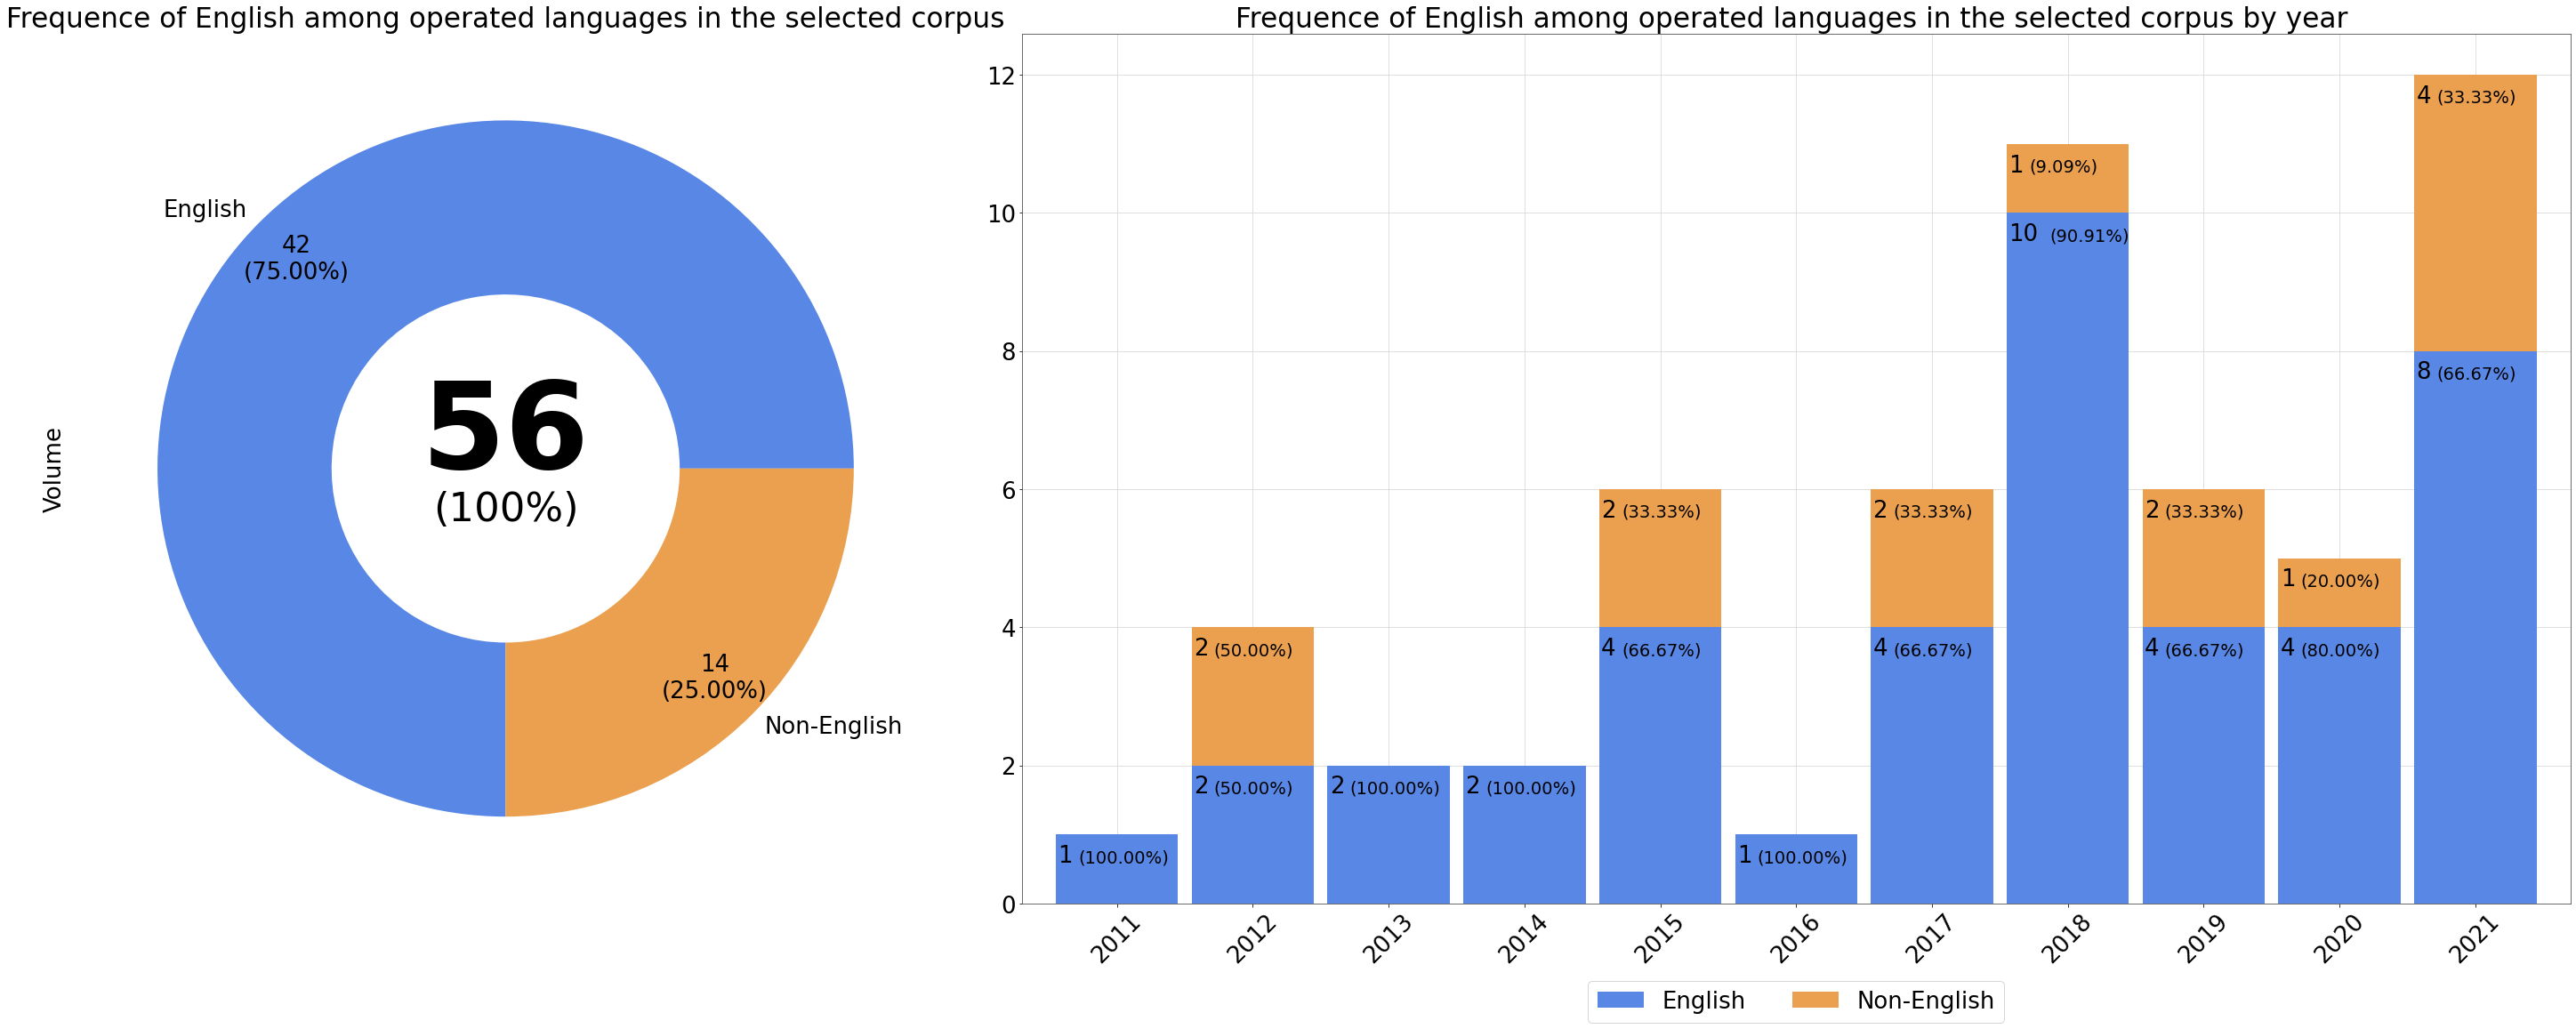

In [5]:
languages_df, all_languages = helper.languages_df(metadata)

other_languages = [language for language in all_languages if language != 'English']
english_lang_df = pd.DataFrame(languages_df.loc[:,['year']+all_languages])
english_lang_df['Non-English'] = english_lang_df.loc[:,other_languages].apply(lambda values: np.sum(values[1:]), axis=1)
english_lang_df.drop(columns=other_languages, inplace=True)
english_lang_df

helper.view(1, 2, size=(52,18)).layout(w_ratio=[4,6], w_space=0)\
      .params(1, 2, v_legends=False, legend_anchor=(0.5,-0.15))\
      .plot_summary(english_lang_df, ['English', 'Non-English'], 'Frequence of English among operated languages in the selected corpus')

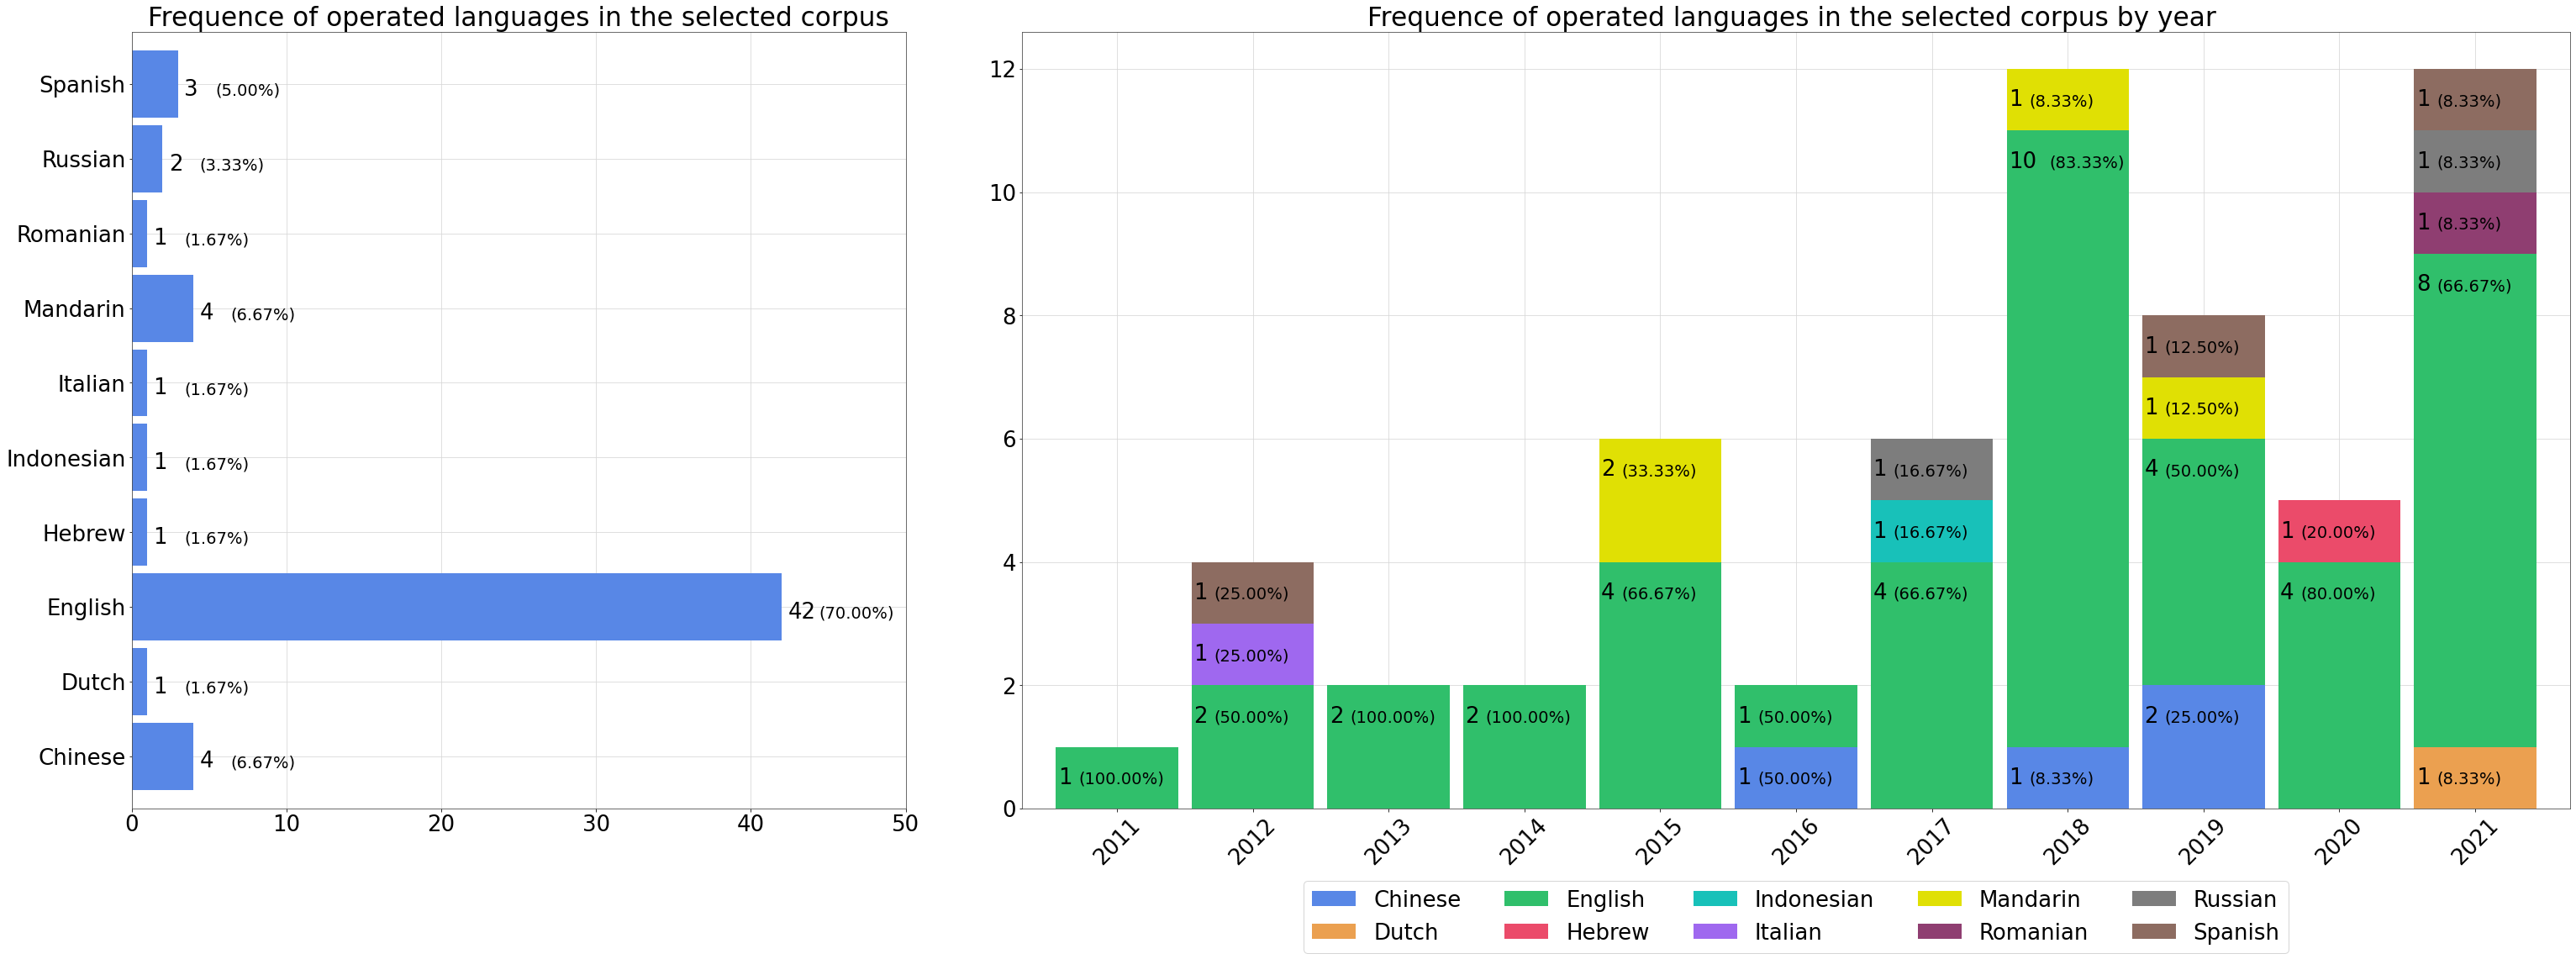

In [6]:
helper.view(1, 2, size=(52,17)).layout(w_ratio=[3,6])\
      .params(1, 1, x_lim=50, x_offset_perc=2)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.2), y_offset=0.6)\
      .plot_summary(languages_df, all_languages, 'Frequence of operated languages in the selected corpus')

### 3. Modality analysis
The following charts present the distribution of modality kinds, modality cardinalities and modality combinations.

Modality kind describes the information nature (or source of data) exploited for feature extraction (textual, visual, vocal, demographic, and so on).

Modality cardinality is the number of modality kinds combined in studies and can be one of the following:
1. **Monomodal**: only one modality is used, for instance, vocal features;
2. **Bimodal**: the combination of two modalities;
3. **Multimodal**: the combination of three or more modalities.

#### 3.1. Feature modality analysis

Different modalities were exploited all over the period of interest. This section shows which ones and when they were studies.

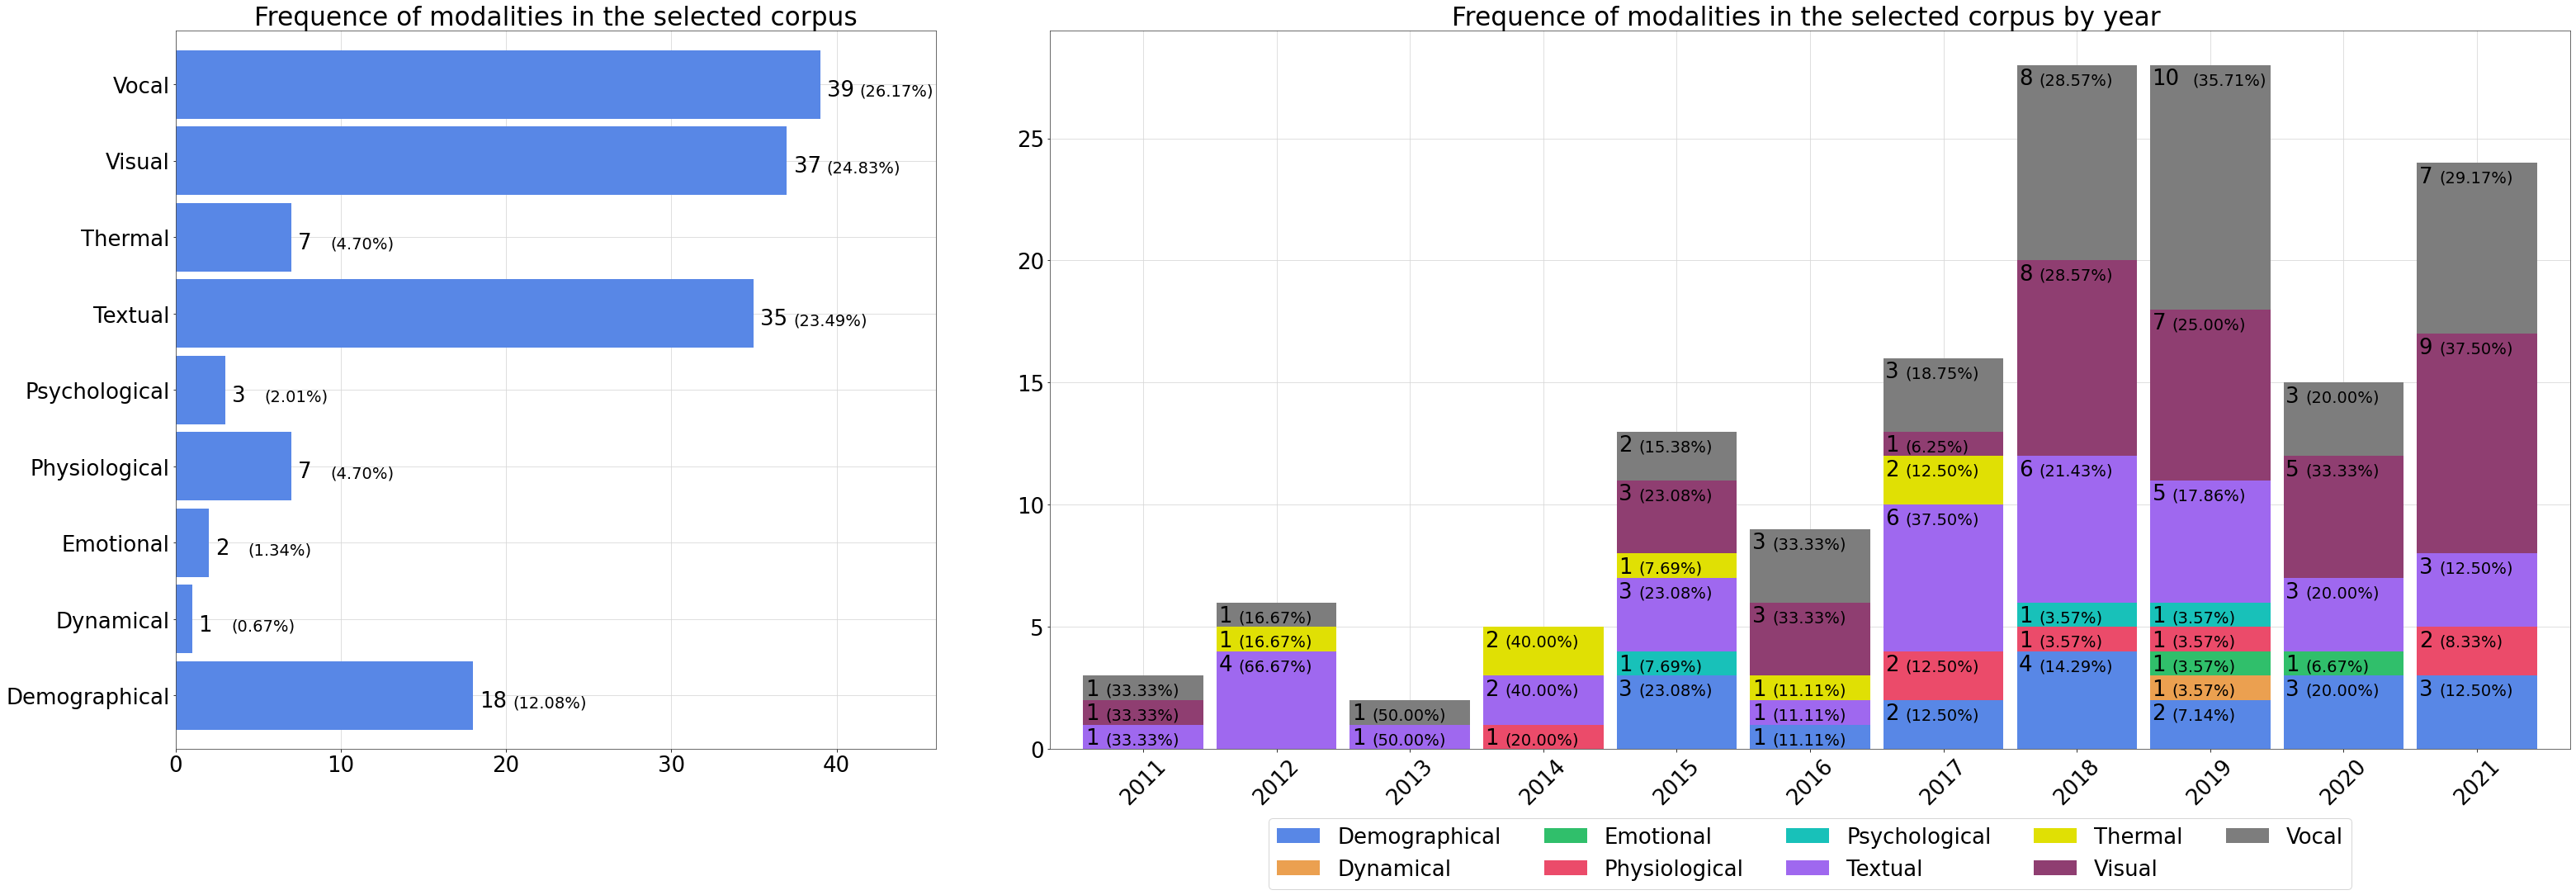

In [7]:
modalities_df, all_modalities = helper.modalities_df(metadata)
helper.view(1, 2, size=(52,16)).layout(w_ratio=[3,6])\
      .params(1, 1, x_lim=46, x_offset_perc=2)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.21), y_offset=0.8)\
      .plot_summary(modalities_df, all_modalities, 'Frequence of modalities in the selected corpus')

#### 3.2. Modality cardinality analysis

Different modalities were exploited alone (monomodal approach) or in combination with other modalities (bimodal and multimodal approaches). This section shows how modality cardinalities
are distributed in the period of interest.

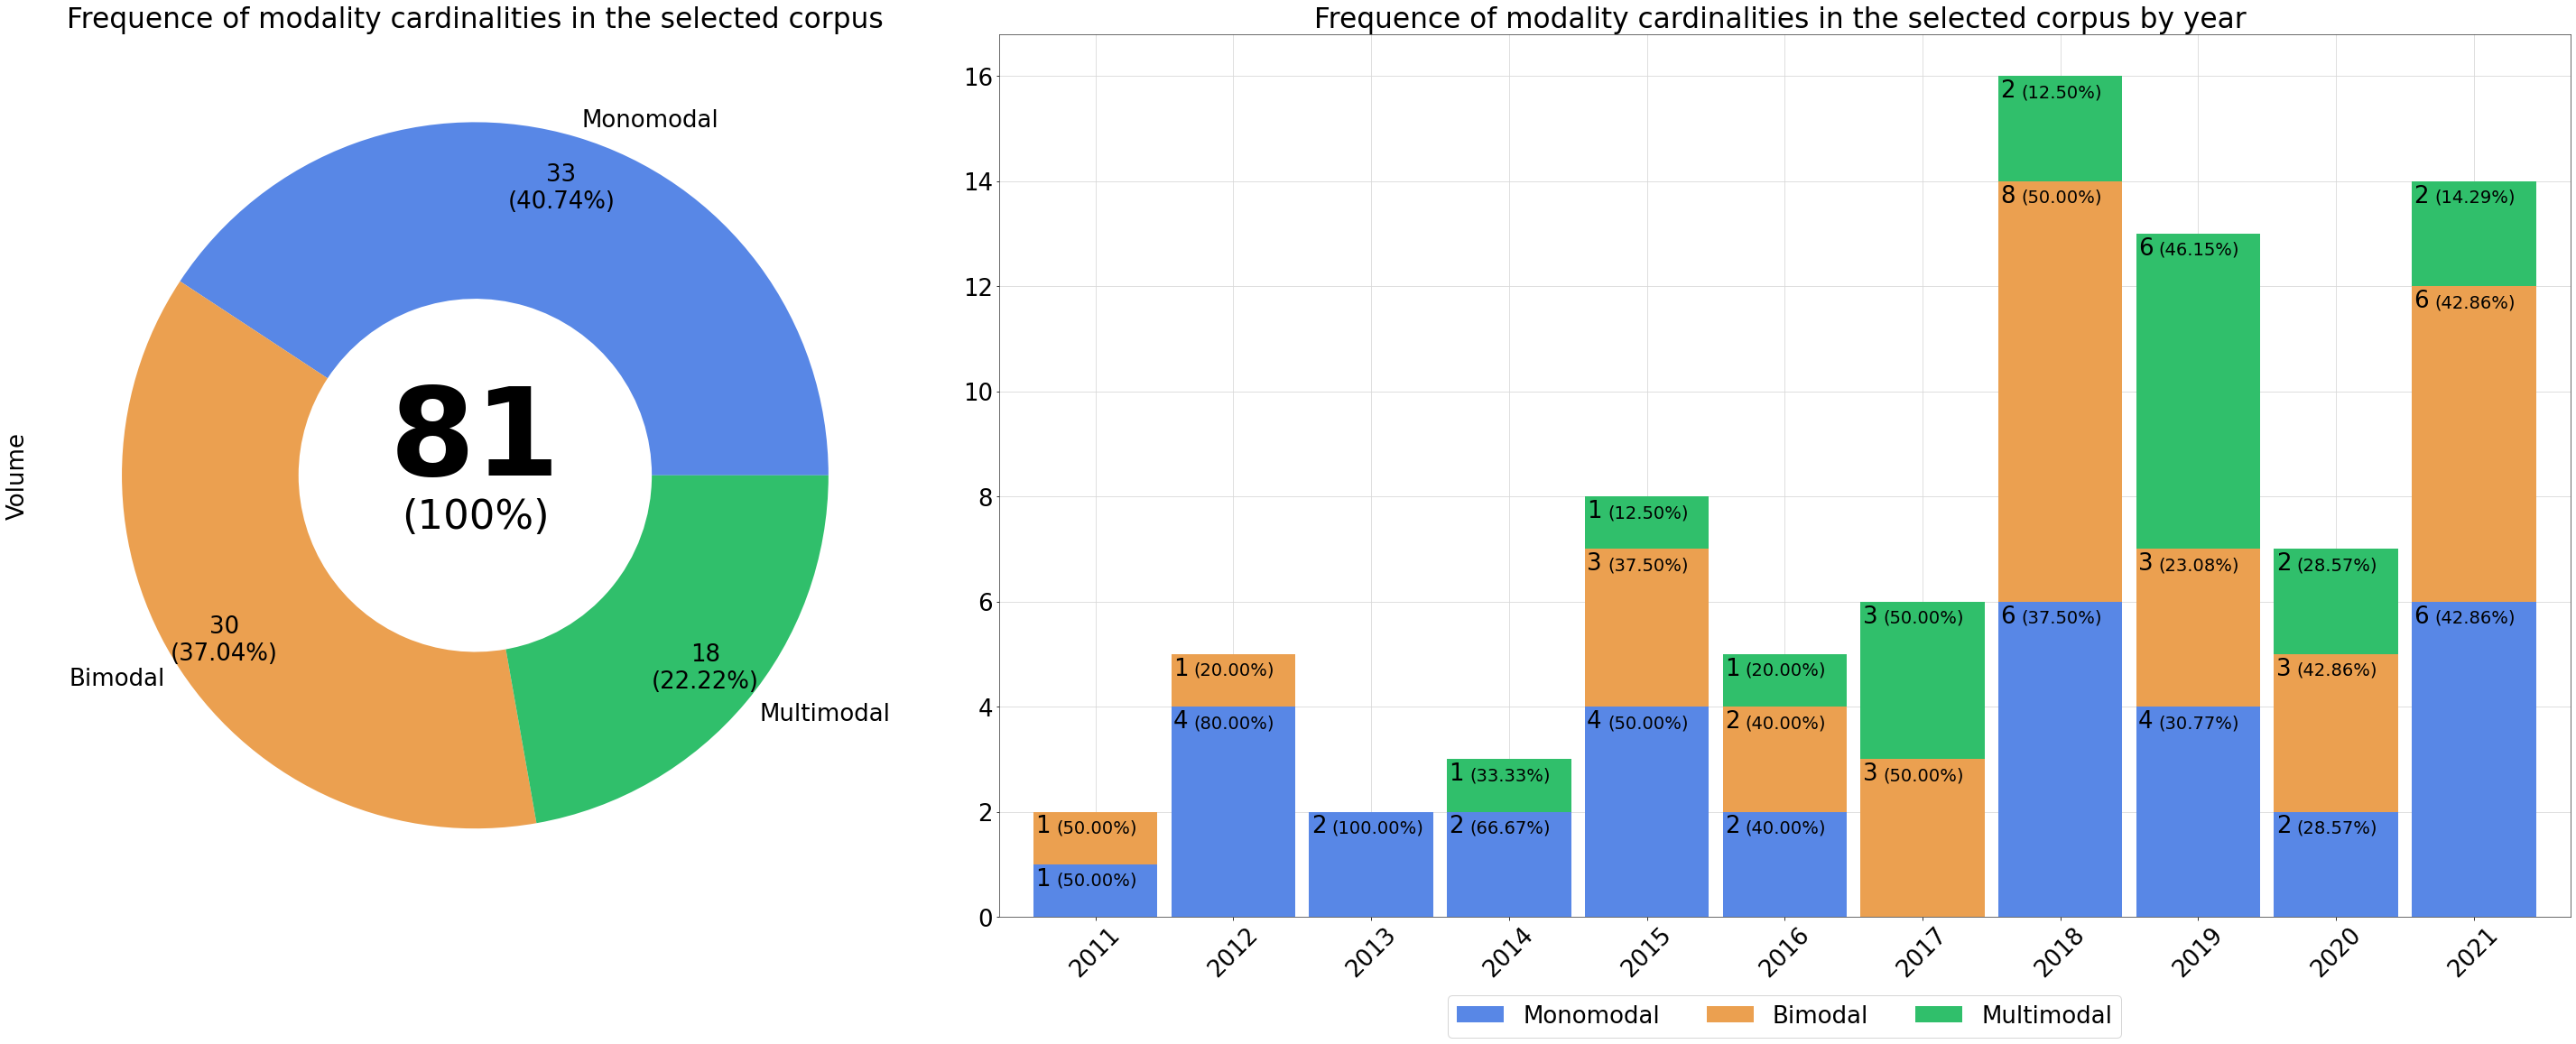

In [8]:
cardinalities_df, all_cardinalities = helper.cardinalities_df(metadata)
helper.view(1, 2, size=(52,18)).layout(w_ratio=[4,6], w_space=0)\
      .params(1, 2, v_legends=False, legend_anchor=(0.5,-0.15), perc_below=False)\
      .plot_summary(cardinalities_df, all_cardinalities, 'Frequence of modality cardinalities in the selected corpus')

#### 3.3. Monomodal studies analysis

Monomodal approach still poses as the most frequent. However, there are different modalities in monomodal studies. This section presents how those modalities are distributed in
the period of interest for monomodal studies.

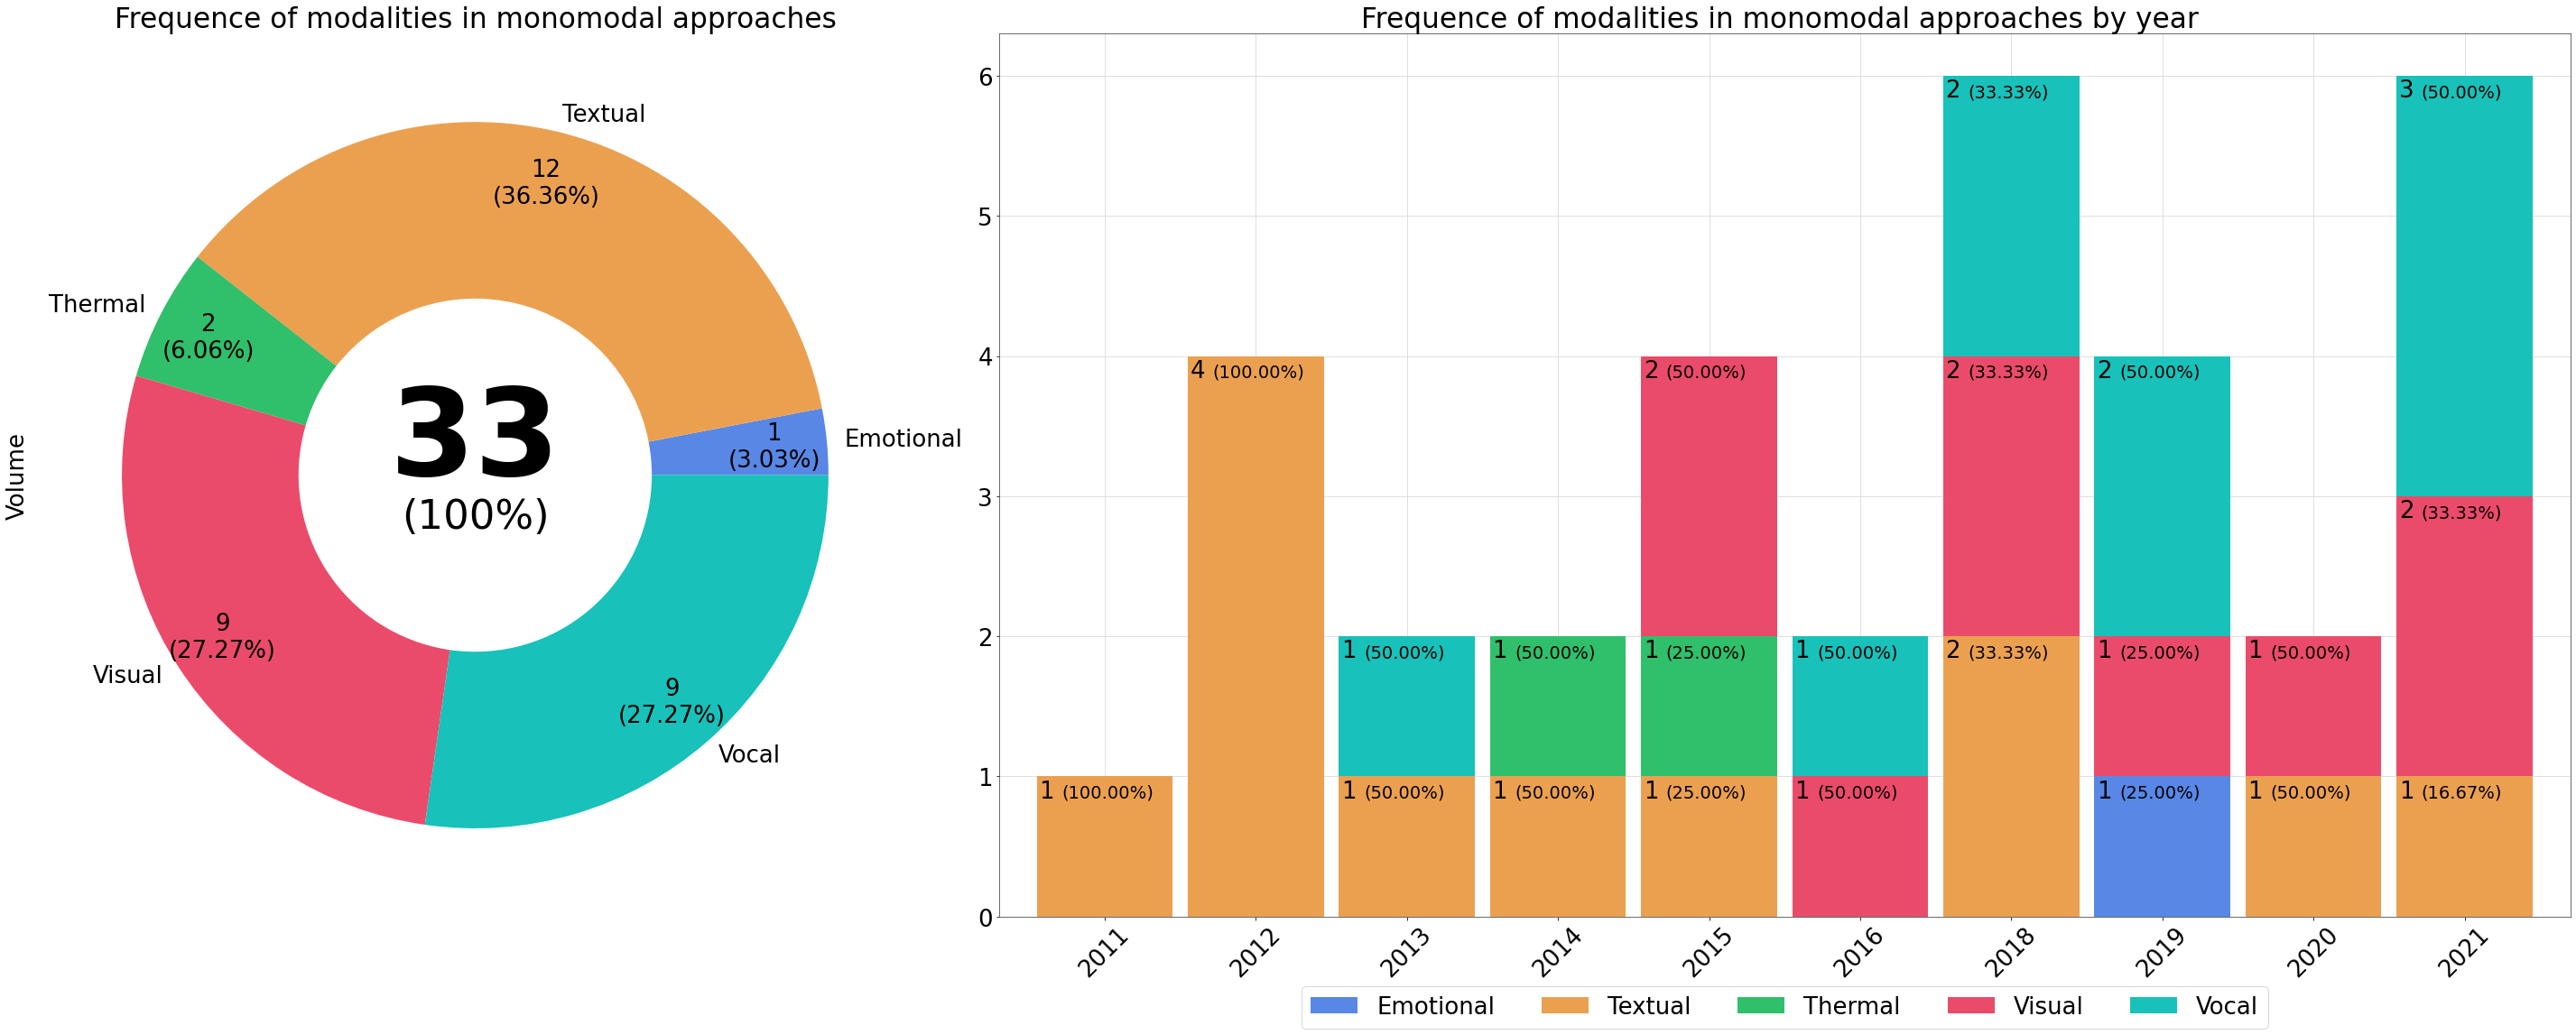

In [9]:
monomodals_df, all_monomodals = helper.modalities_df(metadata, cardinality_limit=['Monomodal'])
helper.view(1, 2, size=(52,18)).layout(w_ratio=[4,6], w_space=0)\
      .params(1, 2, v_legends=False, legend_anchor=(0.5,-0.14), y_offset=0.15, perc_below=False)\
      .plot_summary(monomodals_df, all_monomodals, 'Frequence of modalities in monomodal approaches')

#### 3.4. Bimodal studies analysis

Bimodal approach takes the second position in terms of preference. There are different distributions of modalities combinations in bimodal studies. This section presents how those modalities
are combined and distributed in the period of interest for bimodal studies.

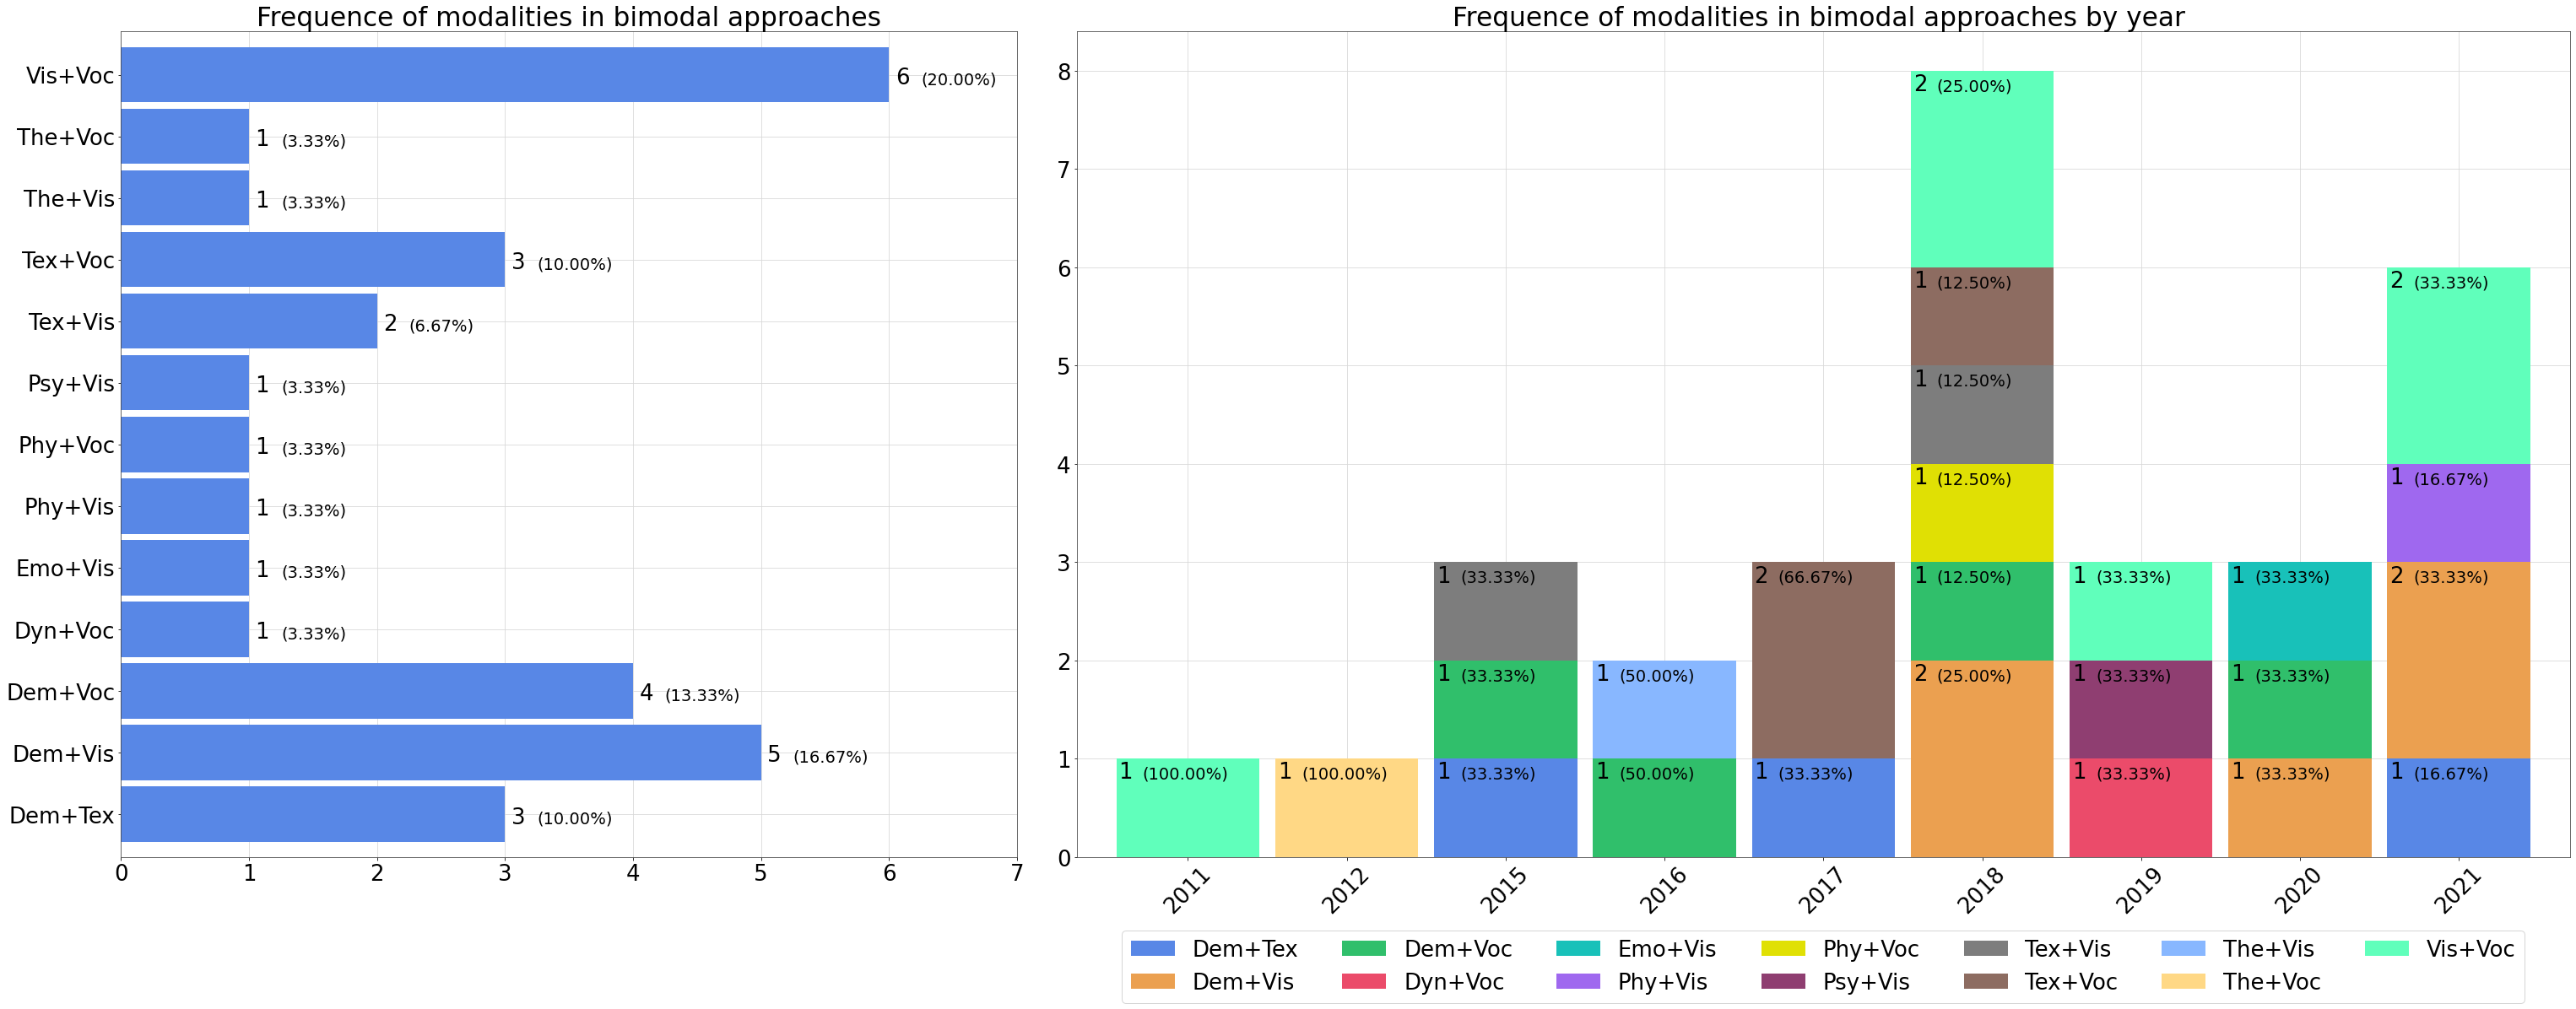

In [10]:
bimodals_df, all_bimodals = helper.modalities_df(metadata, cardinality_limit=['Bimodal'], combine_modalities=True)
helper.view(1, 2, size=(52,18)).layout(w_ratio=[3,5], w_space=0.05)\
      .params(1, 1, x_lim=7, x_offset=0.05)\
      .params(1, 2, v_legends=False, legend_cols=7, legend_anchor=(0.5,-0.19), y_offset=0.2, perc_below=False)\
      .plot_summary(bimodals_df, all_bimodals, 'Frequence of modalities in bimodal approaches')

#### 3.5. Multimodal studies analysis

Multimodal approach is least preferred one among studies. However, there are different distributions of modalities combinations in multimodal studies. This section presents
how those modalities are combined and distributed in the period of interest for multimodal studies.

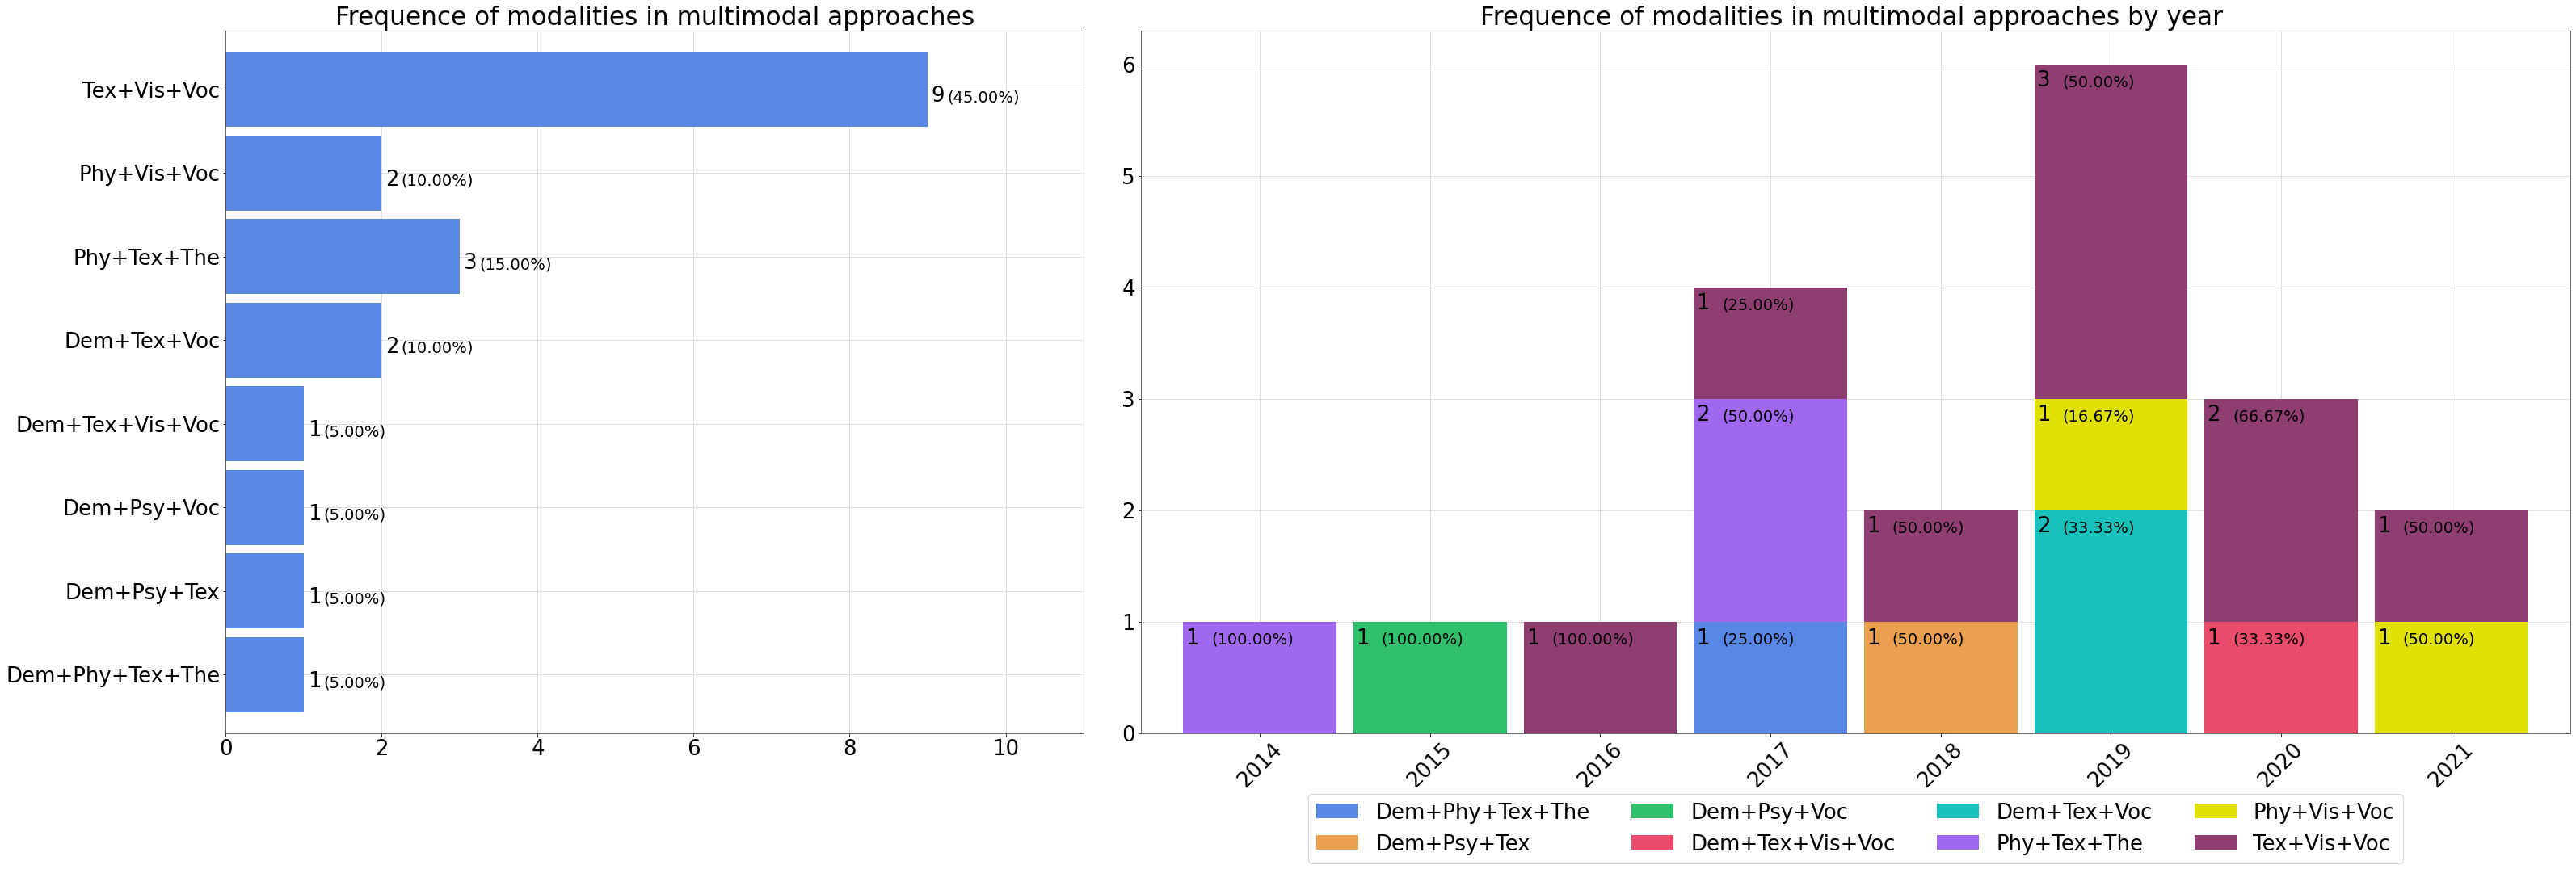

In [11]:
multimodals_df, all_multimodals = helper.modalities_df(metadata, cardinality_limit=['Multimodal'], combine_modalities=True)
helper.view(1, 2, size=(52,16)).layout(w_ratio=[3,5], w_space=0.05)\
      .params(1, 1, x_lim=11, x_offset=0.05)\
      .params(1, 2, v_legends=False, legend_cols=4, legend_anchor=(0.5,-0.2), y_offset=0.2)\
      .plot_summary(multimodals_df, all_multimodals, 'Frequence of modalities in multimodal approaches')

### 4. Features analysis
A feature is one data item used to describe a certain aspect that characterizes the collected behavior and are used as
cues for deception detection.

The next charts summarize the metadata that describe the deception detection modality features used in the selected documents.

#### 4.1 Textual features analysis
Textual features are verbal cues directly extracted from textual data, existing in written messages or transcribed
from recordings.

According to theory, the behavioral changes that happen when someone is deceiving also affects the way such a
person verbalizes, promoting variations of different kinds on what is written or said.

Those changes may be represented by various features extracted from text (written or transcribed).

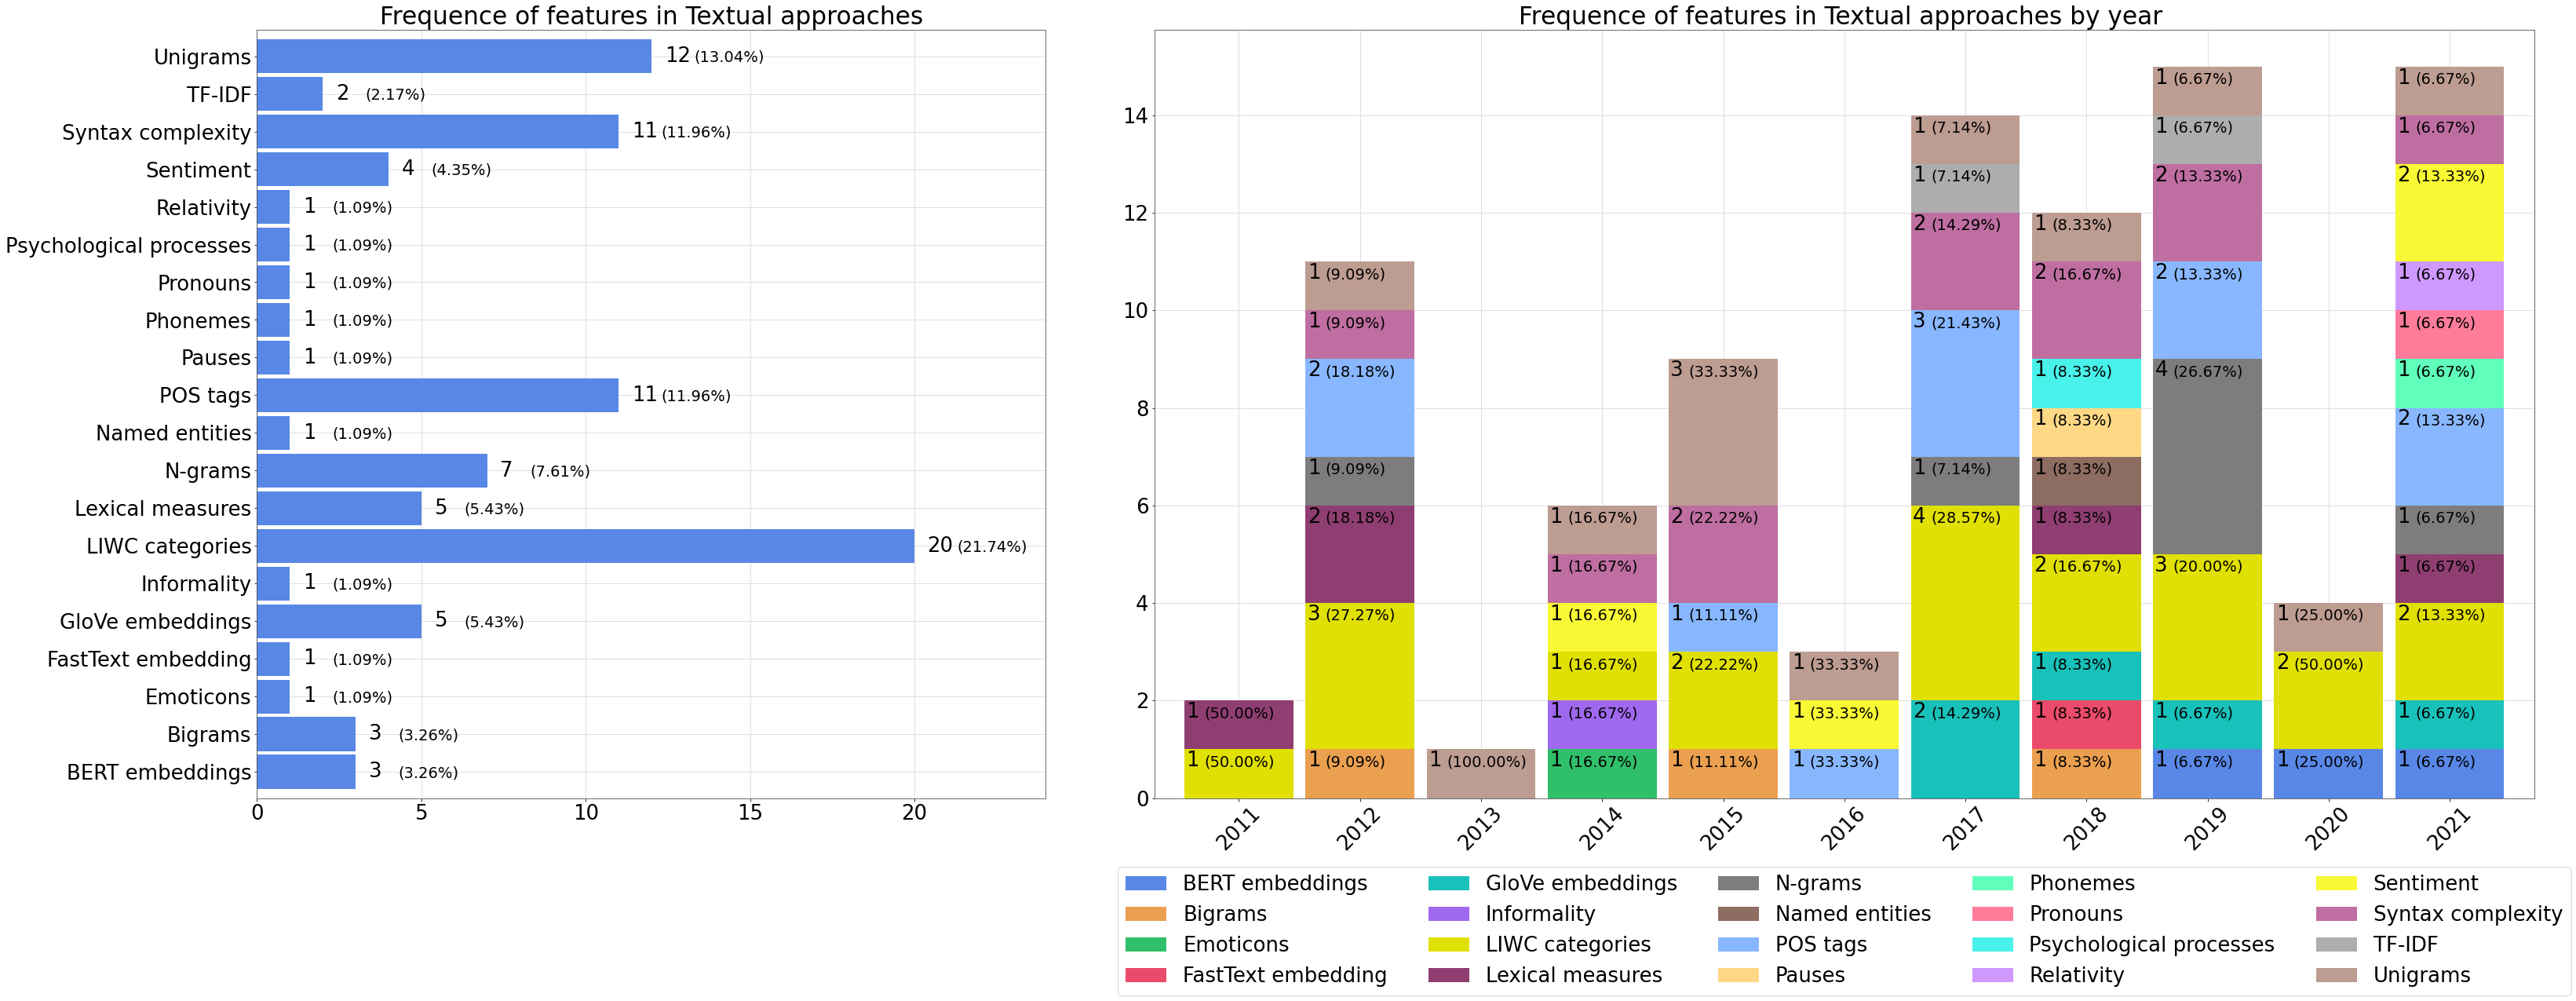

In [12]:
features_df, all_features = helper.features_df(metadata, modality='Textual')
helper.view(1, 2, size=(52,18)).layout(w_ratio=[4,7])\
      .params(1, 1, x_lim=24, x_offset_perc=0.9)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.27), y_offset=0.35)\
      .plot_summary(features_df, all_features, 'Frequence of features in Textual approaches')

#### 4.2. Visual features analysis
Visual features are non-verbal cues extracted from video recordings.

According to theory, the behavioral changes that happen when someone is deceiving also affects the way such a
person moves or poses the body, members or the head, including facial expressions, eye gaze and blinks.

Those changes may be represented by various features extracted from video recordings.

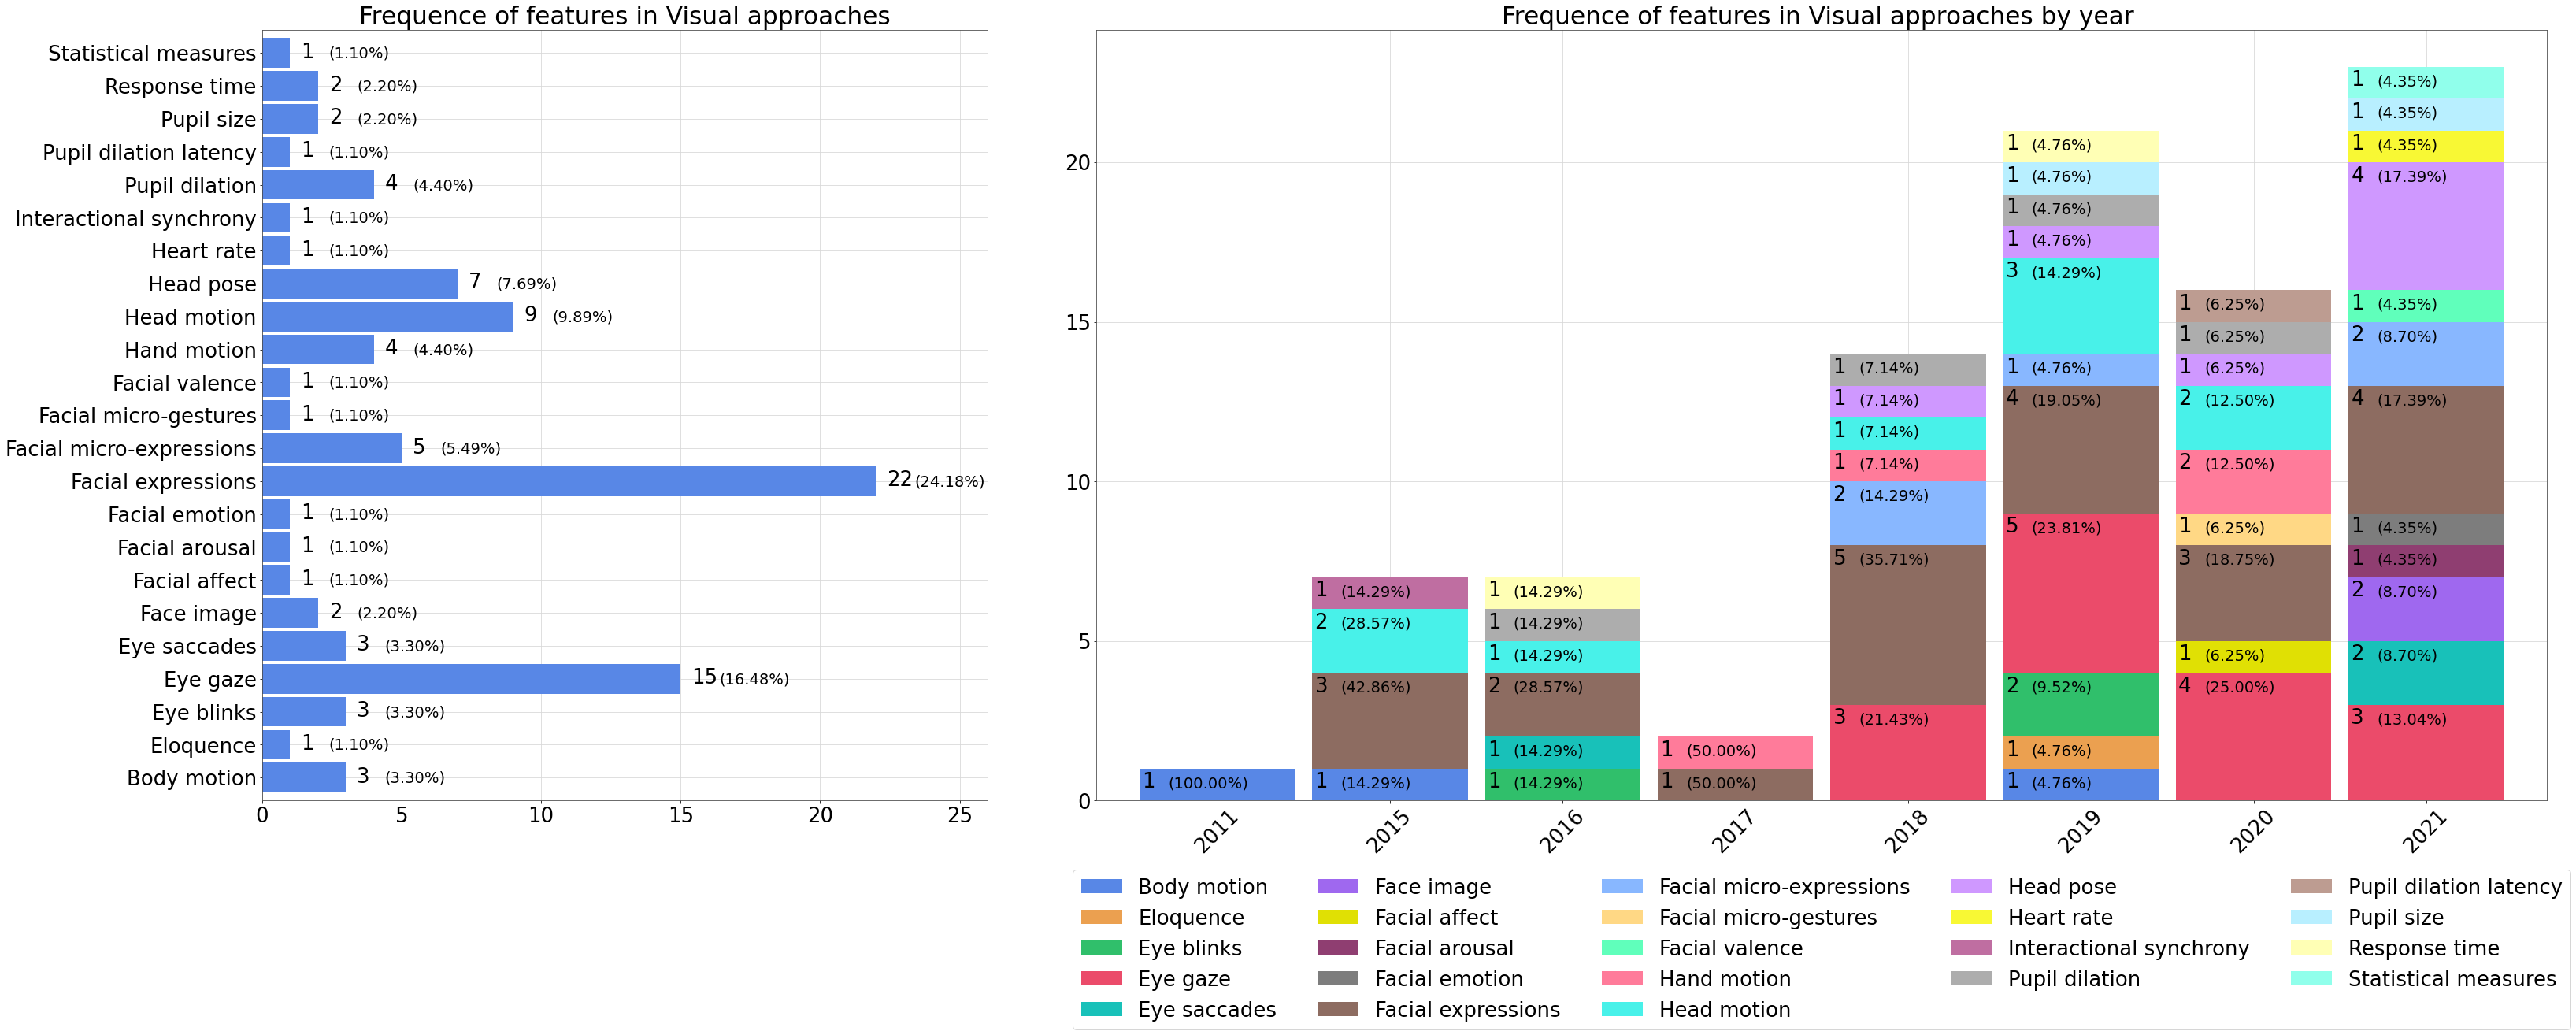

In [13]:
features_df, all_features = helper.features_df(metadata, modality='Visual')
helper.view(1, 2, size=(52,18)).layout(w_ratio=[3,6])\
      .params(1, 1, x_lim=26, x_offset_perc=1)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.31), y_offset=0.6)\
      .plot_summary(features_df, all_features, 'Frequence of features in Visual approaches')

#### 4.3. Vocal features analysis
Vocal features are non-verbal cues extracted from video or audio recordings.

According to theory, the behavioral changes that happen when someone is deceiving also affects the voice
of such a person, in an acoustic sense.

Those changes may be represented by various features extracted from video ou audio recordings.

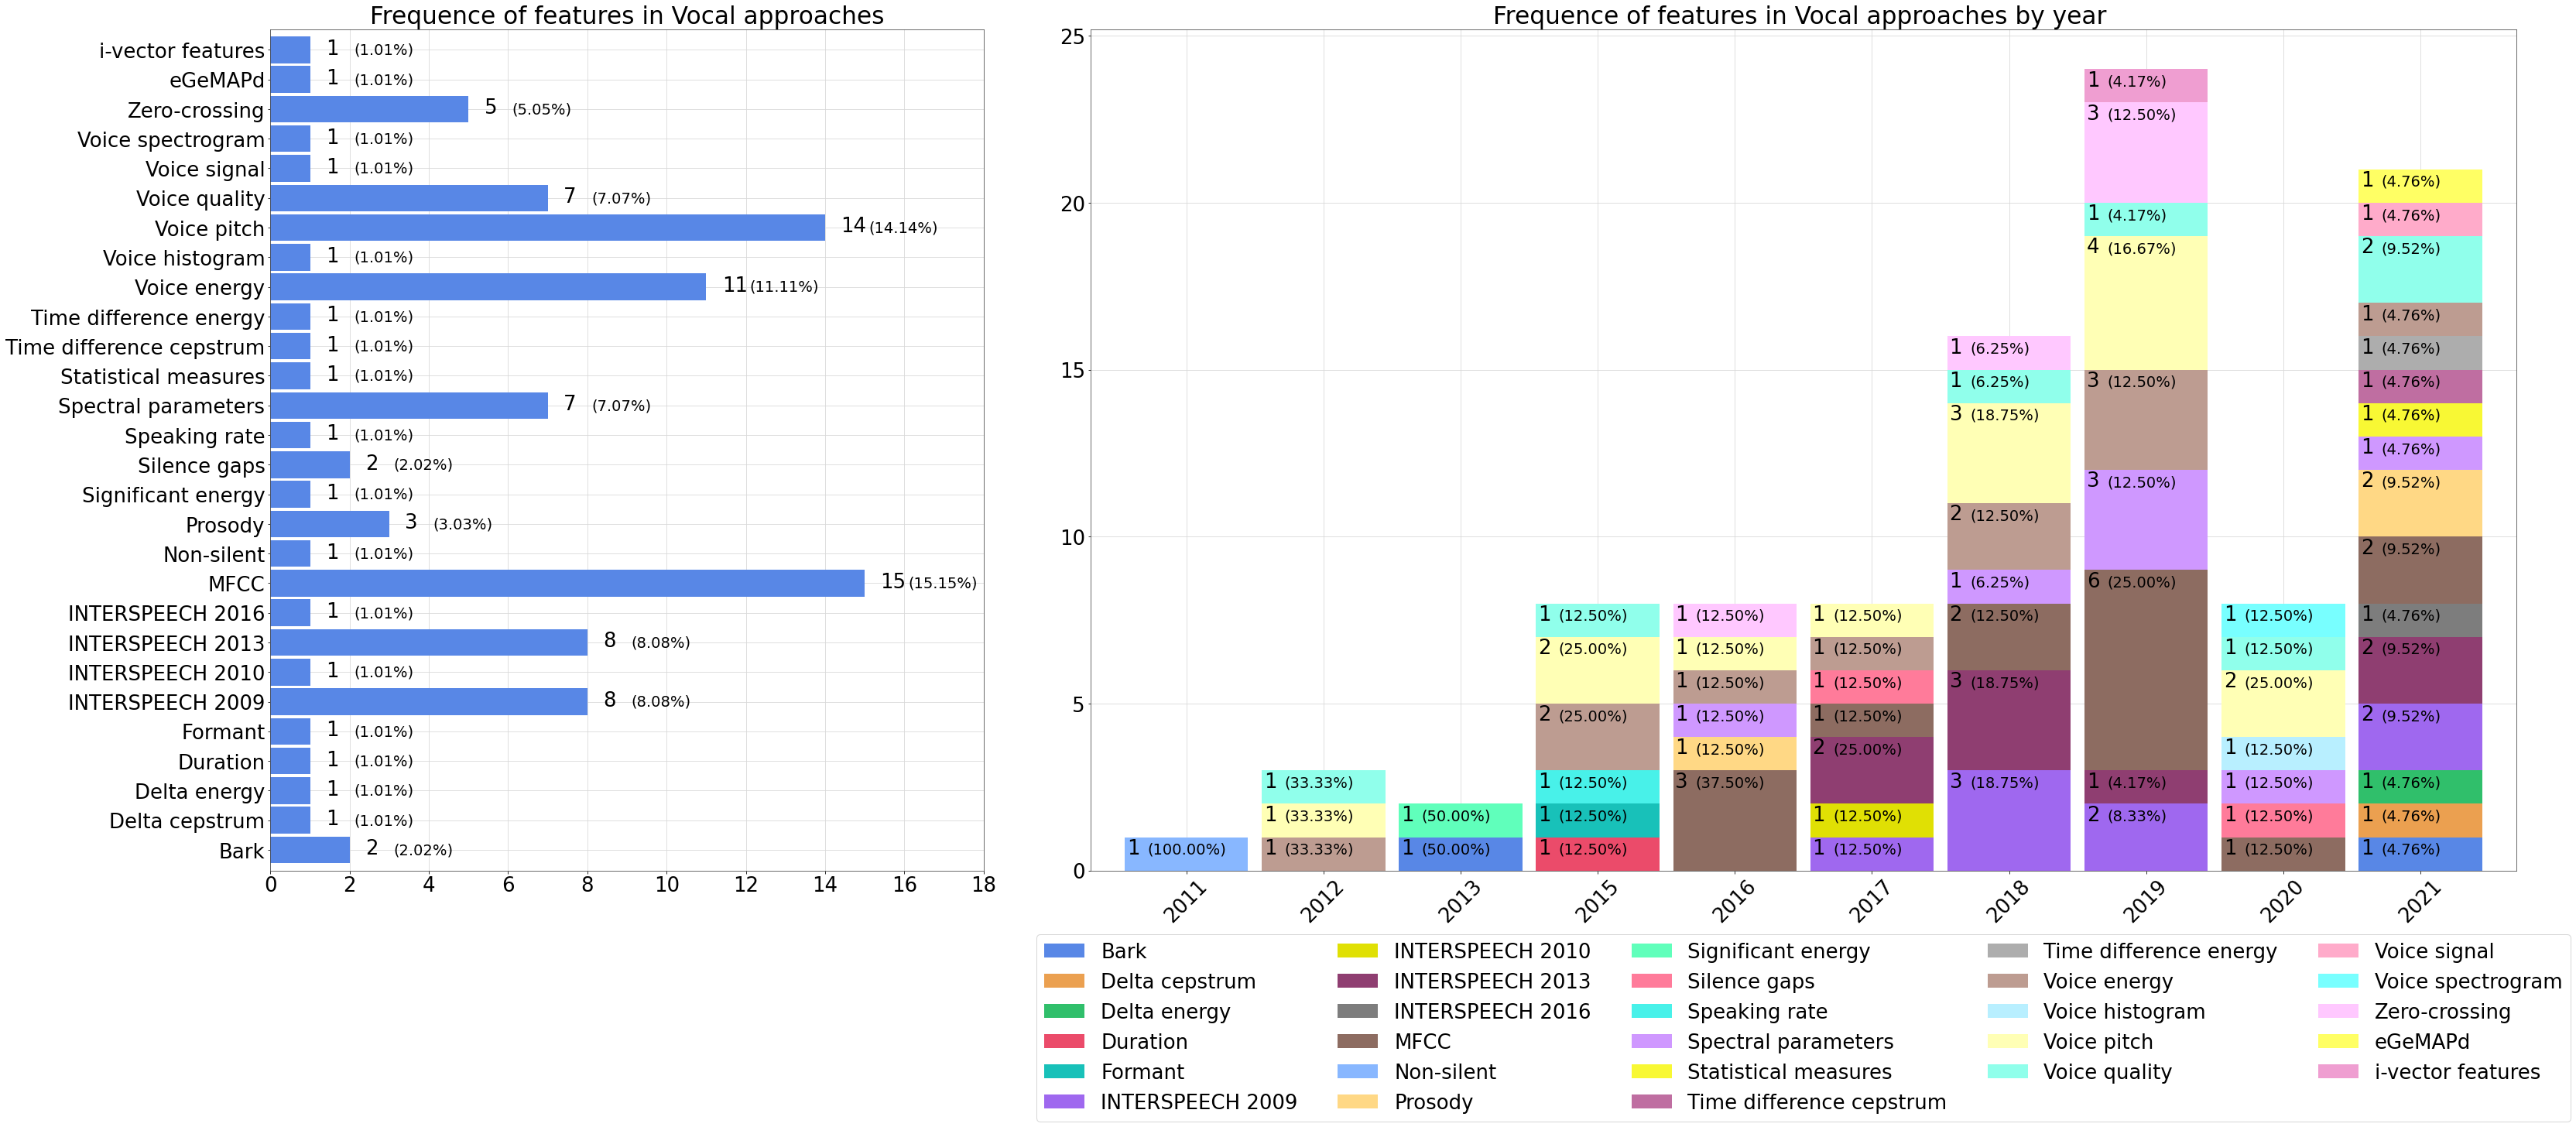

In [14]:
features_df, all_features = helper.features_df(metadata, modality='Vocal')
helper.view(1, 2, size=(52,20)).layout(w_ratio=[3,6])\
      .params(1, 1, x_lim=18, x_offset_perc=0.7)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.31), y_offset=0.5)\
      .plot_summary(features_df, all_features, 'Frequence of features in Vocal approaches')

#### 4.4. Thermal feature analysis
Thermal features are non-verbal cues extracted from thermal video recordings.

According to theory, the body changes that happen when someone is deceiving also affects the
physiology of such a person, affecting the blood flow that alter the temperature of body parts.

Those changes may be represented by various features extracted from thermal video recordings.

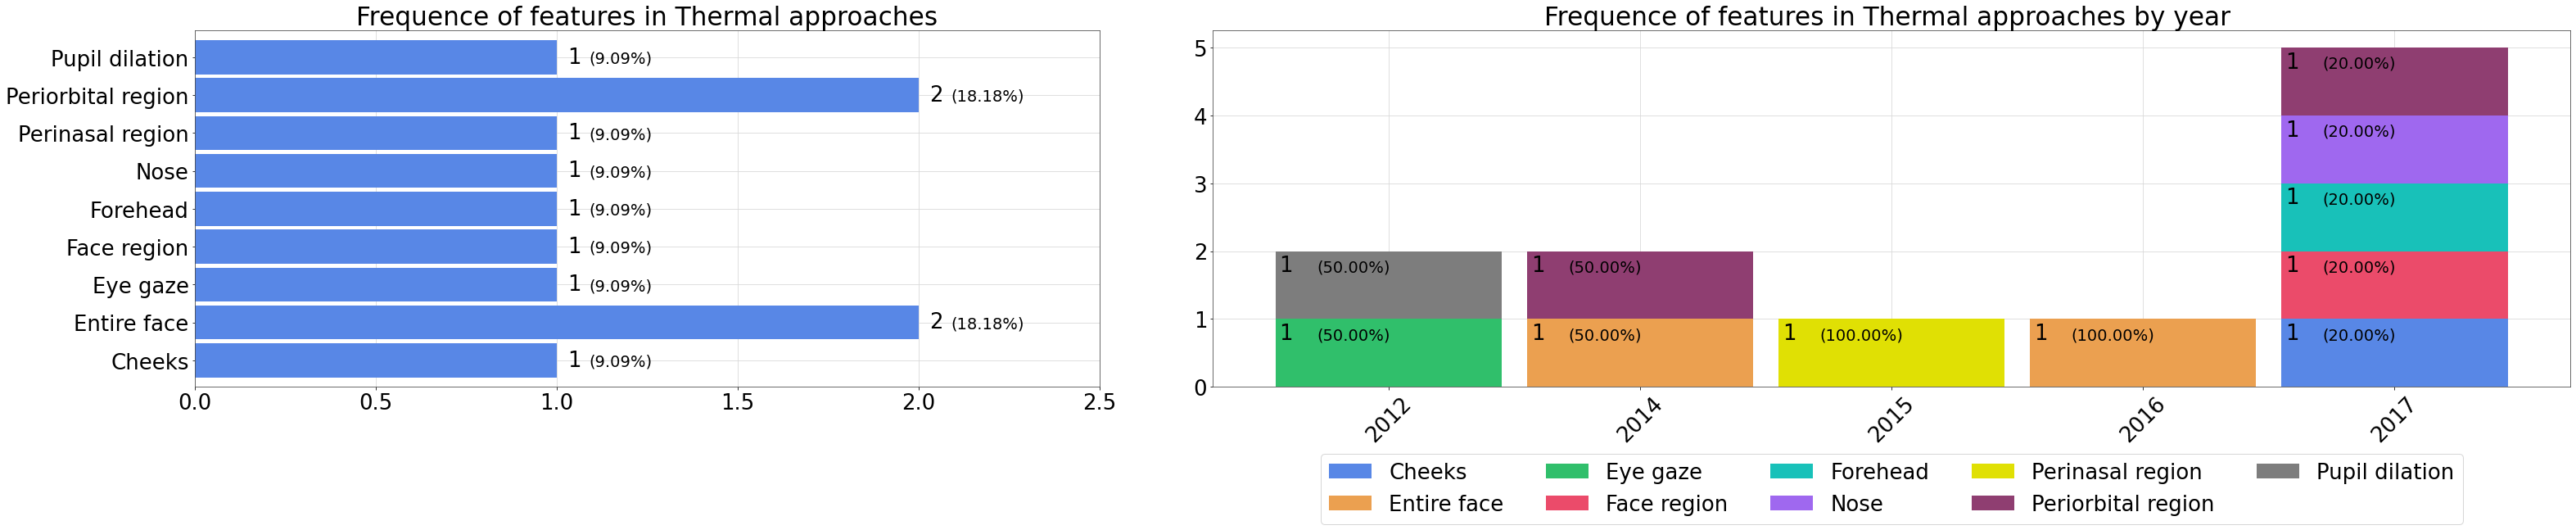

In [15]:
features_df, all_features = helper.features_df(metadata, modality='Thermal')
helper.view(1, 2, size=(52,8)).layout(w_ratio=[4,6])\
      .params(1, 1, x_lim=2.5, x_offset=0.03, x_offset_perc=0.06)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.415), y_offset=0.3)\
      .plot_summary(features_df, all_features, 'Frequence of features in Thermal approaches')

#### 4.5. Demographical feature analysis
Demographical features are not cues for deception detection but are additional data that may establish
behavior differences that may affect the detection process.

Theory suggests that deception cues may vary based on gender.

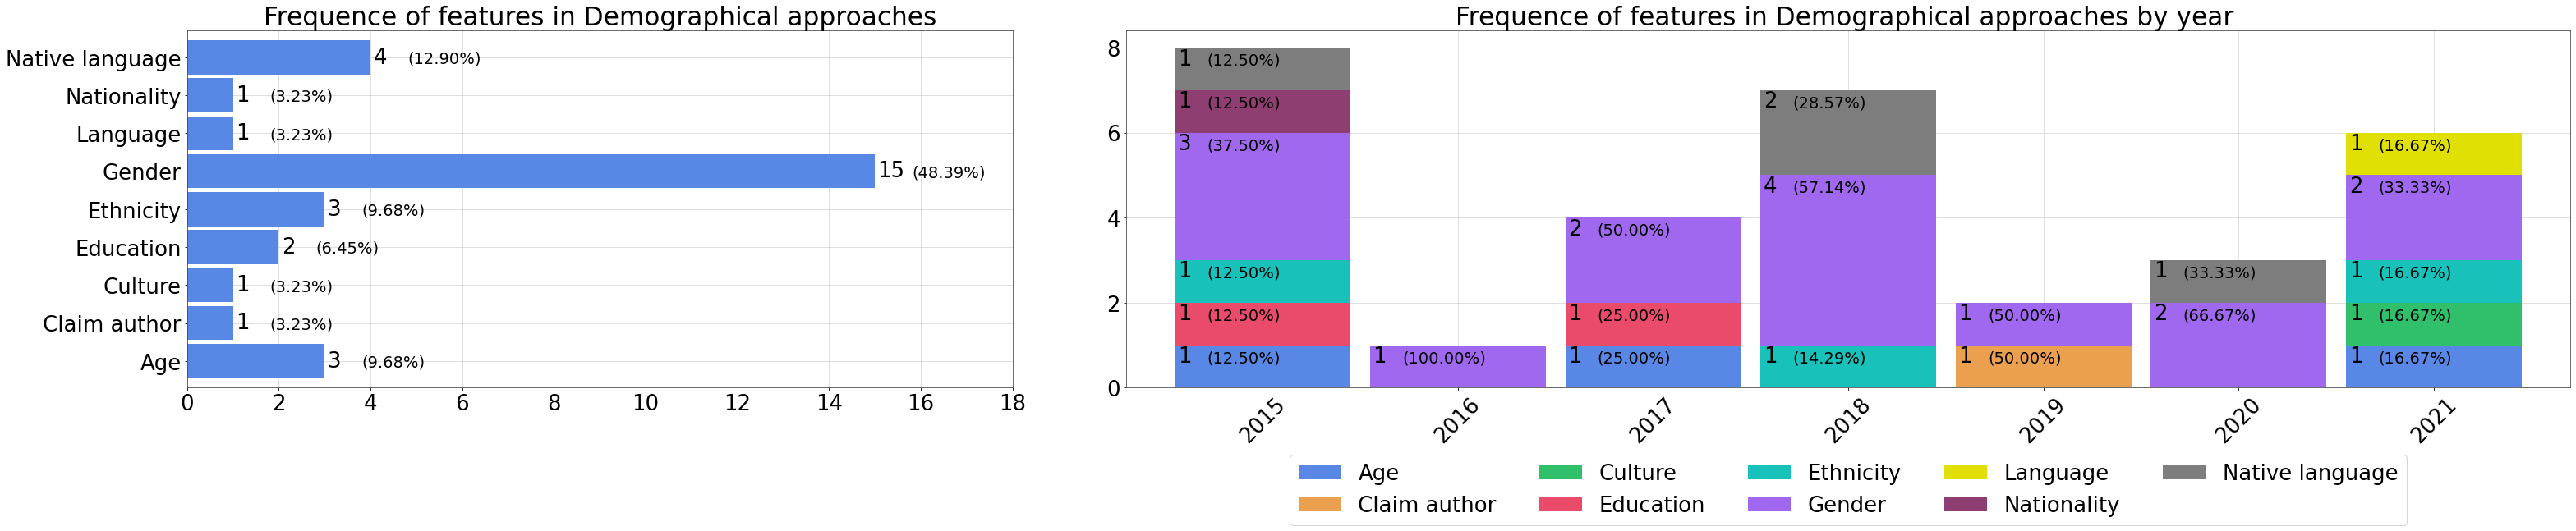

In [16]:
features_df, all_features = helper.features_df(metadata, modality='Demographical')
helper.view(1, 2, size=(52,8))\
      .layout(w_ratio=[4,7])\
      .params(1, 1, x_lim=18, x_offset=0.06, x_offset_perc=0.75)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.415), y_offset=0.4)\
      .plot_summary(features_df, all_features, 'Frequence of features in Demographical approaches')

#### 4.6. Physiological features analysis
Physiological features are non-verbal cues extracted from special sensors.

According to theory, the body changes that happen when someone is deceiving also affects the physiology of such a person,
affecting a number of physiological functions.

Those changes may be represented by various features extracted from sensor readings.

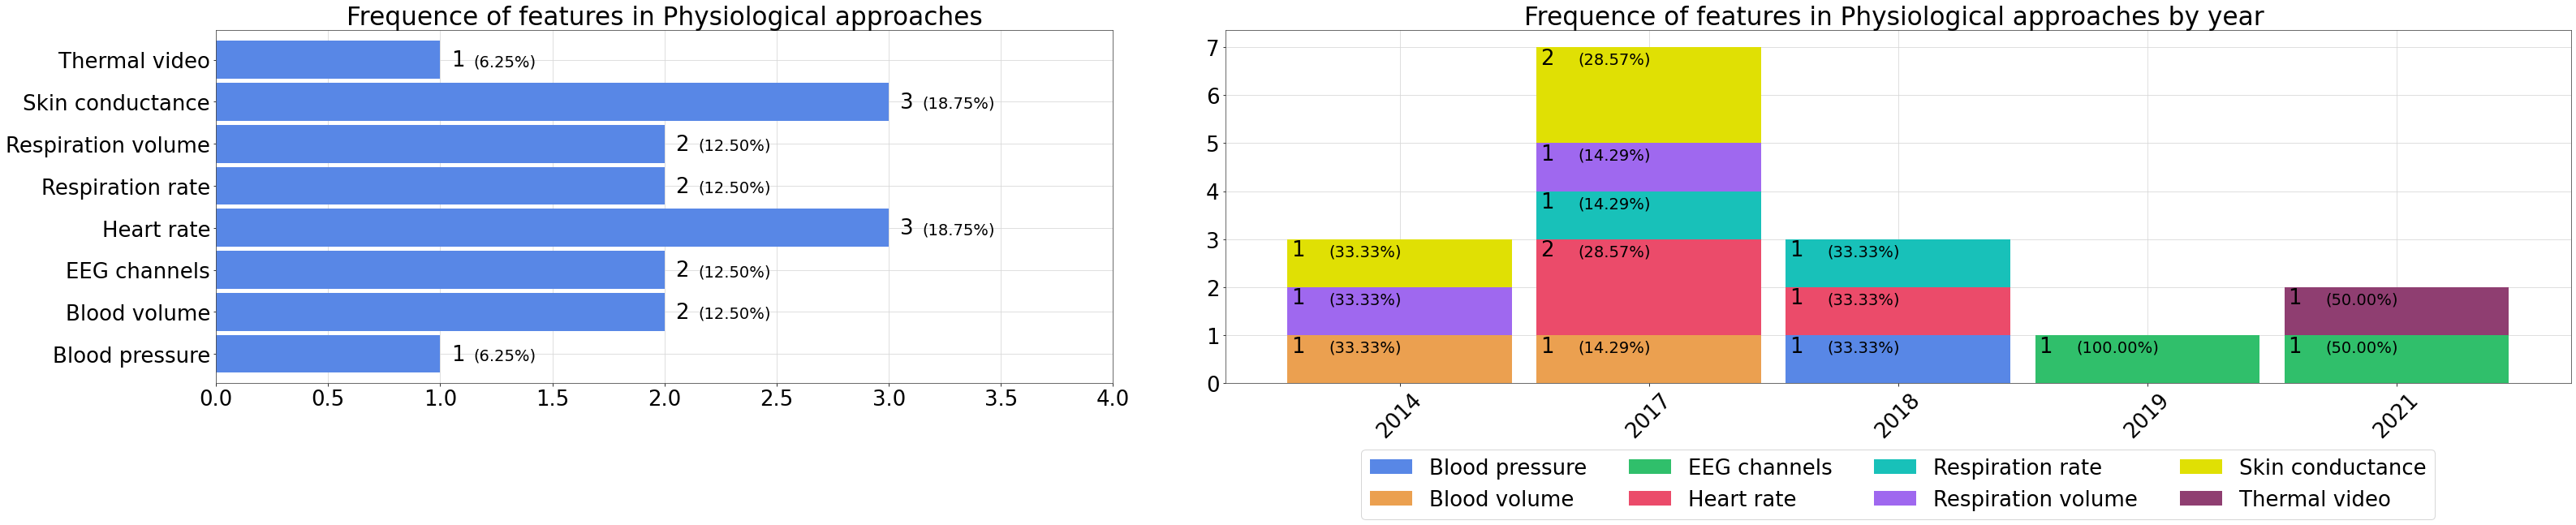

In [17]:
features_df, all_features = helper.features_df(metadata, modality='Physiological')
helper.view(1, 2, size=(52,8)).layout(w_ratio=[4,6])\
      .params(1, 1, x_lim=4, x_offset=0.05, x_offset_perc=0.1)\
      .params(1, 2, v_legends=False, legend_cols=4, legend_anchor=(0.5,-0.415), y_offset=0.35)\
      .plot_summary(features_df, all_features, 'Frequence of features in Physiological approaches')

#### 4.7. Remaining features analysis
Besides the previous modality-specific features, below there are some remaining modalities that
were exploited in just a few studies, not justifying dedicated charts.

In [18]:
#helper.features_metadata(metadata, modality=['Dynamical', 'Emotional', 'Psychological'])
dyn_features_df, all_features = helper.features_df(metadata, modality='Dynamical', includes=['year', 'title'], expand=False)
emo_features_df, all_features = helper.features_df(metadata, modality='Emotional', includes=['year', 'title'], expand=False)
psy_features_df, all_features = helper.features_df(metadata, modality='Psychological', includes=['year', 'title'], expand=False)
features_df = pd.concat([dyn_features_df, emo_features_df, psy_features_df]).loc[:, ['year', 'title', 'features']]
features_df.style.set_caption(f'<h2>Remaining features exploited in studies</h2>')

### 5. Machine Learning techniques analysis
The area of Machine Learning offers a wide range of possibilities for classification problems, not counting for clustering and association rules, among others. Authors exploited the
Machine Learning arsenal by experimenting 26 different algorithms.

The next charts present some findings about the Machine Learning techniques used by the studies in the selected corpus.

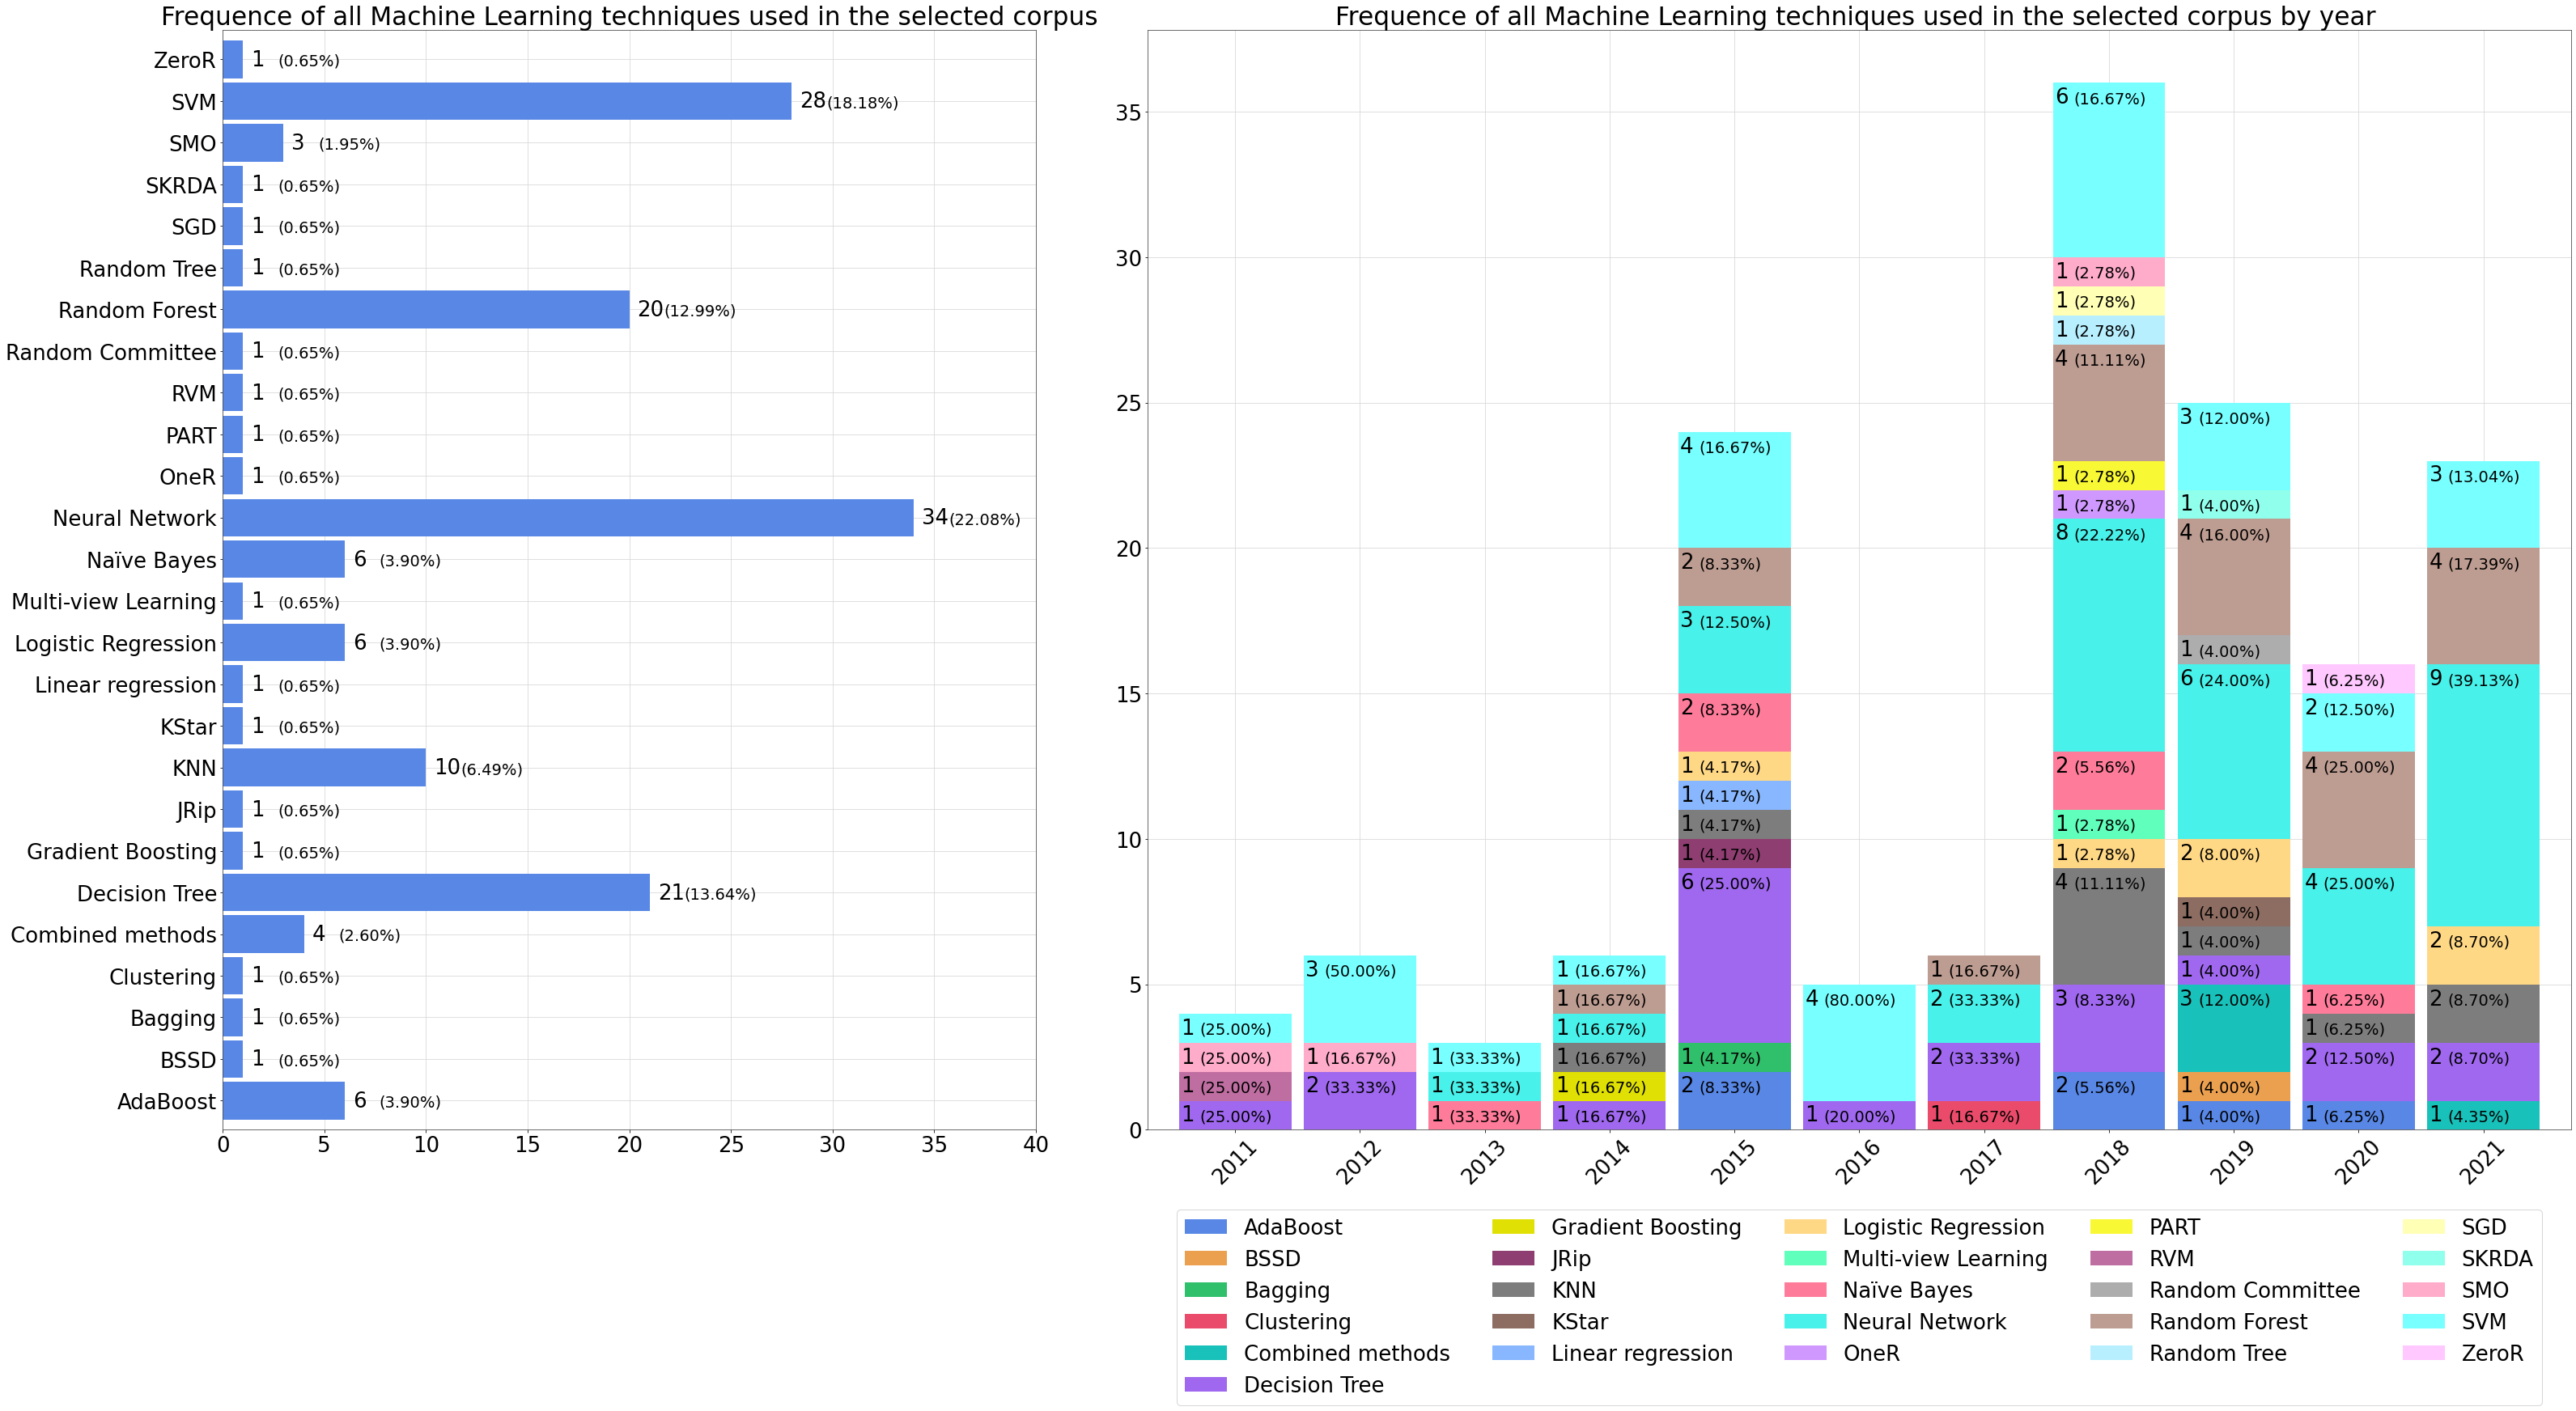

In [19]:
techniques_df, all_techniques = helper.techniques_df(metadata)
helper.view(1, 2, size=(52,25)).layout(w_ratio=[4,7])\
      .params(1, 1, x_lim=40, x_offset_perc=1.3)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.26), y_offset=0.7)\
      .plot_summary(techniques_df, all_techniques, 'Frequence of all Machine Learning techniques used in the selected corpus')

#### 5.1. Rank of Machine Learning techniques
Some Machine Learning techniques were exploited by many different authors in diverse conditions. Others had less recurrence and some have one single case of use.

The charts belos present a rank of the top five most used techniques and the frequency of the remaining ones.

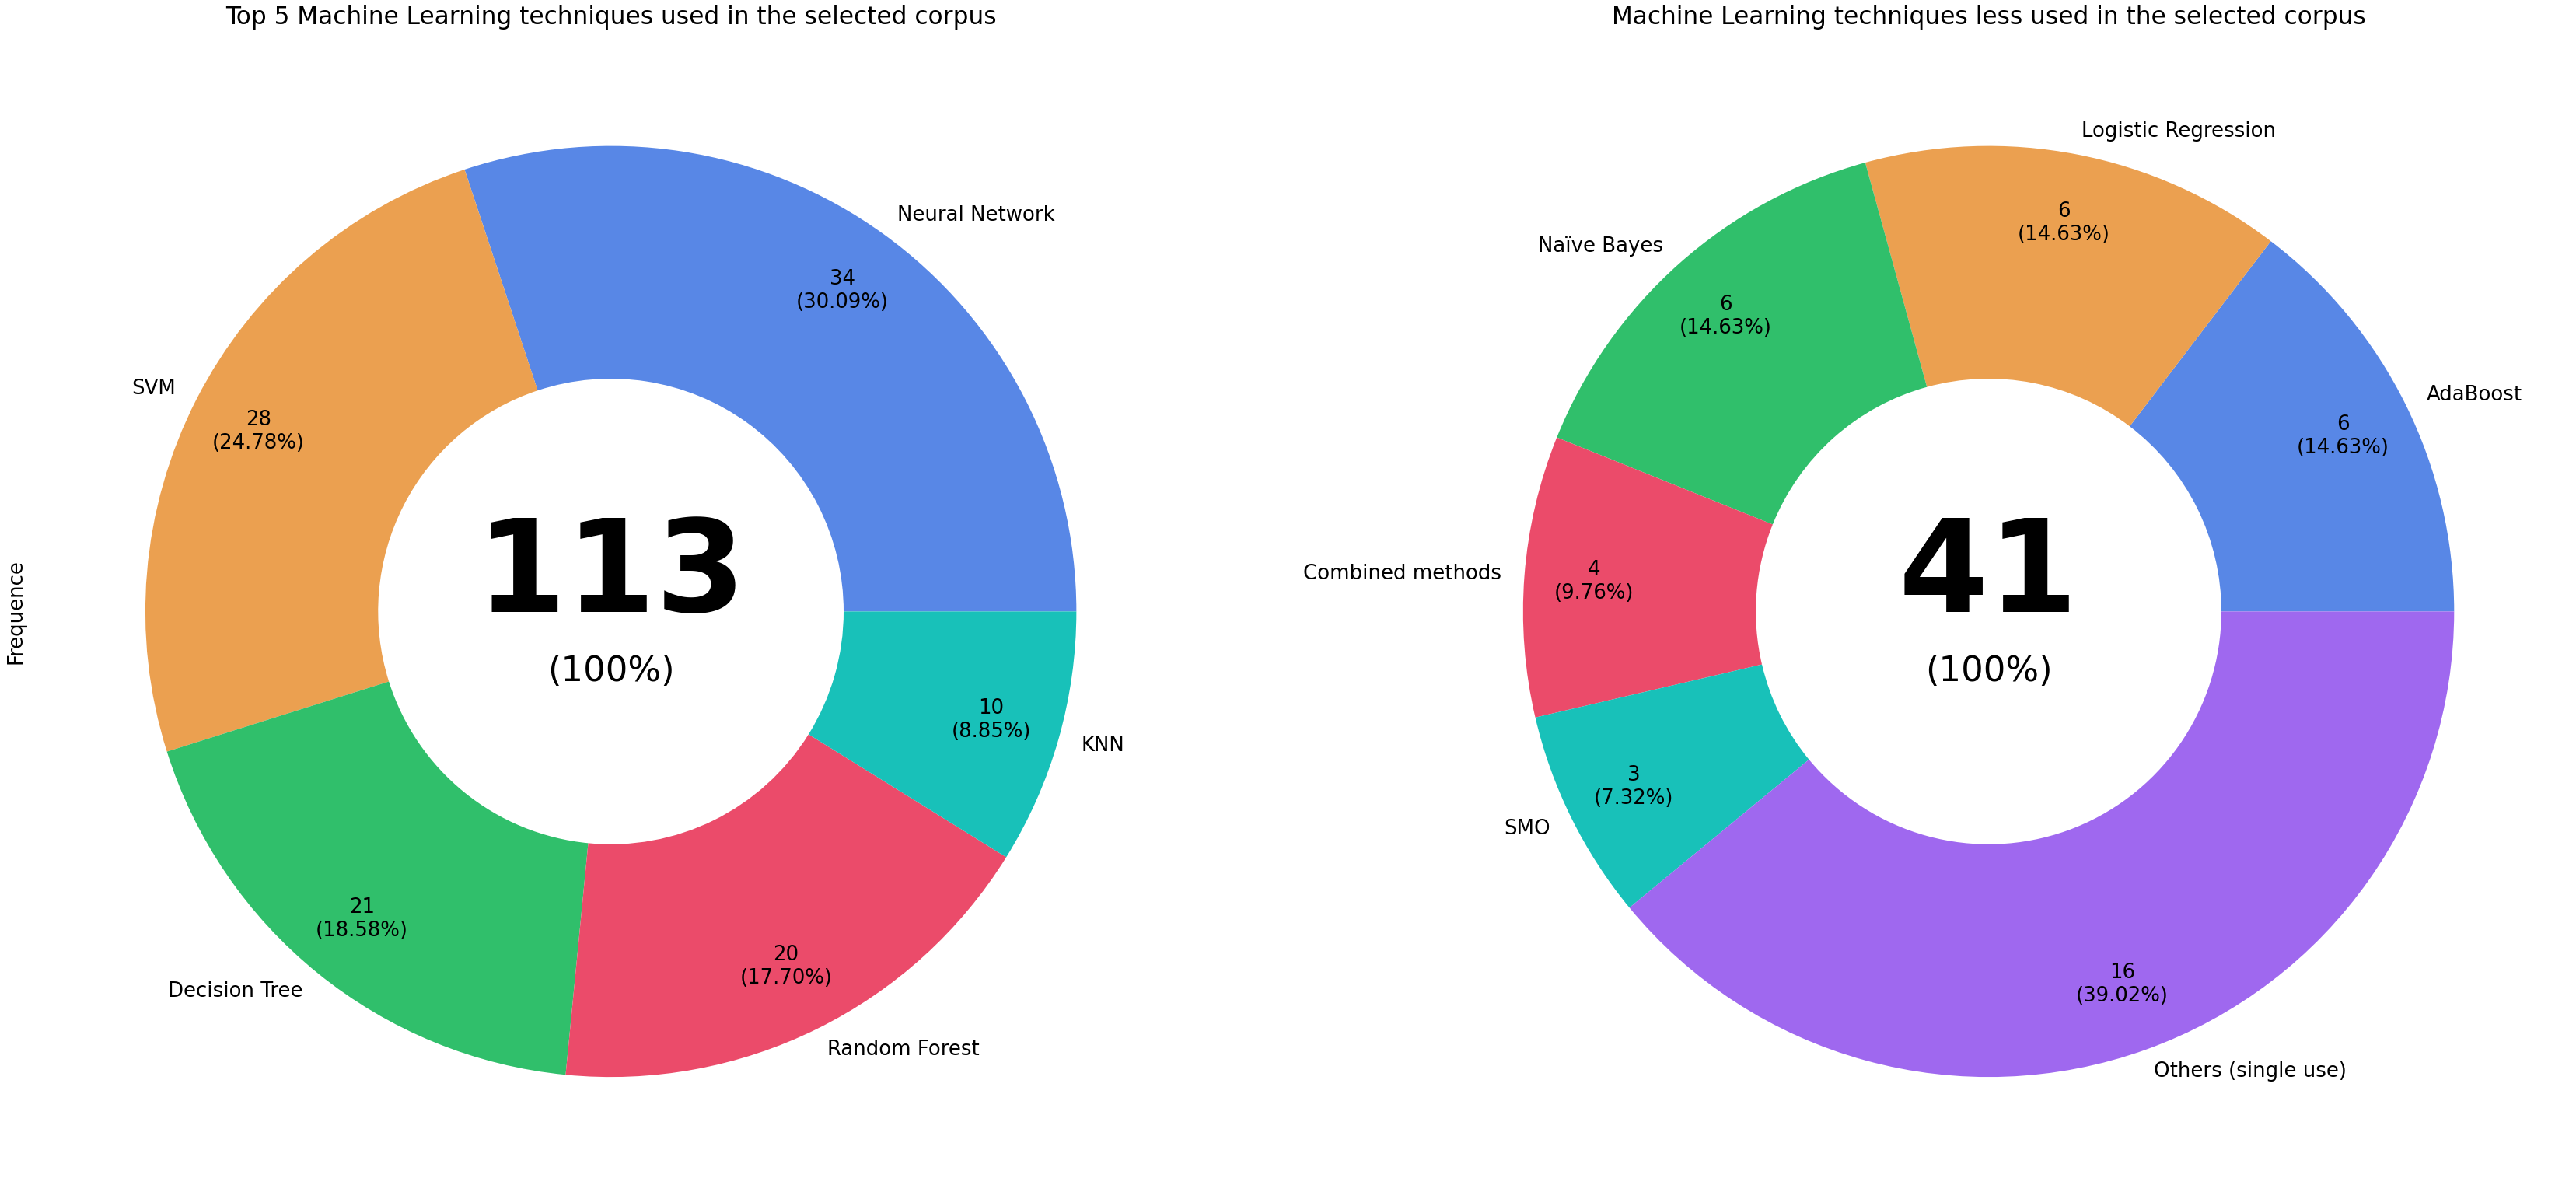

In [20]:
ranking_size = 5
#technique_rank_df = technique_sum_df.sort_values(technique_sum_df.columns[0], ascending=False)
technique_rank_df = pd.DataFrame(techniques_df.loc[:,all_techniques].sum(), columns=['Frequence']).sort_values('Frequence', ascending=False)
technique_top_df = pd.DataFrame(technique_rank_df.iloc[0:ranking_size,:])
technique_lower_df = pd.DataFrame(technique_rank_df.iloc[ranking_size:,:])
technique_single_df = pd.DataFrame(technique_rank_df[technique_rank_df['Frequence'] == 1].sum()).transpose().set_axis(['Others (single use)'])
technique_lower_df = pd.DataFrame(technique_lower_df[technique_lower_df['Frequence'] > 1])
technique_lower_df = pd.concat([technique_lower_df, technique_single_df])

top_names = sorted(list(technique_top_df.index))

fig, ax = plt.subplots(1, 2, figsize=(50,22), gridspec_kw={'height_ratios': [1], 'width_ratios': [1, 1], 'wspace': 0, 'hspace': 0})
fig.set_tight_layout(0.07)

utility.donut(technique_top_df, f'Top {ranking_size} Machine Learning techniques used in the selected corpus', ax=ax[0])
utility.donut(technique_lower_df, f'Machine Learning techniques less used in the selected corpus', ax=ax[1])
plt.show()

#### 5.2. Machine Learning flavors

Some Machine Learning techniques have variations and sub models that are better suited for some kinds of problems or some levels of complexity. This section details those different flavors of
the top 5 Machine Learning techniques. Only **Random Forest** does not present any variations.

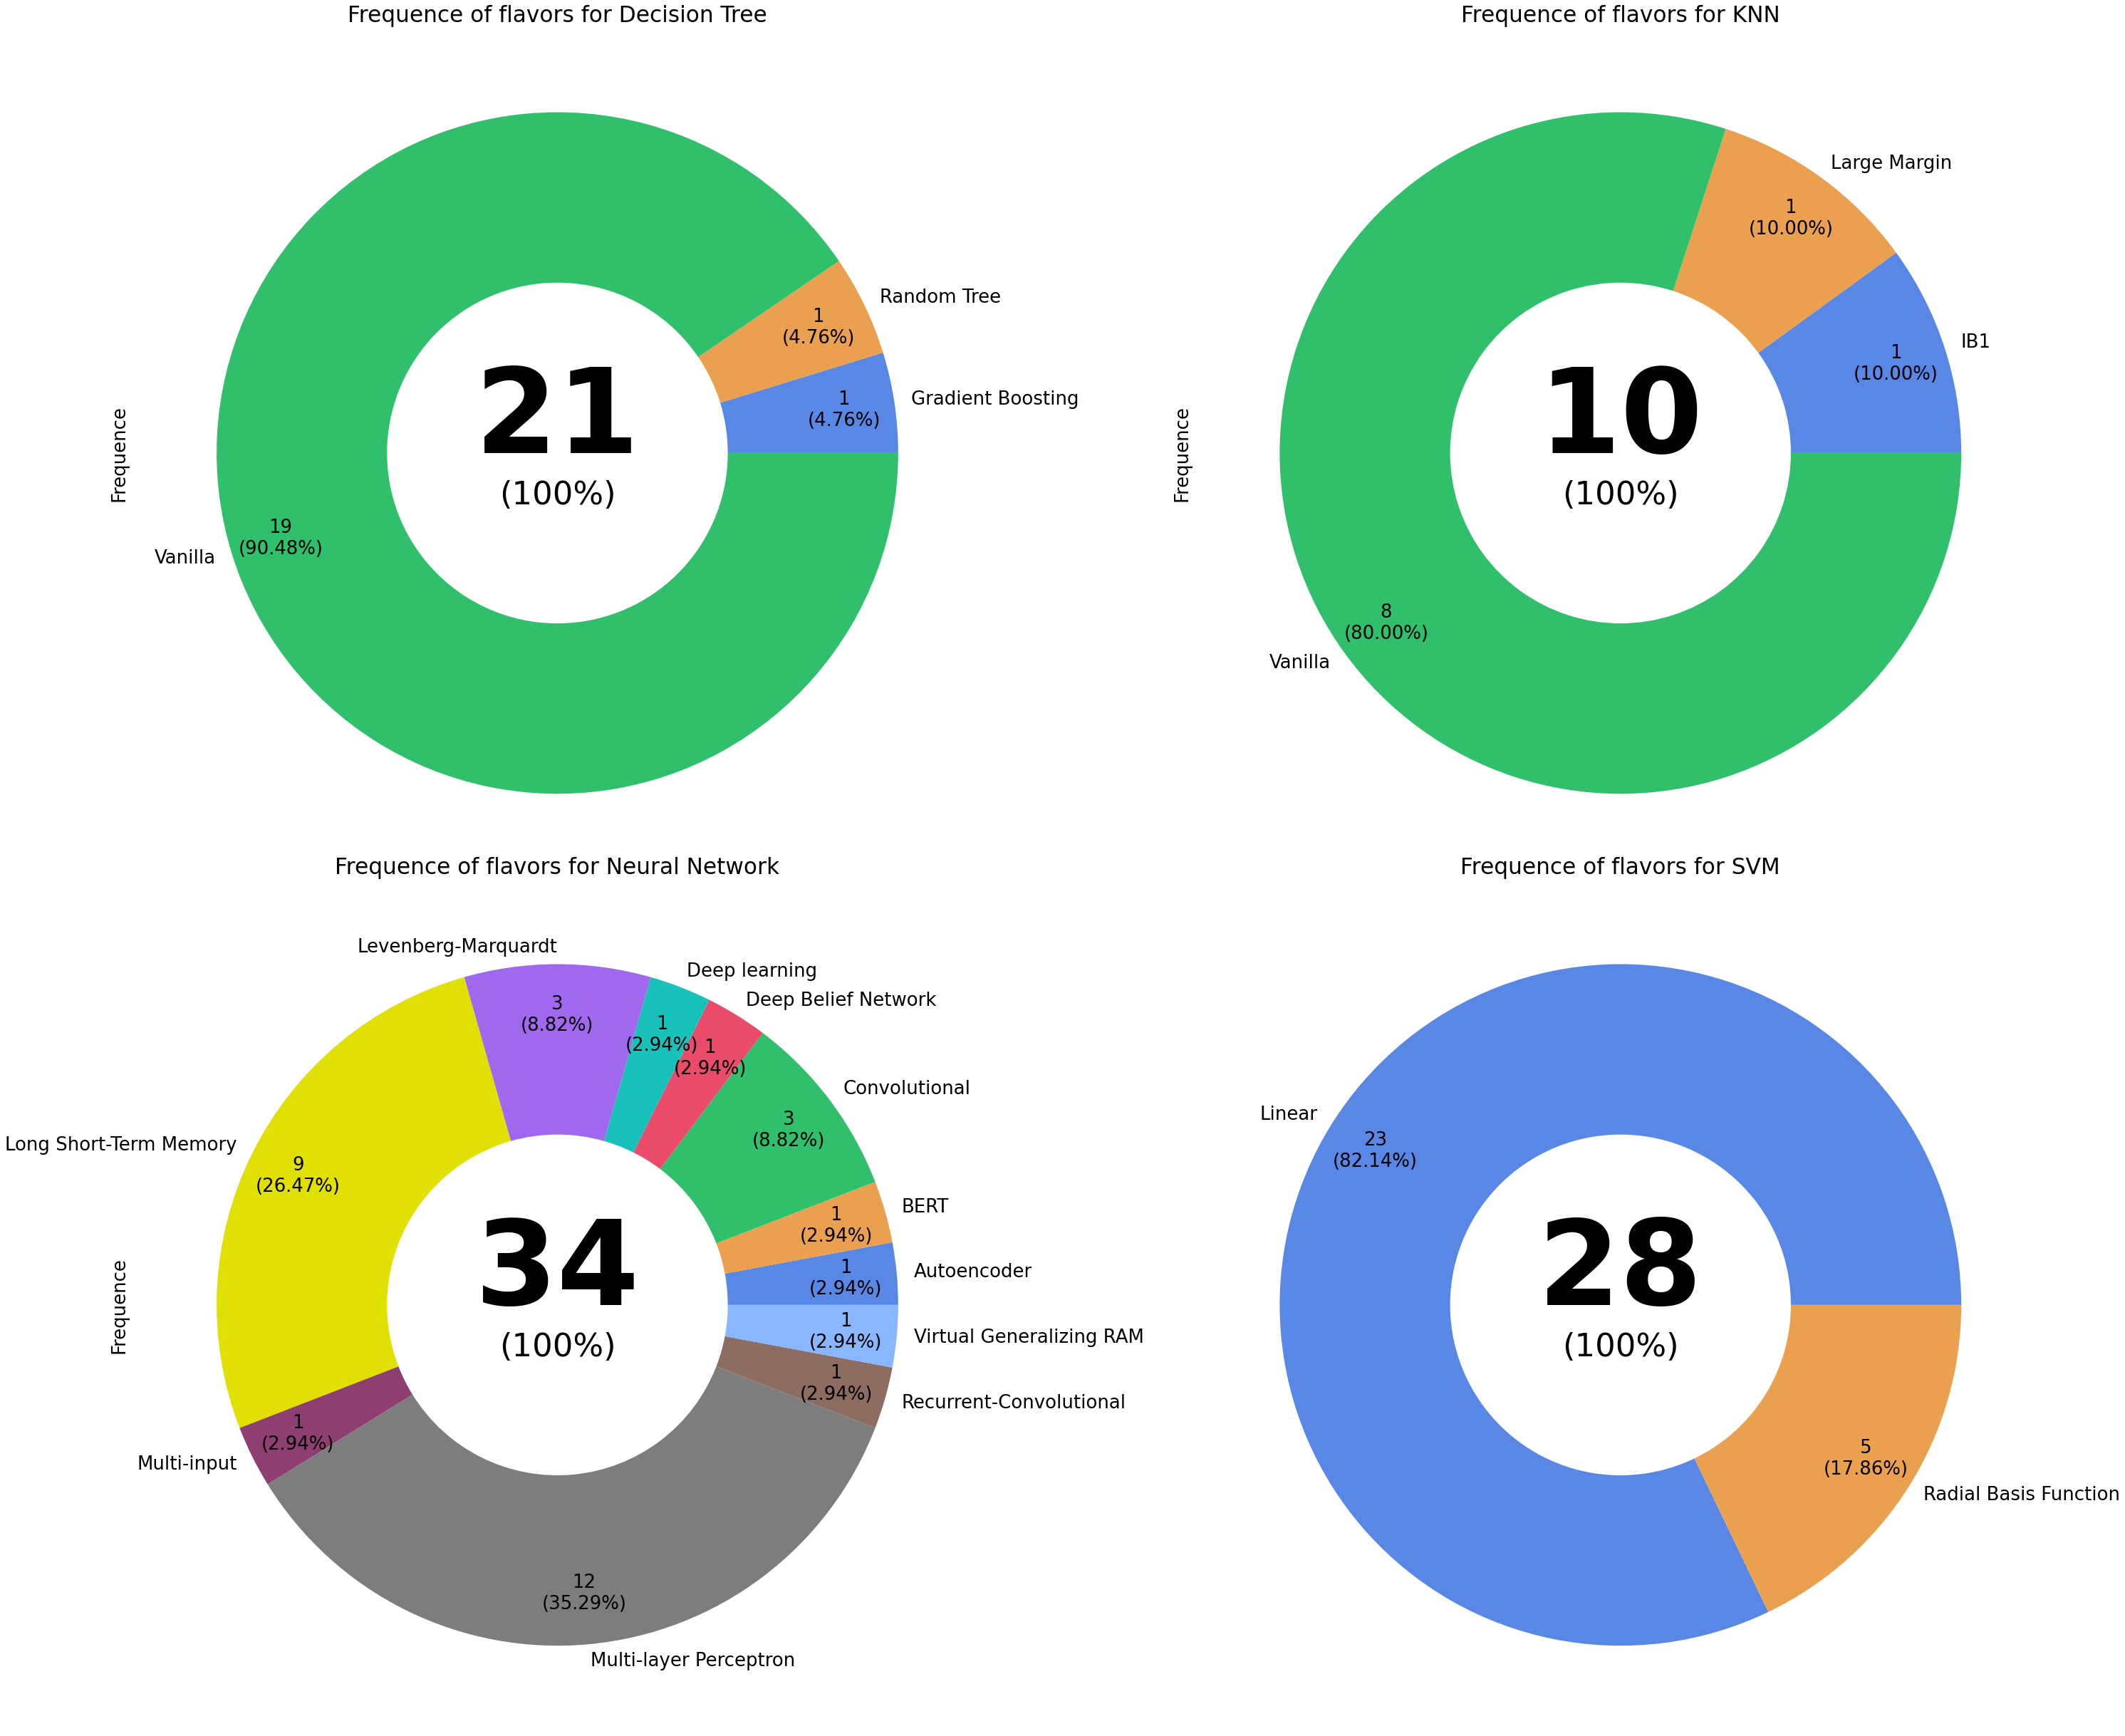

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(50, 44), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1], 'wspace': 0.15, 'hspace': 0.0})
#fig.set_tight_layout(0.08)

index = 0
for technique in top_names:
    if technique == 'Random Forest':
        continue
    flavors_df, all_flavors = helper.technique_flavors_df(metadata, technique)
    utility.donut(pd.DataFrame(flavors_df.loc[:,all_flavors].sum(), columns=['Frequence']), f'Frequence of flavors for {technique}', figsize=(18, 10), ax=ax[index//2][index%2])
    index += 1

#### 5.3. Performances of Machine Learning Techniques
The tables below list the performance of studies according to the technique used (Neural Network, Support Vector Machines, Random Forest, Decision Tree and K-Nearest Neighbor)
and their most frequent variations (flavors).

The *Vanilla* flavor is used When a certain technique is used just as it was originally proposed.

Different flavors and all the performance metrics reported are showed.

##### 5.3.1. Neural Networks

In [22]:
technique = 'Neural Network'
performances_df, all_performances = helper.performances_df(metadata, technique='Neural Network', includes=['year', 'title'])
performances_df[performances_df.columns[2:]].sort_values('Accuracy', ascending=False).style.set_caption(f'<h2>Performances achieved in studies based on <b>{technique}</b></h2>')

In [23]:
measures = ['Accuracy', 'Area Under the Curve', 'F1-score', 'Precision', 'Recall', 'Unweighted Average Recall']
mlp_df = performances_df.loc[performances_df.flavor=='Multi-layer Perceptron', ['year', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
mlp_df.style.set_caption('<h2>Performances achieved in studies based on <b>Multi-layer Perceptron</b></h2>')

In [24]:
mlp_df.loc[:,measures].describe().style.set_caption('<h2>Descriptive statistics of <b>Multi-layer Perceptron</b> performances</h2>')

In [25]:
lstm_df = performances_df.loc[performances_df.flavor=='Long Short-Term Memory', ['year', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
lstm_df.style.set_caption('<h2>Performances achieved in studies based on <b>Long Short-Term Memory</b></h2>')

In [26]:
lstm_df.loc[:, measures].describe().style.set_caption('<h2>Descriptive statistics of <b>Long Short-Term Memory</b> performances</h2>')

In [27]:
ml_df = performances_df.loc[performances_df.flavor=='Levenberg-Marquardt', ['year', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
ml_df.style.set_caption('<h2>Performances achieved in studies based on <b>Levenberg-Marquardt</b></h2>')

In [28]:
ml_df.loc[:, measures].describe().style.set_caption('<h2>Descriptive statistics of <b>Levenberg-Marquardt</b> performances</h2>')

In [29]:
cnn_df = performances_df.loc[performances_df.flavor=='Convolutional', ['year', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
cnn_df.style.set_caption("<h2>Performances achieved in studies based on <b>Convolutional Neural Networks</b></h2>")

In [30]:
cnn_df.loc[:, measures].describe().style.set_caption("<h2>Descriptive statistics of <b>Convolutional Neural Networks</b> performances</h2>")

In [31]:
other_models = ['Autoencoder', 'BERT', 'Deep Belief Network', 'Deep learning', 'Multi-input', 'Recurrent-Convolutional', 'Virtual Generalizing RAM']
ae_df = performances_df.loc[performances_df.flavor.isin(other_models), ['year', 'flavor', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
ae_df.style.set_caption("<h2>Performances achieved in studies based on <b>Other models</b></h2>")

In [32]:
ae_df.loc[:, measures].describe().style.set_caption("<h2>Descriptive statistics of <b>Other models</b> performances</h2>")

##### 5.3.2. Support Vector Machines (SVM)

In [33]:
measures = ['Accuracy', 'Area Under the Curve', 'F1-score', 'Precision', 'Recall']
performances_df, all_performances = helper.performances_df(metadata, technique='SVM', includes=['year', 'title'])
performances_df[performances_df.columns[2:]].style.set_caption("<h2>Performances achieved in studies based on <b>Support Vector Machines</b></h2>")

In [34]:
svm_l_df = performances_df.loc[performances_df.flavor=='Linear', ['year', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
svm_l_df.style.set_caption("<h2>Performances achieved in studies based on <b>Linear SVM</b></h2>")

In [35]:
svm_l_df.loc[:, measures].describe().style.set_caption("<h2>Descriptive statistics of <b>Linear SVM</b> performances</h2>")

In [36]:
svm_rbf_df = performances_df.loc[performances_df.flavor=='Radial Basis Function', ['year', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
svm_rbf_df.style.set_caption("<h2>Performances achieved in studies based on <b>RBF SVM</b></h2>")

In [37]:
svm_rbf_df.loc[:, measures].describe().style.set_caption("<h2>Descriptive statistics of <b>RBF SVM</b> performances</h2>")

##### 5.3.3. Random Forest

In [38]:
technique = 'Random Forest'
measures = ['Accuracy', 'Area Under the Curve', 'F1-score', 'Precision', 'Recall', 'Unweighted Average Recall']
performances_df, all_performances = helper.performances_df(metadata, technique='Random Forest', includes=['year', 'title'])
performances_df[performances_df.columns[3:]].sort_values('Accuracy', ascending=False).style.set_caption(f'<h2>Performances achieved in studies based on <b>{technique}</b></h2>')

In [39]:
performances_df.loc[:, measures].describe().style.set_caption(f'<h2>Descriptive statistics of <b>{technique}</b> performances</h2>')

##### 5.3.4. Decision Tree

In [40]:
measures = ['Accuracy', 'Area Under the Curve', 'F1-score', 'Precision', 'Recall', 'Unweighted Average Recall']
performances_df, all_performances = helper.performances_df(metadata, technique='Decision Tree', includes=['year', 'title'])
performances_df[performances_df.columns[2:]].sort_values('Accuracy', ascending=False).style.set_caption("<h2>Performances achieved in studies based on <b>Decision Tree</b></h2>")

In [41]:
dt_df = performances_df.loc[performances_df.flavor=='Vanilla', ['year', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
dt_df.style.set_caption("<h2>Performances achieved in studies based on <b>Vanilla Decision Tree</b></h2>")

In [42]:
dt_df.loc[:, measures].describe().style.set_caption("<h2>Descriptive statistics of <b>Vanilla Decision Tree</b> performances</h2>")

##### 5.3.5. K-Nearest Neighbor (KNN)

In [43]:
measures = ['Accuracy', 'Area Under the Curve', 'F1-score', 'Precision', 'Recall', 'Unweighted Average Recall']
performances_df, all_performances = helper.performances_df(metadata, technique='KNN', includes=['year', 'title'])
performances_df[performances_df.columns[2:]].sort_values('Accuracy', ascending=False).style.set_caption("<h2>Performances achieved in studies based on <b>K-Nearest Neighbor</b></h2>")

In [44]:
knn_df = performances_df.loc[performances_df.flavor=='Vanilla', ['year', 'title']+measures].head(100).sort_values('Accuracy', ascending=False)
knn_df.style.set_caption("<h2>Performances achieved in studies based on <b>Vanilla KNN</b></h2>")

In [45]:
knn_df.loc[:, measures].describe().style.set_caption("<h2>Descriptive statistics of <b>Vanilla K-Nearest Neighbor</b> performances</h2>")

### 6. Support tool analysis
Authors reported the use of many different tools used to run many kinds of processing on data. In this section we present charts that show which tools were
used and how frequent.

The next charts present some findings about the supporting tools used by the studies in the selected corpus.

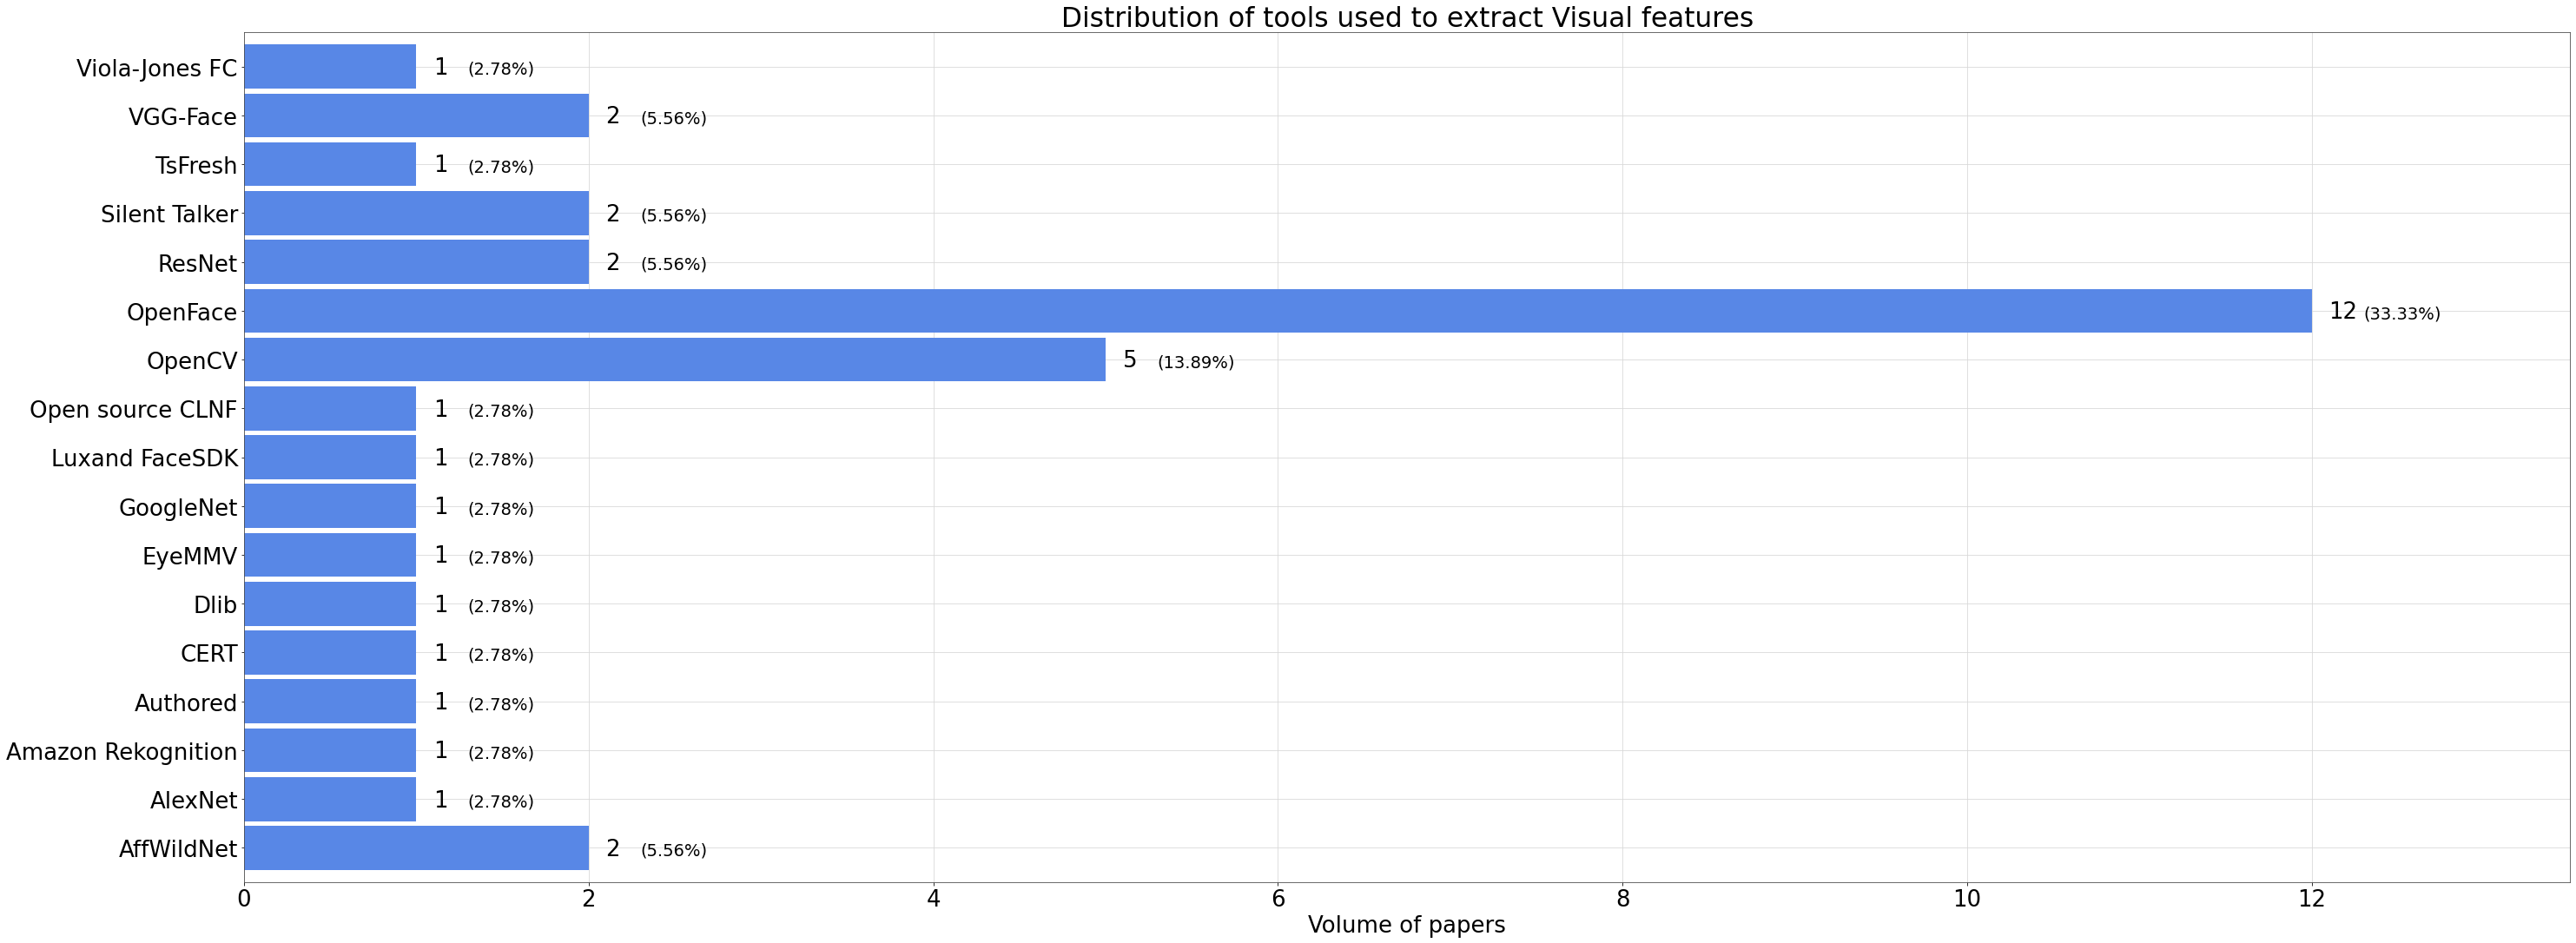

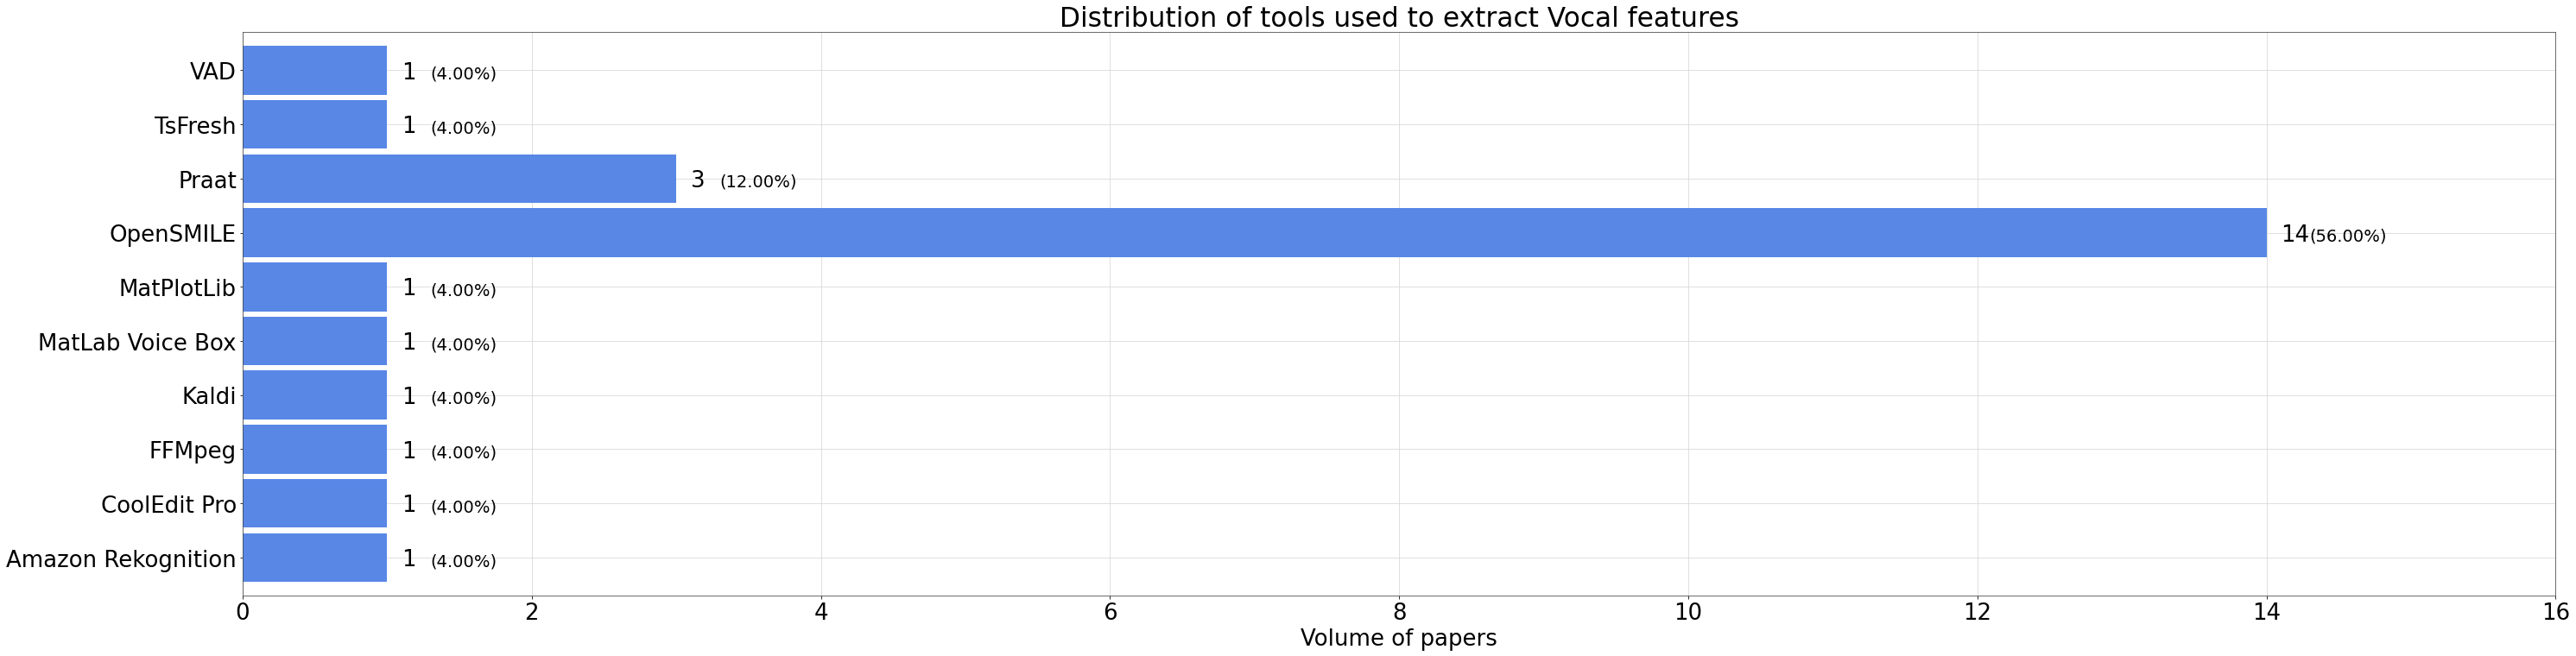

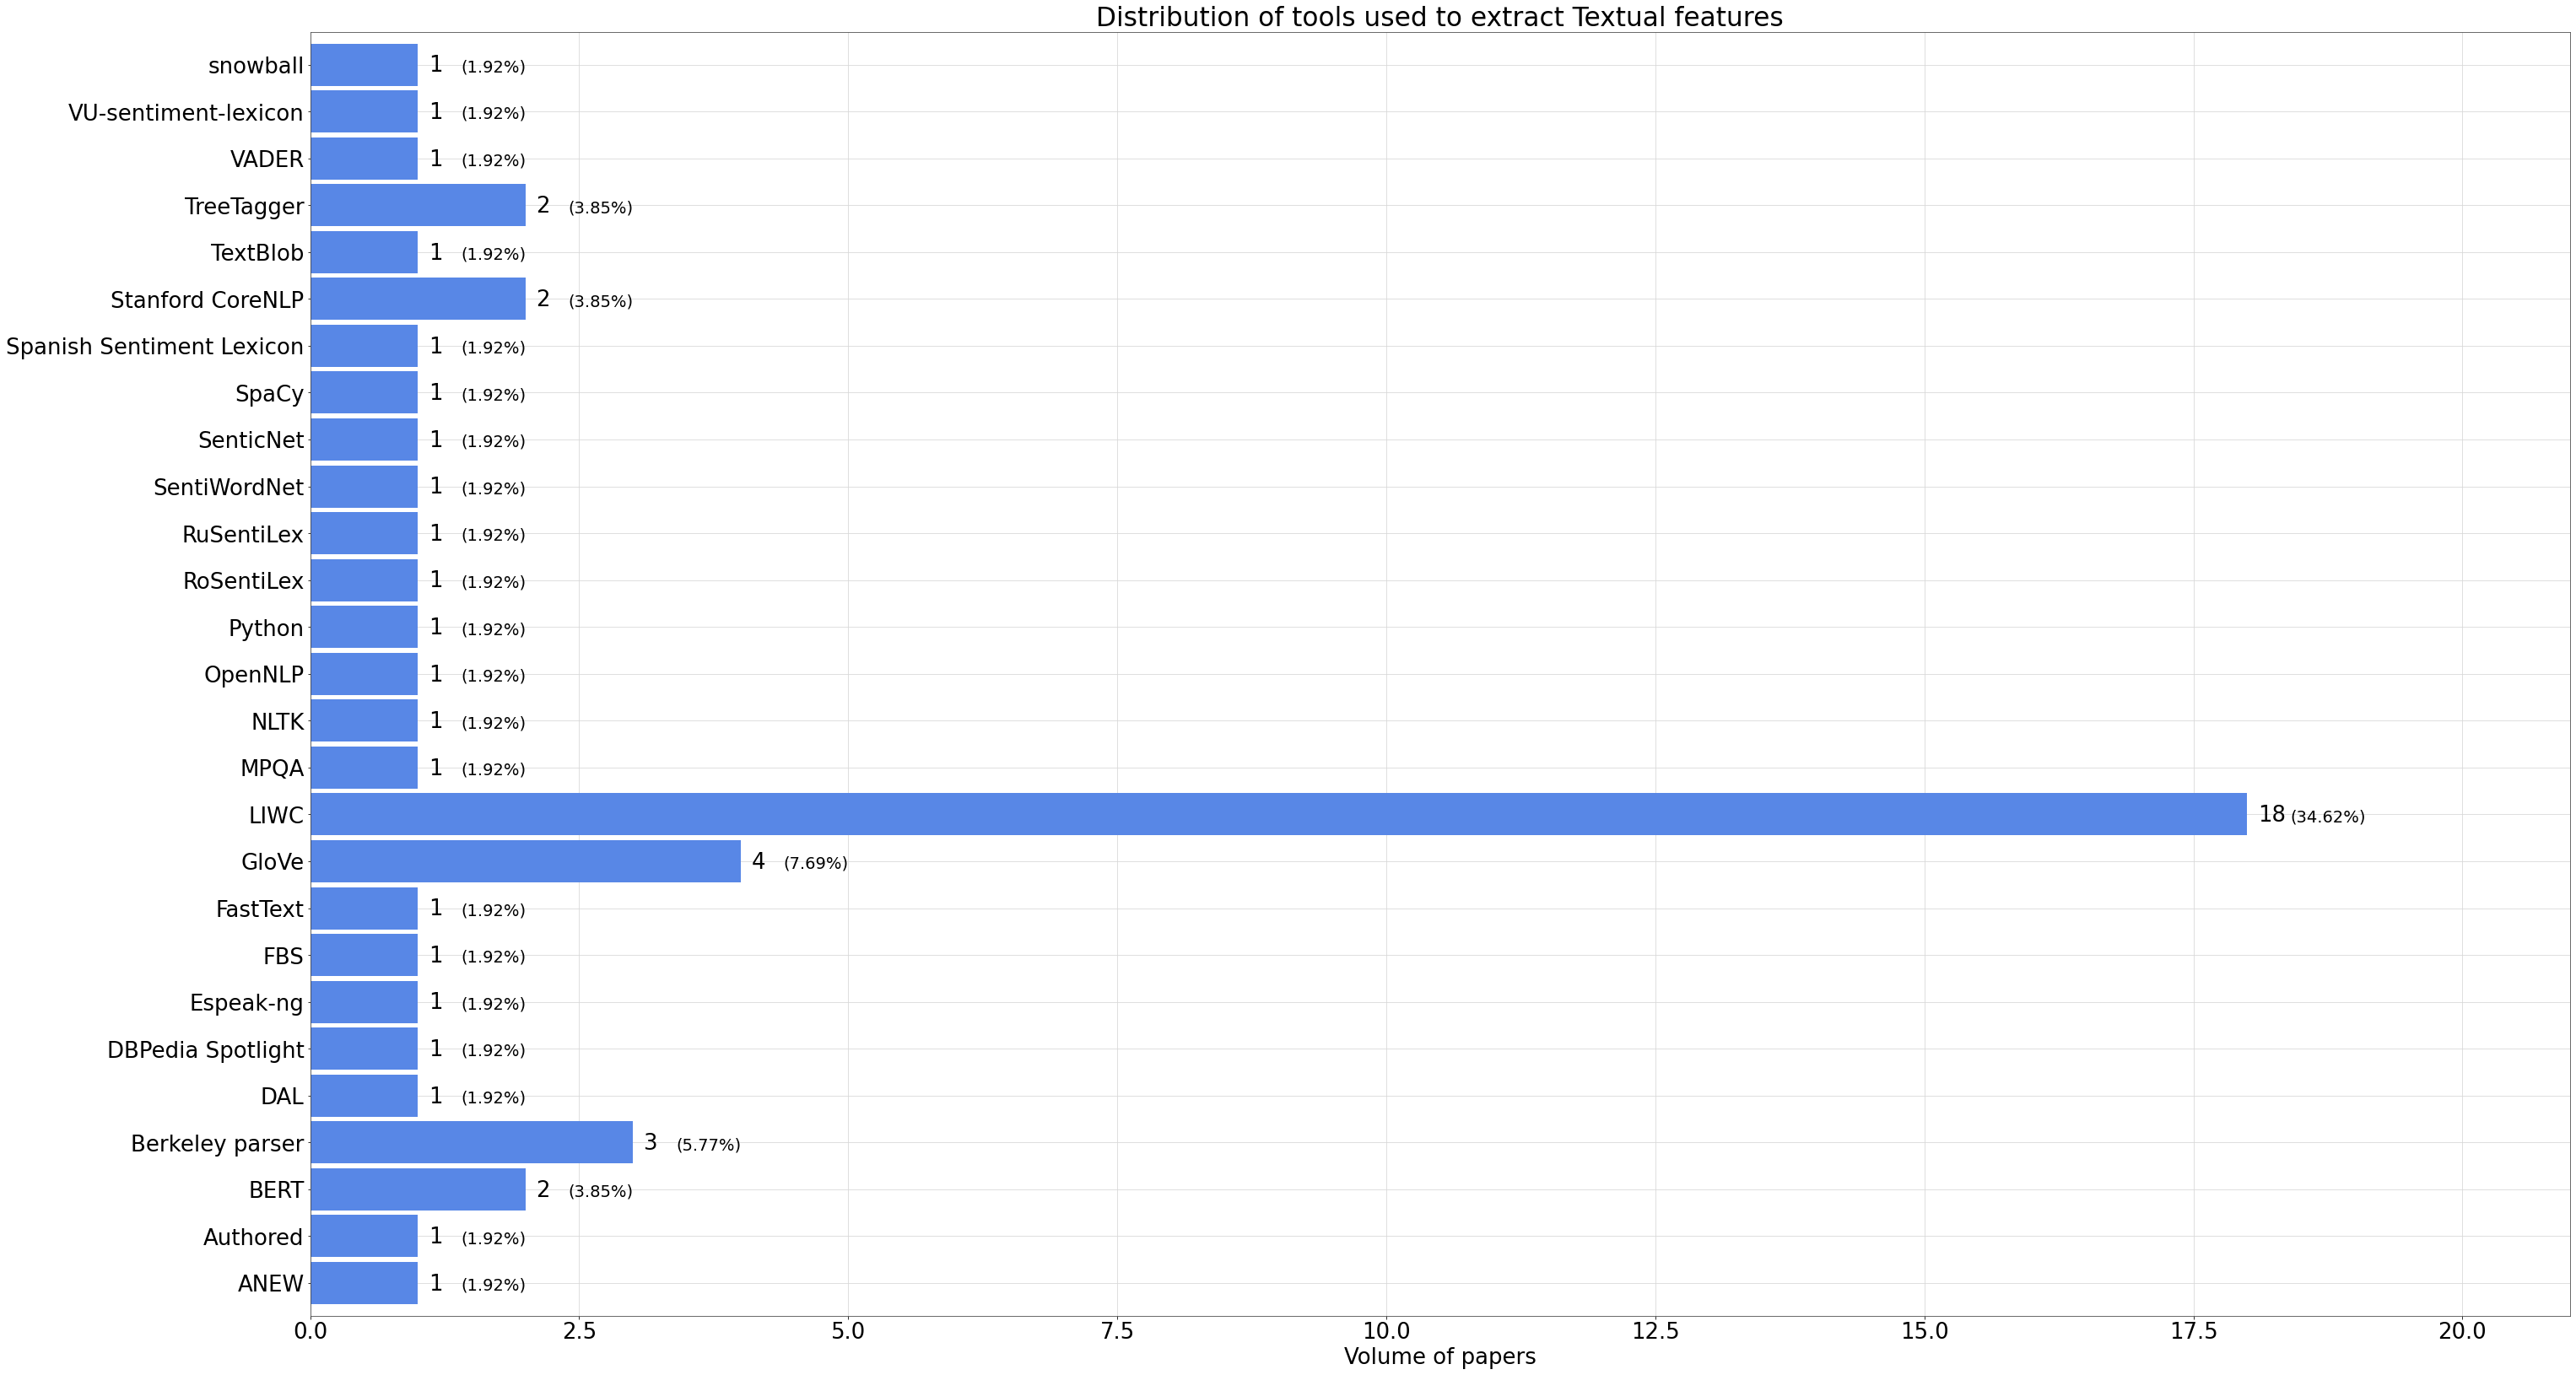

In [46]:
for modality_kind, fig_size, xlim, xpercoffset in [('Visual',(48,18),13.5,0.2), ('Vocal',(48,12),16,0.2), ('Textual',(48,28),21,0.3),]:
    tools_docs = [{
        #'document_id': r['document_id'],
        'tools': [f['tool'] for f in md['dataset']['features'] if 'tool' in f and f['kind']==modality_kind],
        }
        for md in metadata]
    tools_docs = [t for t in tools_docs if len(t['tools']) > 0]
    for tools_doc in tools_docs:
        if len(tools_doc['tools']) > 0:
            tools_doc['tools'] = tools_doc['tools'][0]
    #print(tools_docs)
    all_tools_kind = sorted(list(set(reduce(lambda x,y: x+y, [d['tools'] for d in tools_docs]))))
    #print(all_tools_kind)
    tools_kind_df = pd.DataFrame(tools_docs)
    for tool_kind in all_tools_kind:
        tools_kind_df[tool_kind] = tools_kind_df.tools.apply(lambda x: 1 if tool_kind in x else 0)
    tools_kind_df.drop(columns='tools', inplace=True)
    tools_kind_df = pd.DataFrame(tools_kind_df.sum())
    #tools_kind_df
    tools_kind_df.columns = ['Volume']
    #tools_kind_df.sort_values(['Volume'], inplace=True)
    utility.barh(tools_kind_df, title=f'Distribution of tools used to extract {modality_kind} features',
                 xlabel='Volume of papers', figsize=fig_size, total=tools_kind_df.Volume.sum(), xlim=xlim, x_offset_perc=xpercoffset)

In [47]:
temp_metadata = [{
    'document_id': md['document_id'],
    'tools': sorted(list(set([m['support'] for m in md['methods'] if 'support' in m] +
                             [m['implementation'] for m in md['methods'] if 'implementation' in m and m['implementation'] is not None]))),
    }
    for md in metadata]
tools_df = pd.DataFrame(temp_metadata)
tools_df['Year'] = tools_df.document_id.apply(lambda id: document_by_id[id].year)
all_tools = sorted(list(set(reduce(lambda x,y: x+y, tools_df.tools.values))))
#tools_df

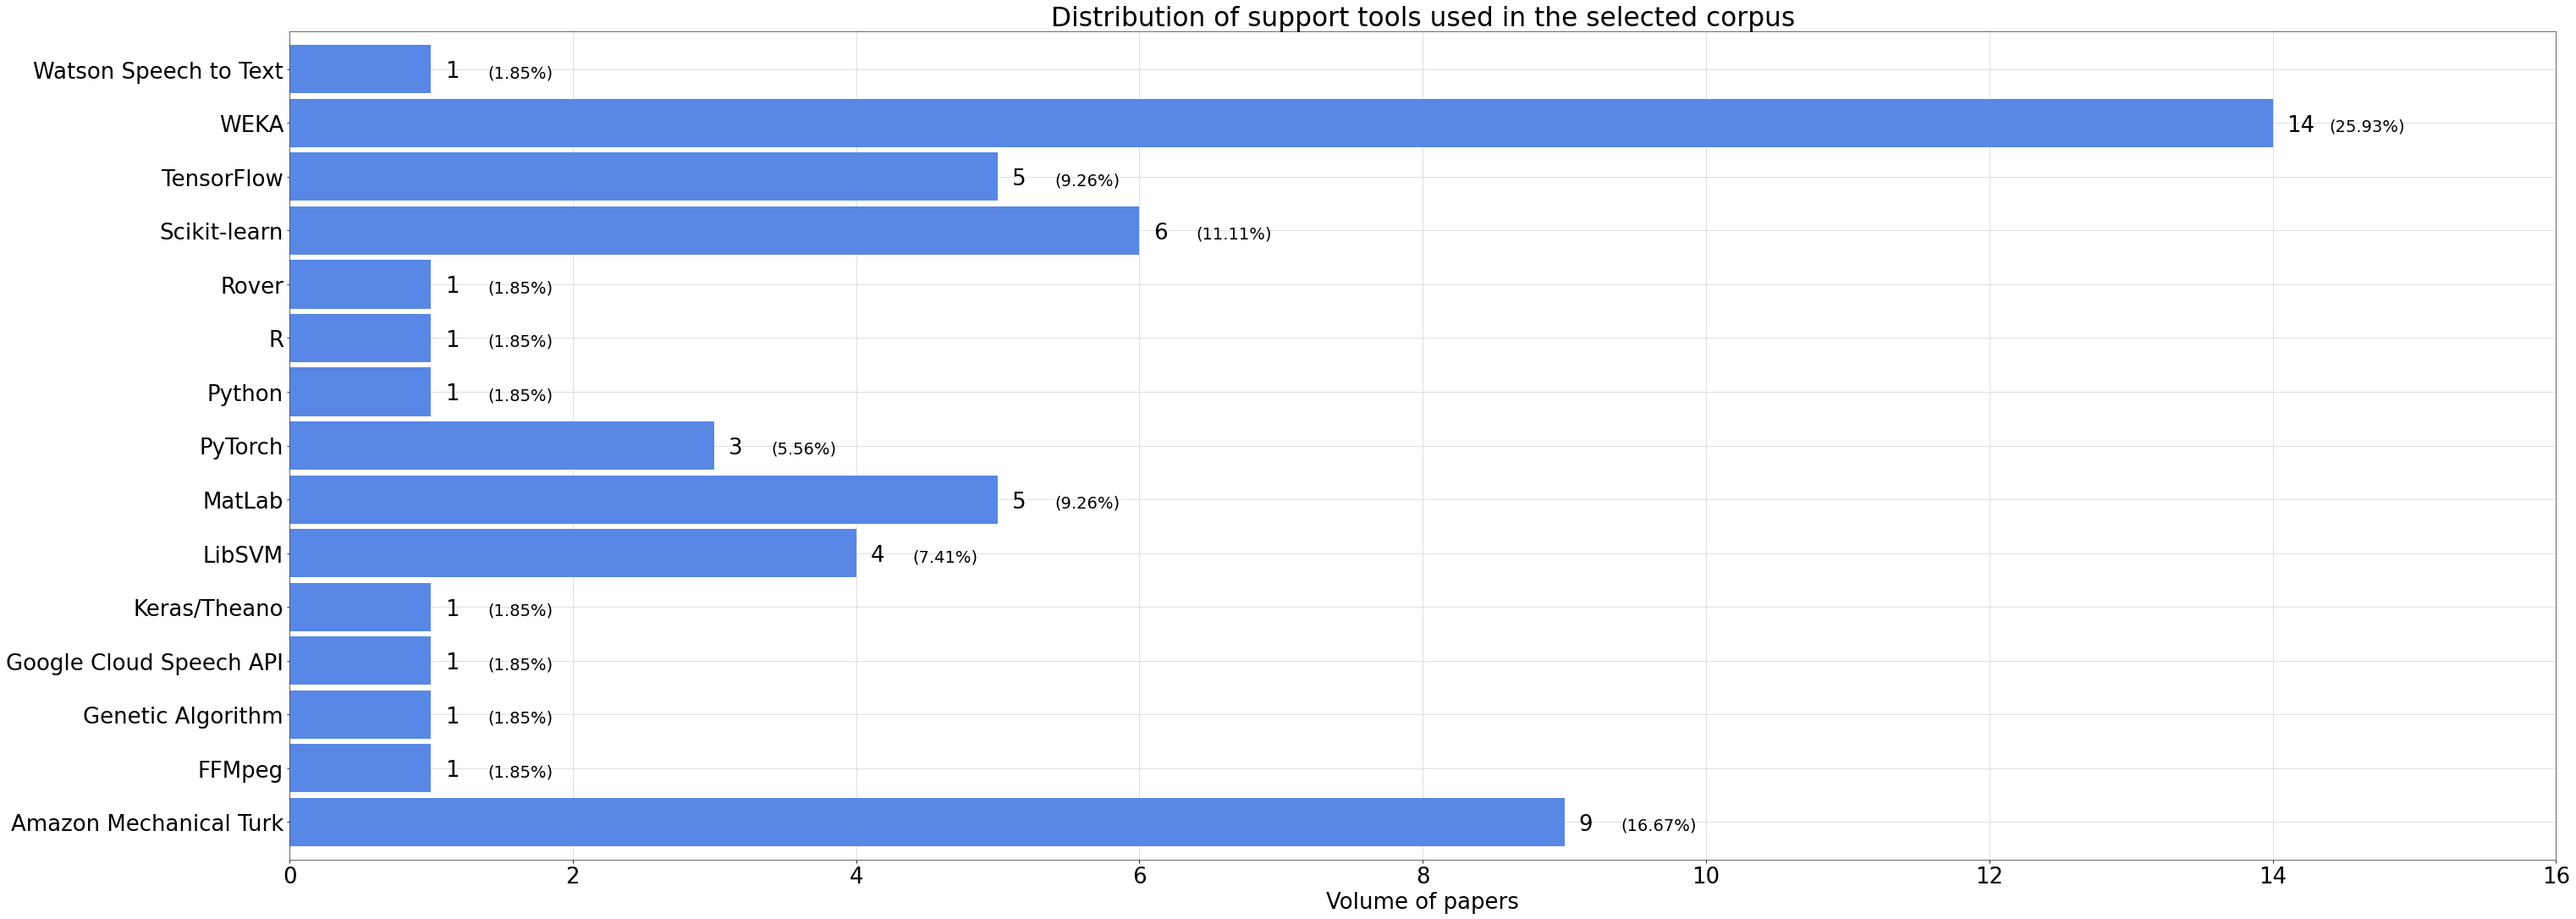

In [48]:
tools_sum_df = tools_df.loc[:,['tools']]
for tool in all_tools:
    tools_sum_df[tool] = tools_sum_df.tools.apply(lambda tools: 1 if tool in tools else 0)
tools_sum_df.drop(columns=['tools'], inplace=True)
tools_sum_df = pd.DataFrame(tools_sum_df.sum(axis=0))
tools_sum_df.columns = ['Volume']
#tools_sum_df.sort_values(['Volume'], inplace=True)
#tools_sum_df.head(100)
utility.barh(tools_sum_df, title='Distribution of support tools used in the selected corpus',
             xlabel='Volume of papers', figsize=(48,18), total=tools_sum_df.Volume.sum(), xlim=16, x_offset_perc=0.3)

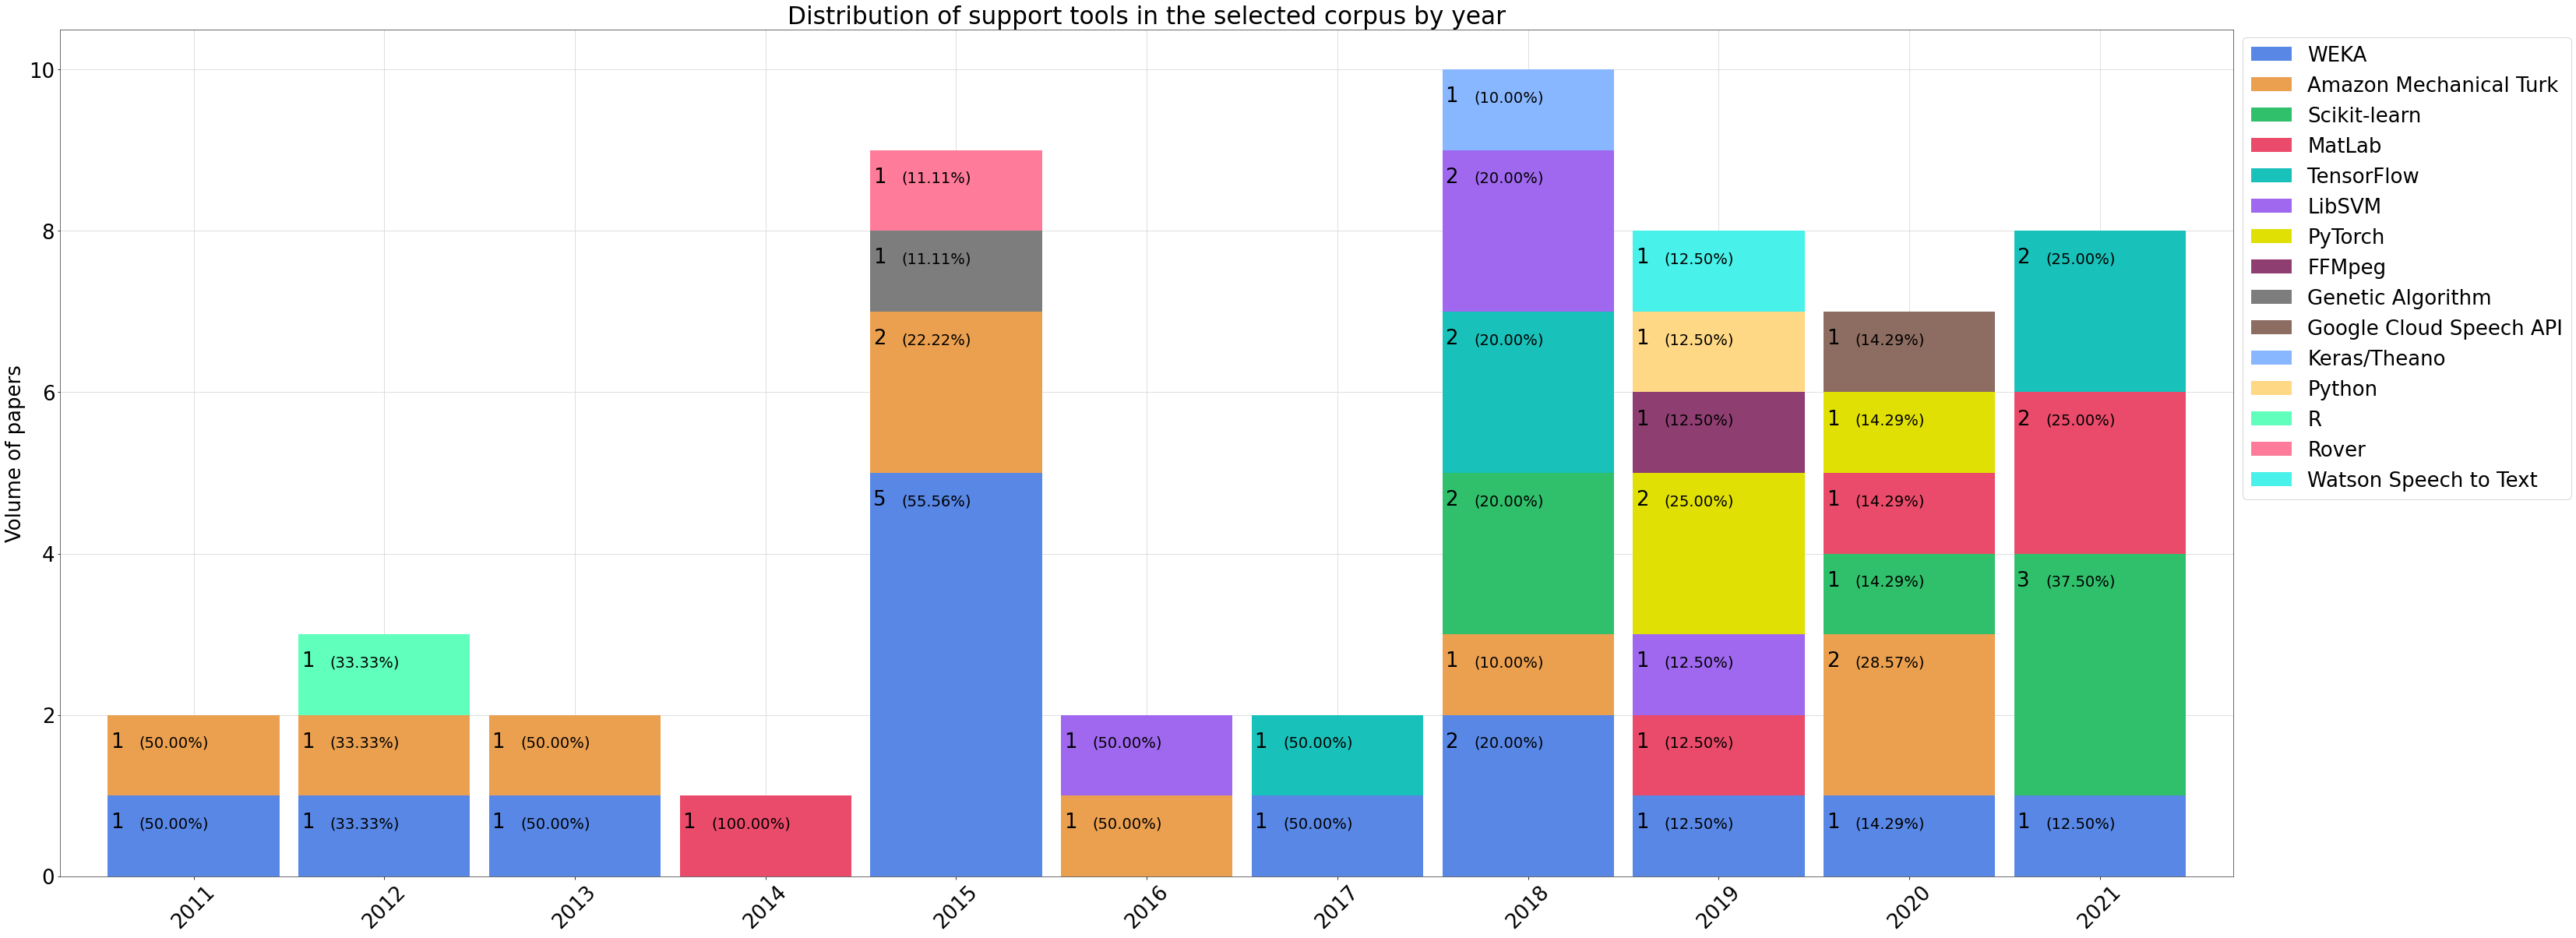

In [49]:
tools_year_df = tools_df.loc[:,['Year', 'tools']]
for tool in tools_sum_df.sort_values(['Volume'], ascending=False).index.values:
    tools_year_df[tool] = tools_year_df.tools.apply(lambda tools: 1 if tool in tools else 0)
tools_year_df.drop(columns=['tools'], inplace=True)
tools_year_df = tools_year_df.groupby('Year').agg(sum)
#tools_year_df.head(100)
utility.bar_stacked(tools_year_df, title='Distribution of support tools in the selected corpus by year',
                    ylabel='Volume of papers', figsize=(50, 20), bbox_to_anchor=(1.16, 1.0025), y_offset=0.4)

### 7. Dataset analysis
In this section we gather data extracted about datasets exploited in each selected study and present some analysis. What we seek here is
to give a perception of what data were consumed to train models, which ones are available for future research, what data nature is stored
in those datasets and how many times they were used in different papers.

At the end we present a dataset benchmark table that is intended to summarize all we could collect about the dataset used for research
on Deception Detection.

#### 7.1. Metadata retrieval and organization

In [50]:
temp_metadata = [{
    'document_id': md['document_id'],
    'datasets': md['dataset'],
    'modalities': [(f['kind'], f['components']) for f in md['dataset']['features']],
    }
    for md in metadata]
datasets_df = pd.DataFrame(temp_metadata)
datasets_df['Name'] = datasets_df.datasets.apply(lambda x: x['name'] if x['name'] is not None else "Author's collected data")
datasets_df['Source'] = datasets_df.datasets.apply(lambda x: x['origin'])
datasets_df['Public'] = datasets_df.datasets.apply(lambda x: 1 if x['public'] else 0)
datasets_df['Private'] = datasets_df.datasets.apply(lambda x: 0 if x['public'] else 1)
datasets_df['Mock'] = datasets_df.datasets.apply(lambda x: 1 if x['mock'] else 0)
datasets_df['Real-life'] = datasets_df.datasets.apply(lambda x: 0 if x['mock'] else 1)
datasets_df['Cardinality'] = datasets_df.datasets.apply(lambda x: x['size'])
datasets_df['Modality_count'] = study_df.modalities.apply(lambda value: len(value))
datasets_df['Modality_cardinality'] = study_df.Modality_count.apply(lambda value: 'Monomodal' if value==1 else 'Bimodal' if value==2 else 'Multimodal')
datasets_df['Modality_combination'] = study_df.modalities.apply(lambda value: '+'.join(sorted(list(set([m[0] for m in value])))))
datasets_df['Features'] = study_df.modalities.apply(lambda value: ', '.join(sorted(reduce(lambda x,y: x+y, [m[1] for m in value]))))
datasets_df['Origin'] = datasets_df.datasets.apply(lambda x: x['origin'])
datasets_df['year'] = datasets_df.document_id.apply(lambda id: document_by_id[id].year)
datasets_df.drop(columns=['datasets', 'modalities'], inplace=True)
all_datasets = sorted(list(set(datasets_df.Name.values)))
#print(all_datasets)
#datasets_df

#### 7.2. Dataset origin analysis
Due to data scarcity on Deception Detection, many authors reported that they had to devise a data collection strategy. In such cases those
datasets are named as "Author's collected dataset". The data existing in those datasets are labeled as "Mock" because the
settings elaborated tried to create a circumstance where participants would be encouraged to lie so the desired features could be
collected.

On the other hand, some authors produced or consumed datasets created from real-life situations, which means, datasets composed by features
of people that were, supposedly, lying expontaneously. Those data are labeled "Real-life".

The next charts present a study on the volume of those two kinds of data origin and their distribution along the period of interest.

The conclusion is that Mock data is still the majority, but there is an increasing and persistent tendency to exploit Real-life data.

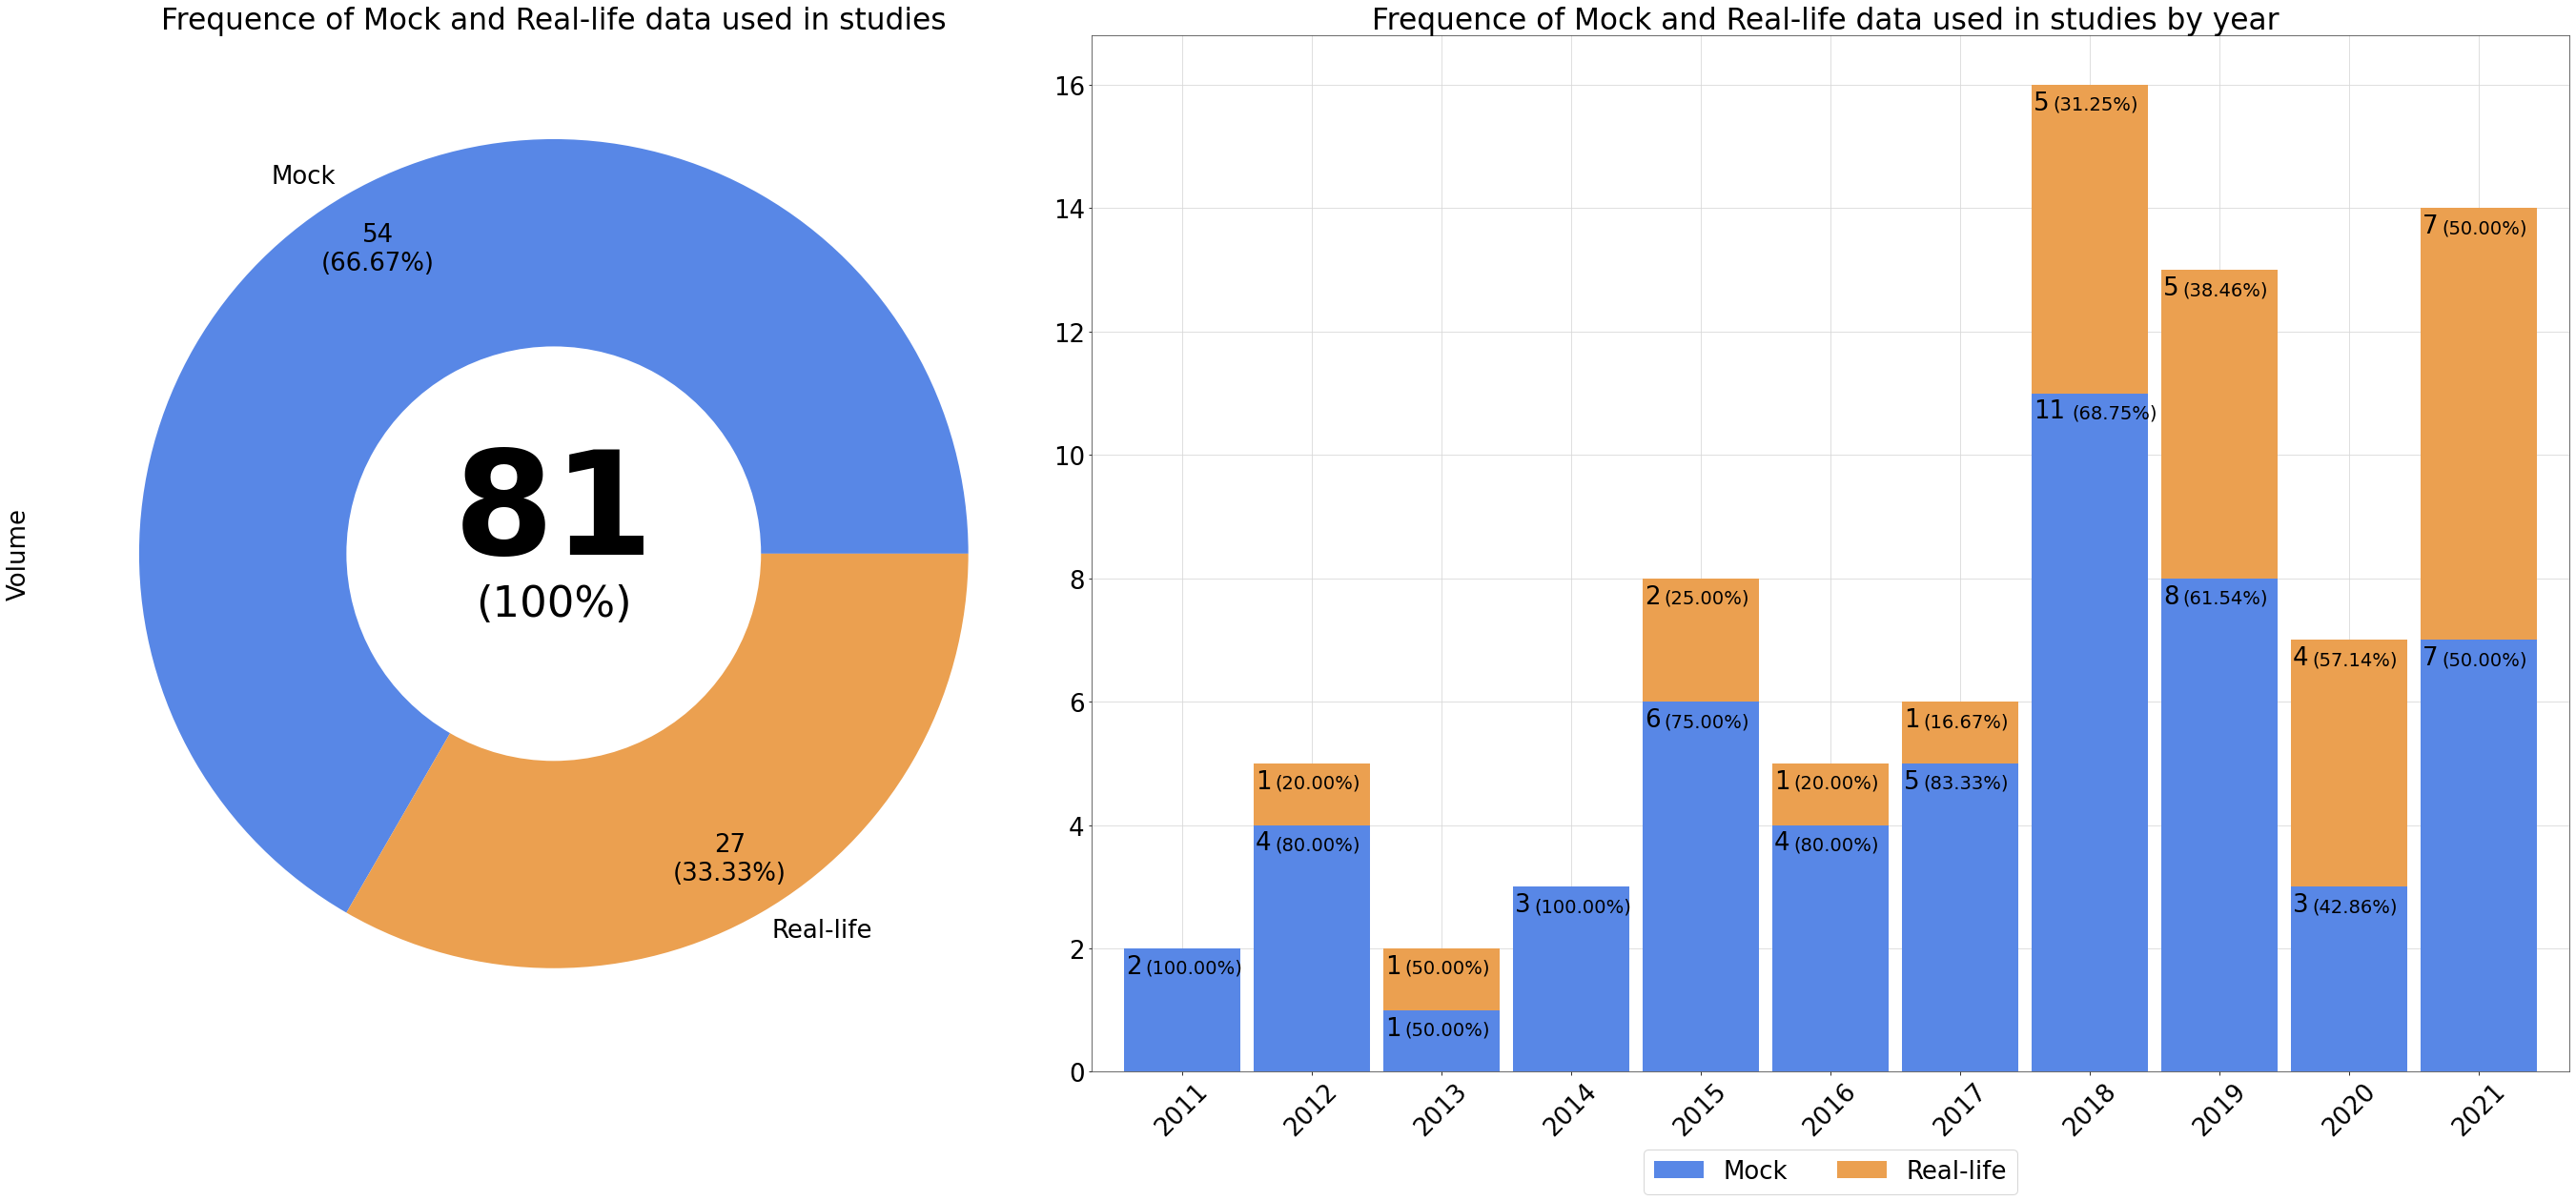

In [51]:
datasets_mock_df = datasets_df.loc[:, ['year', 'Mock', 'Real-life']]
#datasets_mock_df.head(75)
helper.view(1, 2, size=(48,20)).layout(w_ratio=[4,5.5], w_space=0)\
      .params(1, 1)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.13), y_offset=0.4)\
      .plot_summary(datasets_mock_df, ['Mock', 'Real-life'], 'Frequence of Mock and Real-life data used in studies')

#### 7.3. Dataset access
Not all datasets collected in studies were made available to community access.

The next charts present a study on public availability of datasets, their distribution along the period of interest,
and their use by different papers.

The conclusion is that open access datasets are still the minority, but there is an increasing and persistent
tendency to adopt those datasets. However, there is a strong recurrence of the Real-life Deception Detection Dataset.

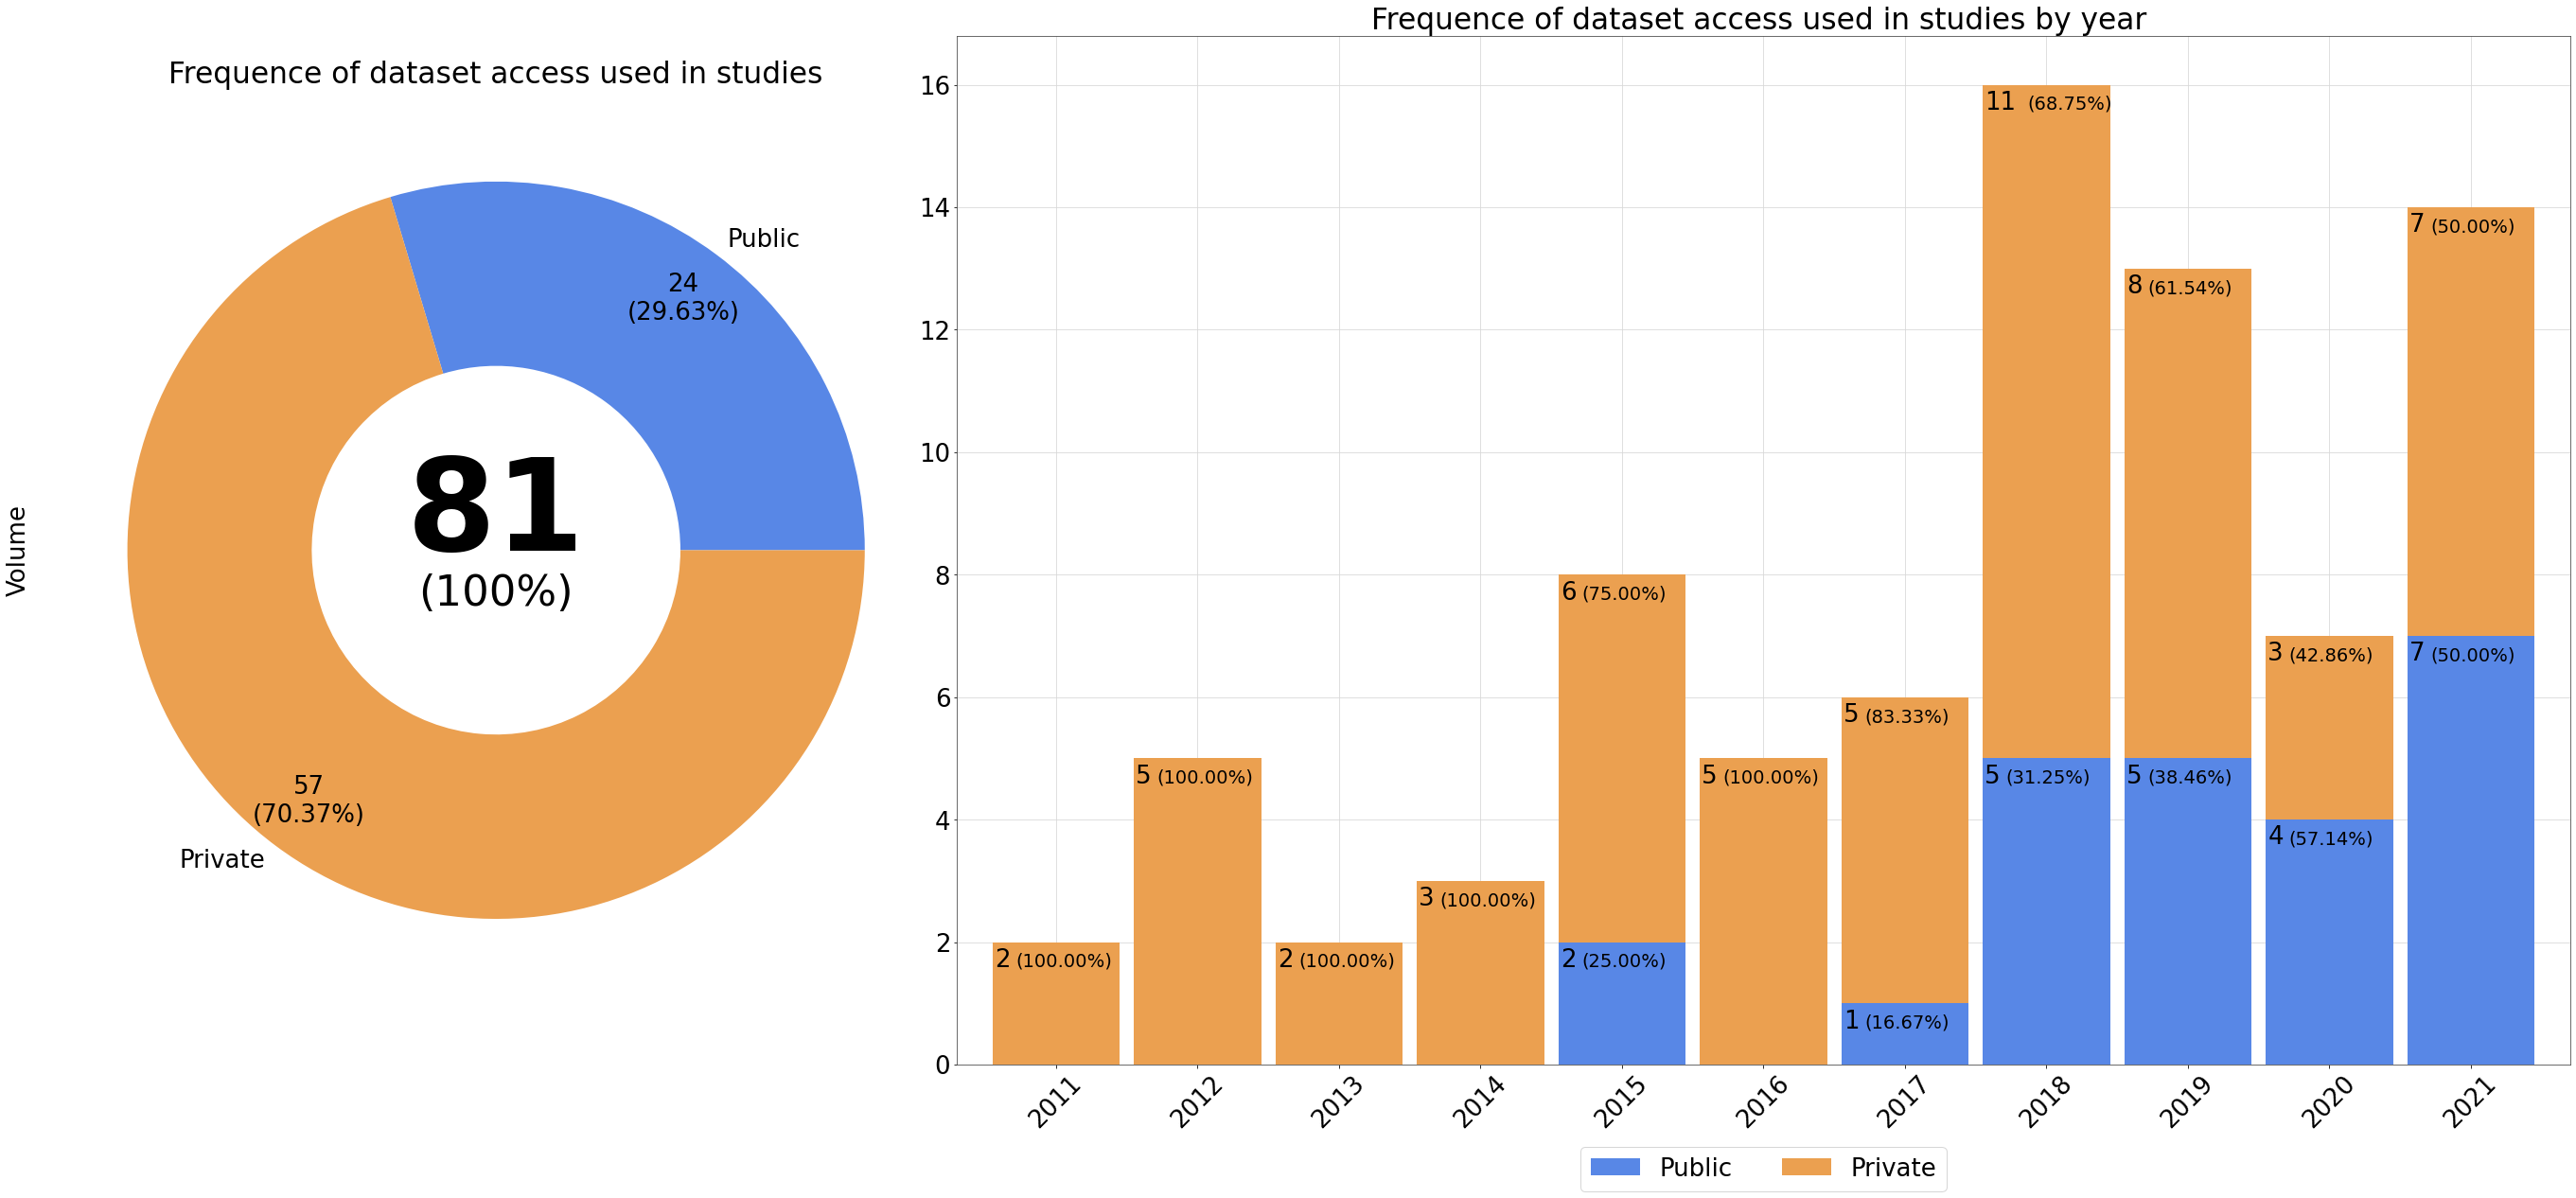

In [52]:
datasets_public_df = datasets_df.loc[:, ['year', 'Public', 'Private']]
#datasets_public_df.columns = ['Volume of papers']
datasets_public_df.head(75)
helper.view(1, 2, size=(48,20)).layout(w_ratio=[4,7], w_space=0)\
      .params(1, 1)\
      .params(1, 2, v_legends=False, legend_cols=5, legend_anchor=(0.5,-0.135), y_offset=0.4)\
      .plot_summary(datasets_public_df, ['Public', 'Private'], 'Frequence of dataset access used in studies')

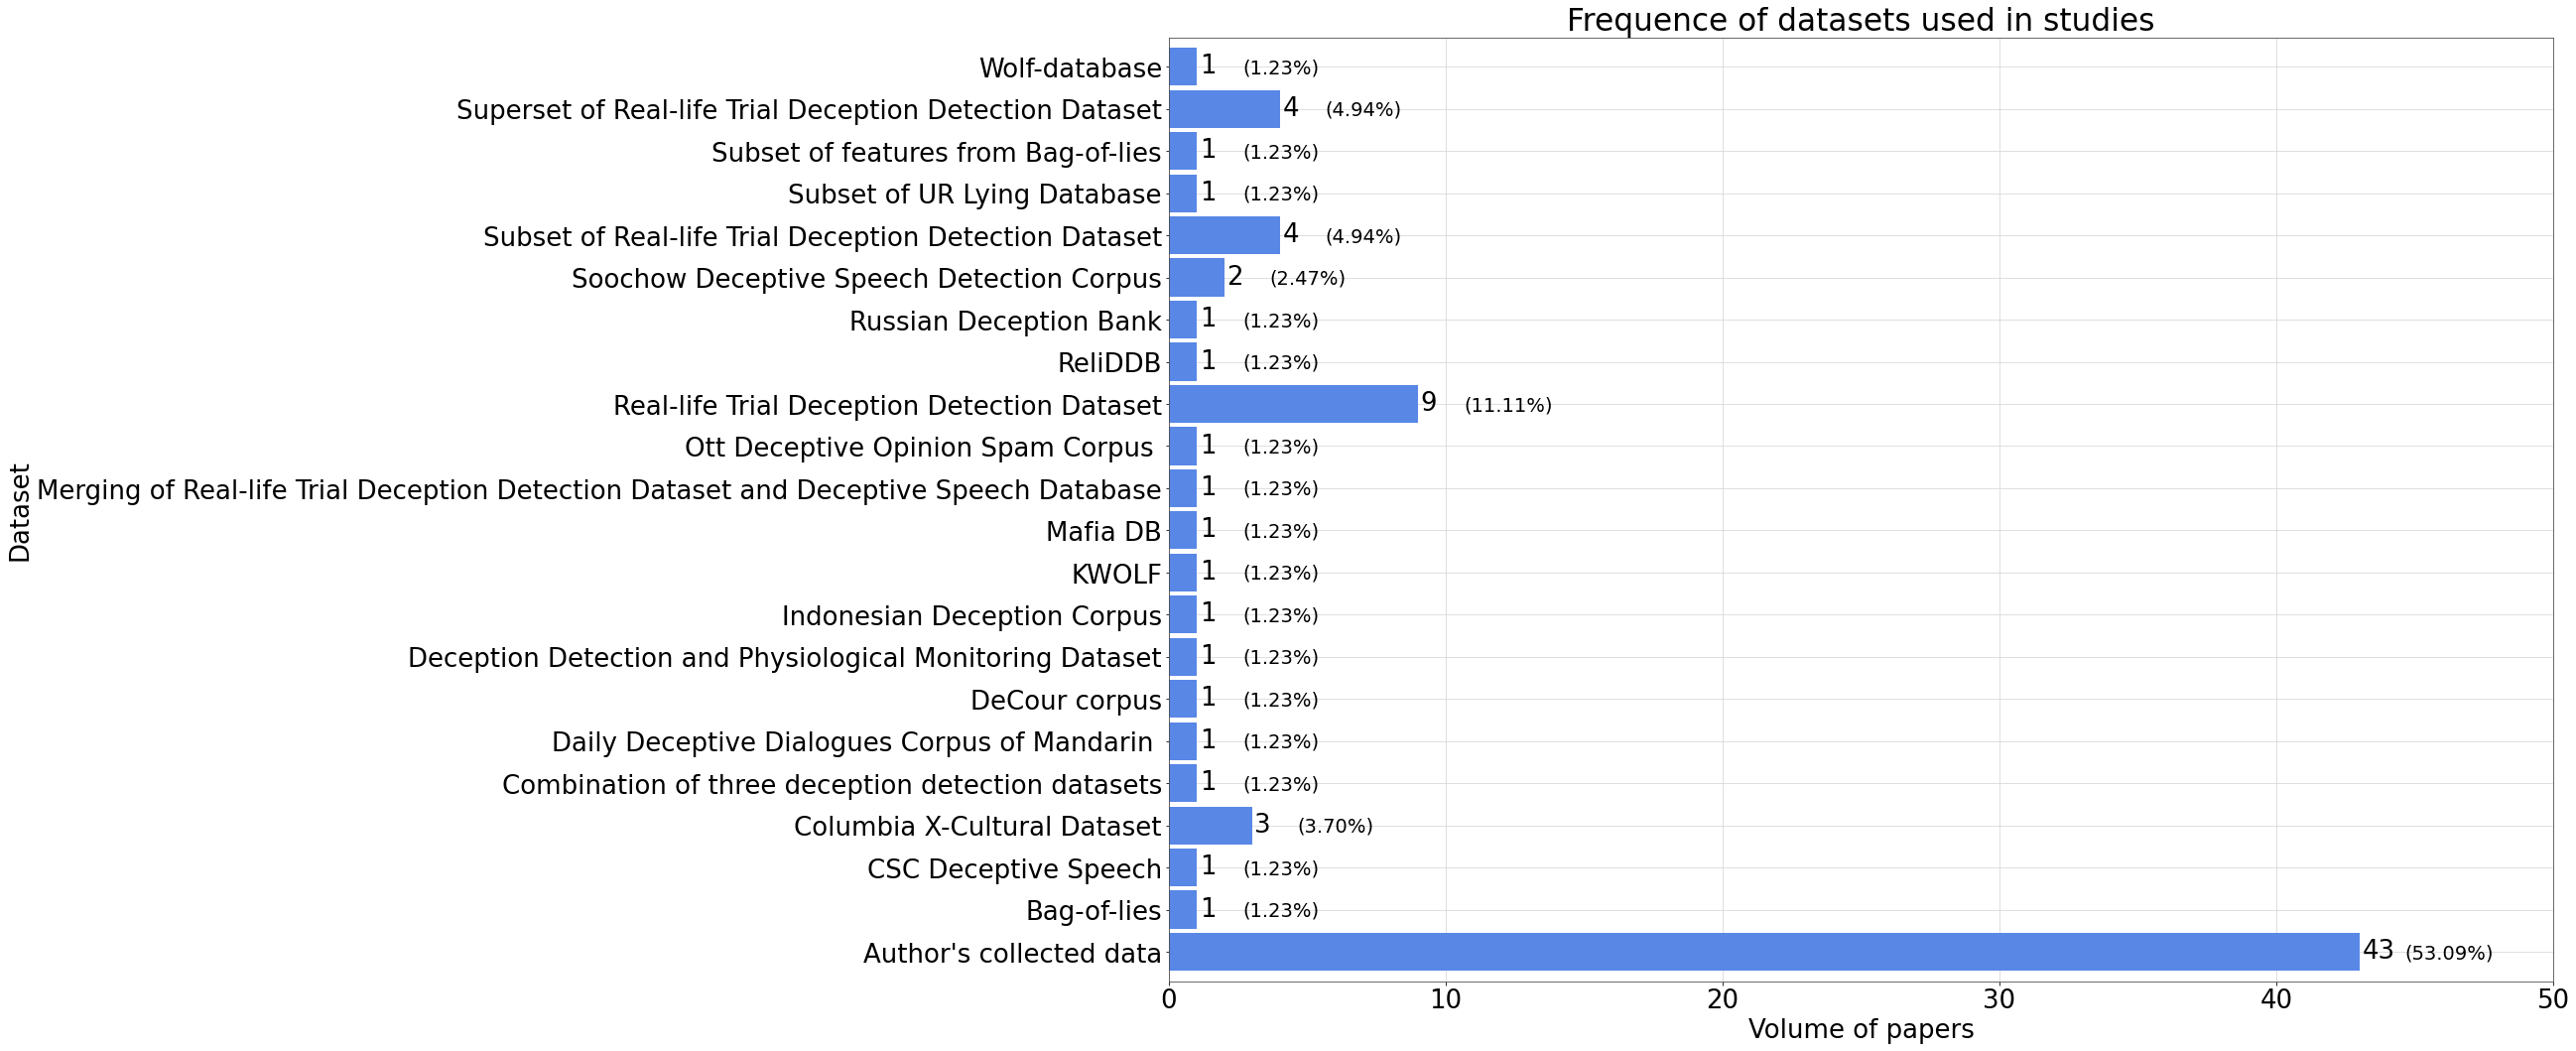

In [53]:
datasets_name_df = datasets_df.loc[:,['Name']]
datasets_name_df['Use in papers'] = datasets_name_df.Name.apply(lambda x: 1)
datasets_name_df = datasets_name_df.groupby('Name').agg(sum)
datasets_name_df.columns = ['Volume']
#datasets_name_df.sort_values(['Volume'], inplace=True)
#datasets_name_df.head(100)
utility.barh(datasets_name_df, title='Frequence of datasets used in studies',
             xlabel='Volume of papers', ylabel='Dataset', total=datasets_name_df.Volume.sum(),
             figsize=(25,17.5), xlim=50, x_offset_perc=1.55)

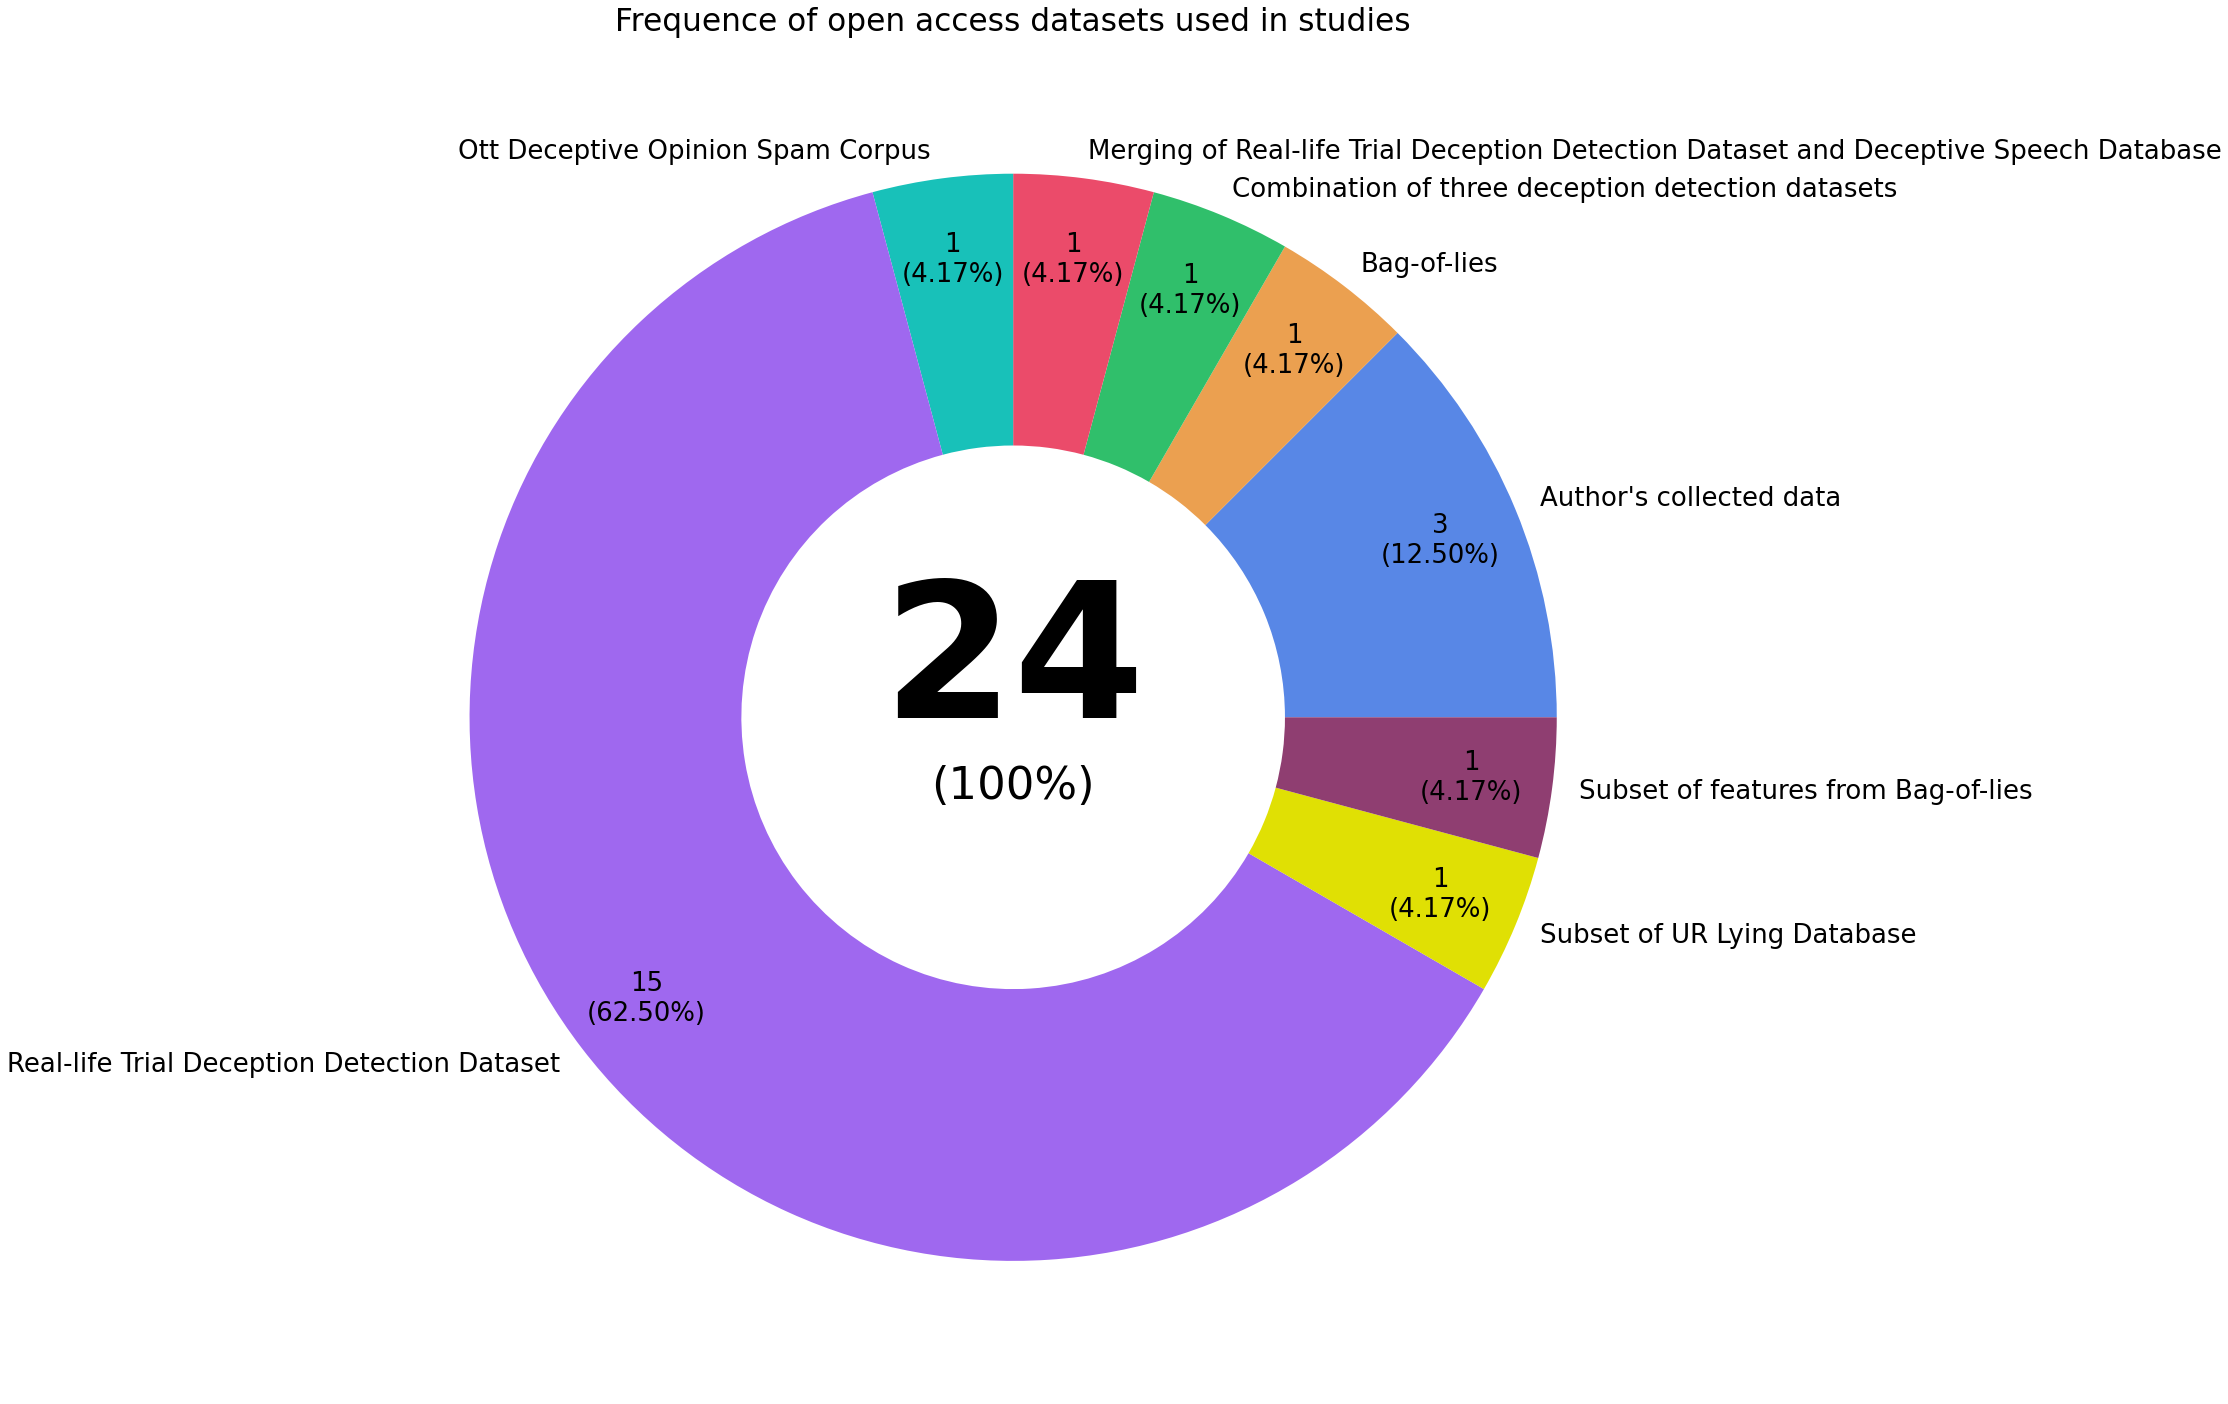

In [54]:
datasets_public_df = datasets_df[datasets_df.Public == 1].loc[:,['Name', 'Source', 'year']].copy()
names = list(datasets_public_df.Name)
sources = list(datasets_public_df.Source)

datasets_public_df.Name = [(source if source == "Real-life Trial Deception Detection Dataset" else name) for (name, source) in zip(names, sources)]
datasets_public_df.columns = ['Name', 'Source', 'Volume of papers']
datasets_public_df = datasets_public_df.groupby('Name').agg(len)
#datasets_public_df.head(50)
utility.donut(datasets_public_df, 'Frequence of open access datasets used in studies', figsize=(45, 25))

In [55]:
datasets_papers_df = datasets_df.loc[:,['document_id', 'Name', 'Origin', 'Public', 'Real-life', 'Cardinality', 'Modality_combination', 'Features', 'year']]
datasets_papers_df['Public'] = datasets_papers_df.Public.apply(lambda public: public == 1)
datasets_papers_df['Real-life'] = datasets_papers_df['Real-life'].apply(lambda real_life: real_life == 1)
datasets_papers_df['Paper'] = datasets_papers_df.document_id.apply(lambda id: document_by_id[id].title)
datasets_papers_df['Author'] = datasets_papers_df.document_id.apply(lambda id: ', '.join([a.author.long_name for a in document_by_id[id].authors]))
datasets_papers_df.drop(columns=['document_id'], inplace=True)
datasets_papers_df.sort_values(['year', 'Paper'], ascending=[False, True], inplace=True)
datasets_papers_df[['year', 'Paper', 'Author', 'Name', 'Origin', 'Public', 'Real-life', 'Cardinality', 'Modality_combination', 'Features']]\
    .style.set_caption("<h2>Summary of datasets used in studies in the selected corpus</h2>")

In [56]:
datasets_papers_reallife_df = pd.DataFrame(datasets_papers_df[datasets_papers_df.Origin=='Real-life Trial Deception Detection Dataset'])
#datasets_papers_reallife_df.drop(columns=['Name', 'Origin', 'Public', 'Real-life'], inplace=True)
datasets_papers_reallife_df[['year', 'Paper', 'Author', 'Cardinality', 'Modality_combination', 'Features']]\
    .style.set_caption("<h2>Summary of <b>Real-life Trial Deception Detection Dataset</b> used in studies in the selected corpus</h2>")

In [57]:
datasets_papers_cdx_df = pd.DataFrame(datasets_papers_df[datasets_papers_df.Name=='Columbia X-Cultural Dataset'])
#datasets_papers_cdx_df.drop(columns=['Name'], inplace=True)
datasets_papers_cdx_df[['year', 'Paper', 'Author', 'Cardinality', 'Modality_combination', 'Features']]\
    .style.set_caption("<h2>Summary of <b>Columbia X-Cultural Dataset</b> used in studies in the selected corpus</h2>")

In [58]:
datasets_papers_soochow_df = pd.DataFrame(datasets_papers_df[datasets_papers_df.Name=='Soochow Deceptive Speech Detection Corpus'])
#datasets_papers_soochow_df.drop(columns=['Name'], inplace=True)
datasets_papers_soochow_df[['year', 'Paper', 'Author', 'Cardinality', 'Modality_combination', 'Features']]\
    .style.set_caption("<h2>Summary of <b>Soochow Deceptive Speech Detection Corpus</b> used in studies in the selected corpus</h2>")

In [59]:
feature_kinds = sorted(list(set(reduce(lambda x,y: x+y, [[f['kind'] for f in md['dataset']['features']] for md in metadata]))))
#print(feature_kinds)
dataset_names = sorted(list(set([(md['dataset']['name'] if md['dataset']['name'] else '') for md in metadata])))
#print(dataset_names)

benchmark = [{
    'document_id': md['document_id'],
    'datasets': md['dataset'],
    'Name': md['dataset']['name'],
    'Origin': md['dataset']['origin'],
    'Public': md['dataset']['public'],
    'Real-life': not md['dataset']['mock'],
    'Cardinality': md['dataset']['size'],
    'modalities': [(f['kind'], f['components']) for f in md['dataset']['features']],
    'Modalities': ' + '.join([f['kind'] for f in md['dataset']['features']]),
    'dimensions': [(f['kind'], f['dimensions']) for f in md['dataset']['features']],
    'Algorithms': ', '.join(sorted(list(set([m['classifier'] for m in md['methods'] if 'classifier' in m])))),
    }
    for md in metadata]
datasets_benchmark_df = pd.DataFrame(benchmark)
datasets_benchmark_df.sort_values(['Name'], inplace=True)
for feature_kind in feature_kinds:
    datasets_benchmark_df[feature_kind] = datasets_benchmark_df.dimensions.apply(lambda modality: [mod[1] for mod in modality if feature_kind == mod[0]])
    datasets_benchmark_df[feature_kind] = datasets_benchmark_df[feature_kind].apply(lambda cardinality: 0 if len(cardinality) == 0 else cardinality[0] if cardinality[0] is not None else 'Uninformed')
#datasets_benchmark_df.drop(columns=['document_id'], inplace=True)
#datasets_benchmark_df.reset_index(drop=True, inplace=True)
#datasets_benchmark_df = pd.DataFrame(temp_metadata)
datasets_benchmark_df.loc[:, ['Name', 'Origin', 'Public', 'Real-life', 'Cardinality'] + feature_kinds + ['Algorithms']].sort_values(['Real-life', 'Cardinality'])\
    .style.set_caption("<h2>Summary of dataset features used in studies in the selected corpus</h2>")
#datasets_benchmark_df

In [60]:
all_names = list(set([name for name in datasets_benchmark_df.Name if name is not None]))
all_names

['Mafia DB',
 'Superset of Real-life Trial Deception Detection Dataset',
 'KWOLF',
 'Subset of UR Lying Database',
 'Indonesian Deception Corpus',
 'Ott Deceptive Opinion Spam Corpus ',
 'Combination of three deception detection datasets',
 'Soochow Deceptive Speech Detection Corpus',
 'Merging of Real-life Trial Deception Detection Dataset and Deceptive Speech Database',
 'Bag-of-lies',
 'Columbia X-Cultural Dataset',
 'Subset of features from Bag-of-lies',
 'ReliDDB',
 'Deception Detection and Physiological Monitoring Dataset',
 'Russian Deception Bank',
 'CSC Deceptive Speech',
 'Daily Deceptive Dialogues Corpus of Mandarin ',
 'Subset of Real-life Trial Deception Detection Dataset',
 'Real-life Trial Deception Detection Dataset',
 'DeCour corpus',
 'Wolf-database']

### 8. Performance analysis

#### 8.1. Performance metrics and levels
The next charts present the performance achieved by each study in the selected corpus. Studies presented the achieved performance in
different measures. Most of them used **Accuracy** alone or combined with some other metric, but a few ones also used **Area Under the Curve**,
**F1-score**, **Precision**, **Recall**, and **Unweighted Average Recall**.

When **Accuracy** and some other metric was used, **Accuracy** was accounted as the one for that study, since the threshold (90%) used to
classify lie catcher as "Wizards of Deception Detection" by [1] is measured by accuracy.

[1] O’Sullivan M, Ekman P. The wizards of deception detection. The Detection of Deception in Forensic Contexts. 2004.

In [61]:
temp_metadata = reduce(lambda x, y: x+y, [md['methods'] for md in metadata])

all_performance_kinds = reduce(lambda x,y: x+y, [m['performance'] for m in temp_metadata if 'performance' in m])
all_performance_kinds = sorted(list(set([p['kind'] for p in all_performance_kinds])))
print(all_performance_kinds)

['Accuracy', 'Area Under the Curve', 'F1-score', 'Precision', 'Recall', 'Unweighted Average Recall']


In [62]:
temp_metadata = [{
    'document_id': md['document_id'],
    'Method': utility.best_method(md['methods']),
    'Dataset': md['dataset']['name'] if md['dataset']['name'] is not None else md['dataset']['origin'],
    'Dataset_cardinality': md['dataset']['size'],
    'modalities': [(f['kind'], f['components']) for f in md['dataset']['features']],
} for md in metadata]

performance_df = pd.DataFrame(temp_metadata)
performance_df['Technique'] = performance_df.Method.apply(lambda value: value['classifier'])
for performance_kind in all_performance_kinds:
    performance_df[performance_kind] = performance_df.Method.apply(lambda method: utility.performance_by_kind(method, performance_kind))
performance_df['Modality_count'] = performance_df.modalities.apply(lambda value: len(value))
performance_df['Modality_cardinality'] = performance_df.Modality_count.apply(lambda value: 'Monomodal' if value==1 else 'Bimodal' if value==2 else 'Multimodal')
performance_df['Modality_combination'] = performance_df.modalities.apply(lambda value: '+'.join(sorted(list(set([m[0] for m in value])))))
performance_df['Features'] = performance_df.modalities.apply(lambda value: ', '.join(sorted(reduce(lambda x,y: x+y, [m[1] for m in value]))))
performance_df['Year'] = performance_df.document_id.apply(lambda id: document_by_id[id].year)
performance_df = performance_df.loc[:,['document_id', 'Year', 'Technique'] + all_performance_kinds +
                                      ['Modality_cardinality', 'Modality_combination', 'Dataset', 'Dataset_cardinality', 'Features']]
#performance_df.sort_values(['Performance'], ascending=False, inplace=True)
performance_df.sort_values(['Year'], ascending=False, inplace=True)
performance_df.style.set_caption("<h2>Summary of performances achieved by techniques exploited by studies in the selected corpus</h2>")

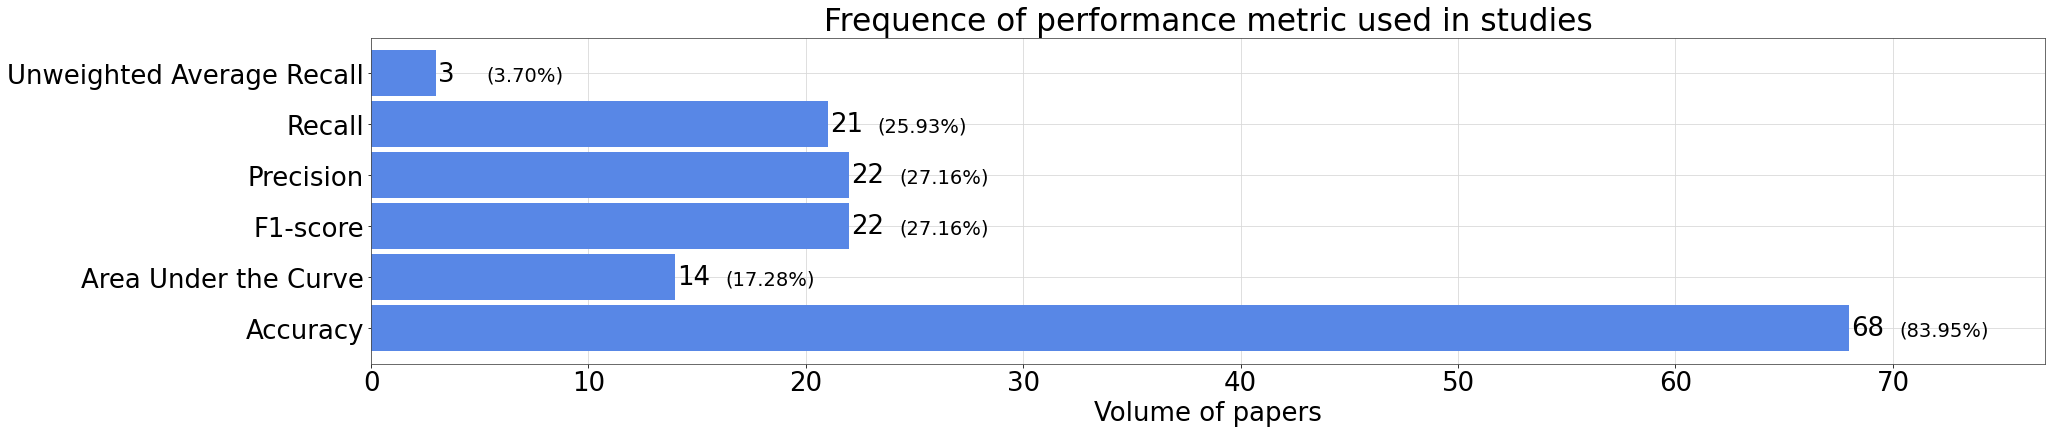

In [63]:
performance_sum_df = pd.DataFrame(performance_df.loc[:, all_performance_kinds].apply(lambda column: (column != 0).sum()))
performance_sum_df.columns = ['Volume']
utility.barh(performance_sum_df, title='Frequence of performance metric used in studies',
             xlabel='Volume of papers', total=len(performance_df),
             figsize=(30, 6), xlim=77, x_offset_perc=2.2)

#### 8.2. Performance and modality

In [64]:
accuracy_df = performance_df[performance_df.Accuracy > 0].sort_values(['Accuracy'], ascending=False)
#accuracy_df

In [65]:
auc_df = performance_df[performance_df['Area Under the Curve'] > 0].sort_values(['Area Under the Curve'], ascending=False)
#auc_df

In [66]:
f1_df = performance_df[performance_df['F1-score'] > 0].sort_values(['F1-score'], ascending=False)
#f1_df

In [67]:
uar_df = performance_df[performance_df['Unweighted Average Recall'] > 0].sort_values(['Unweighted Average Recall'], ascending=False)
#uar_df

In [68]:
precision_df = performance_df[performance_df.Precision > 0].sort_values(['Precision'], ascending=False)
#precision_df

In [69]:
recall_df = performance_df[performance_df.Recall > 0].sort_values(['Recall'], ascending=False)
#recall_df

In [70]:
accuracy_modality_df = accuracy_df.loc[:, ['Accuracy', 'Modality_cardinality']]
#accuracy_modality_df

In [71]:
accuracy_modality_all_sum_df = pd.DataFrame(group.describe().rename(columns={'Performance':Modality}).squeeze()
                                            for Modality, group in accuracy_modality_df.groupby('Modality_cardinality'))
accuracy_modality_all_sum_df.drop(columns=['25%', '50%', '75%'], inplace=True)
accuracy_modality_all_sum_df = accuracy_modality_all_sum_df.round({'count': 0, 'mean': 3, 'std': 3, 'min': 3, 'max': 3})
#accuracy_modality_all_sum_df

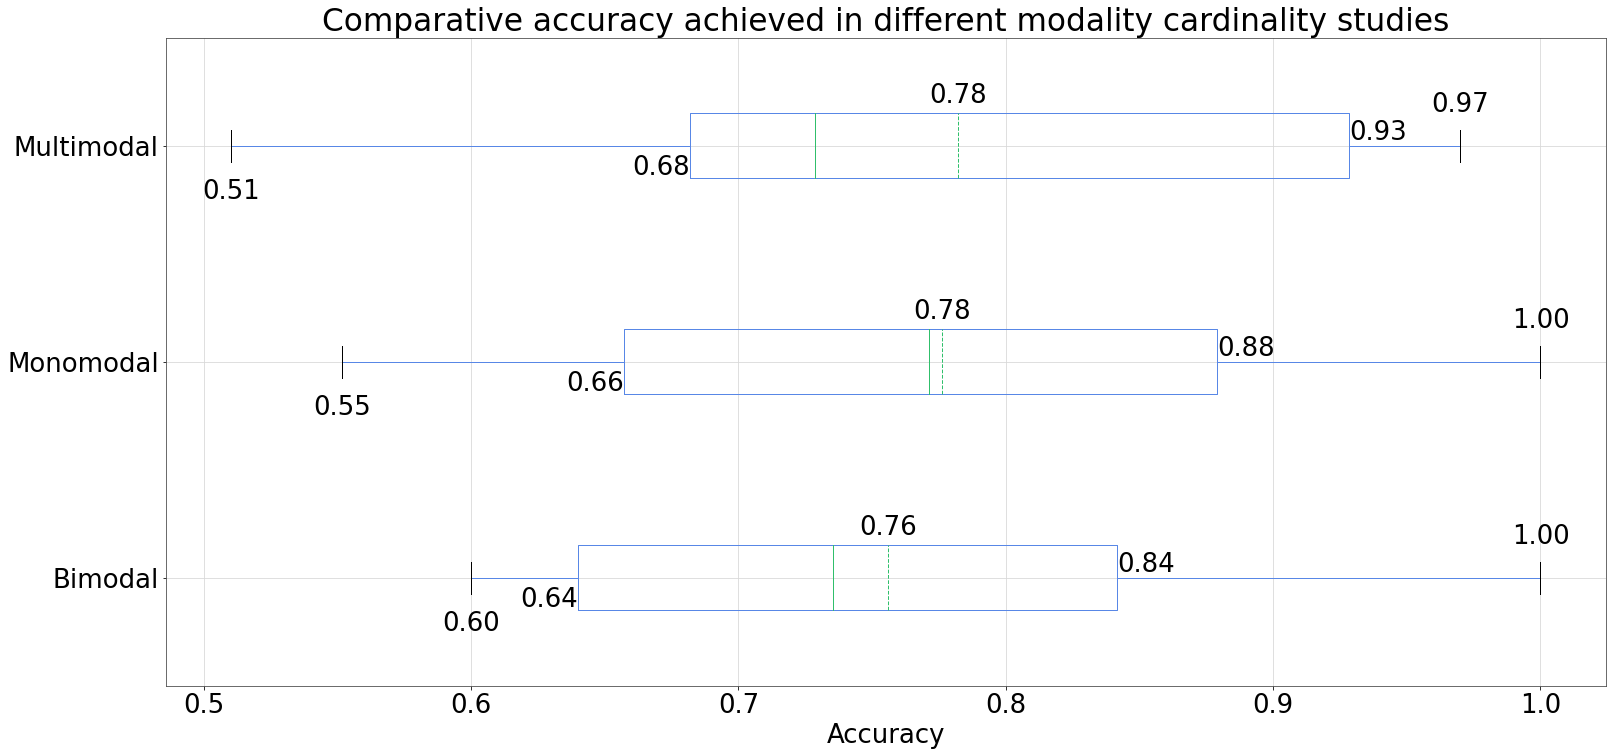

In [72]:
fig, ax1 = plt.subplots(figsize=(25,12))
bp = accuracy_df.boxplot(ax=ax1, column=['Accuracy'], by='Modality_cardinality', return_type='dict', 
                         showmeans=True, meanline=True, patch_artist=False, vert=False)
fig.suptitle('')
ax1.set_title('Comparative accuracy achieved in different modality cardinality studies')
plt.xlabel('Accuracy')
utility.show_bp_data(bp, False, ax1, mean_offset=0.35)
plt.show()

#### 8.3. Performance in Monomodal approaches

In [73]:
accuracy_mono_df = accuracy_df.loc[:, ['document_id', 'Year', 'Technique', 'Accuracy', 'Modality_cardinality', 'Modality_combination']]
accuracy_mono_df.drop(accuracy_mono_df[accuracy_mono_df.Modality_cardinality!='Monomodal'].index, inplace=True)
accuracy_mono_df['Modality'] = accuracy_mono_df.Modality_combination.apply(lambda value: value)
accuracy_mod_mono_df = accuracy_mono_df.drop(columns=['document_id', 'Year', 'Technique', 'Modality_cardinality', 'Modality_combination'])
#accuracy_mod_mono_df = accuracy_mod_mono_df[accuracy_mod_mono_df.Modality.isin(['Visual', 'Vocal', 'Textual', 'Thermal'])]
#accuracy_mod_mono_df

In [74]:
accuracy_mod_mono_sum_df = pd.DataFrame(group.describe().rename(columns={'Performance':Modality}).squeeze()
                                        for Modality, group in accuracy_mod_mono_df.groupby('Modality'))
accuracy_mod_mono_sum_df.drop(columns=['25%', '50%', '75%'], inplace=True)
accuracy_mod_mono_sum_df = accuracy_mod_mono_sum_df.round({'count': 0, 'mean': 3, 'std': 3, 'min': 3, 'max': 3})
#accuracy_mod_mono_sum_df

In [75]:
accuracy_columns = ['Year', 'Authors', 'Title', 'Accuracy', 'Technique', 'Features', 'Dataset', 'Dataset_cardinality']
studies_columns =  accuracy_columns + ['Modality_cardinality', 'Modality_combination']
studies_df = pd.DataFrame(accuracy_df)
studies_df['Title'] = studies_df.document_id.apply(lambda id: document_by_id[id].title)
studies_df['Authors'] = studies_df.document_id.apply(lambda id: '; '.join([au.author.long_name for au in document_by_id[id].authors]))
studies_df = studies_df.loc[:,studies_columns]
#studies_df

In [76]:
accuracy_mono_textual_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Textual'])\
                             .sort_values(['Accuracy'], ascending=False)
accuracy_mono_textual_df = accuracy_mono_textual_df.loc[:,accuracy_columns]
#accuracy_mono_textual_df.to_clipboard()
#accuracy_mono_textual_df.describe()
accuracy_mono_textual_df.style.set_caption("<h2>Accuracies achieved by <b>Monomodal Texual</b> studies</h2>")

In [77]:
accuracy_mono_visual_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Visual'])\
                            .sort_values(['Accuracy'], ascending=False)
accuracy_mono_visual_df = accuracy_mono_visual_df.loc[:,accuracy_columns]
#accuracy_mono_visual_df.to_clipboard()
#accuracy_mono_visual_df.describe()
accuracy_mono_visual_df.style.set_caption("<h2>Accuracies achieved by <b>Monomodal Visual</b> studies</h2>")

In [78]:
accuracy_mono_vocal_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Vocal'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_mono_vocal_df = accuracy_mono_vocal_df.loc[:,accuracy_columns]
#accuracy_mono_vocal_df.to_clipboard()
#accuracy_mono_vocal_df.describe()
accuracy_mono_vocal_df.style.set_caption("<h2>Accuracies achieved by <b>Monomodal Vocal</b> studies</h2>")

In [79]:
accuracy_mono_thermal_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Thermal'])\
                             .sort_values(['Accuracy'], ascending=False)
accuracy_mono_thermal_df = accuracy_mono_thermal_df.loc[:,accuracy_columns]
#accuracy_mono_thermal_df.to_clipboard()
#accuracy_mono_thermal_df.describe()
accuracy_mono_thermal_df.style.set_caption("<h2>Accuracies achieved by <b>Monomodal Thermal</b> studies</h2>")

In [80]:
accuracy_mono_emotional_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Emotional'])\
                               .sort_values(['Accuracy'], ascending=False)
accuracy_mono_emotional_df = accuracy_mono_emotional_df.loc[:,accuracy_columns]
#accuracy_mono_emotional_df.to_clipboard()
#accuracy_mono_emotional_df.describe()
accuracy_mono_emotional_df.style.set_caption("<h2>Accuracies achieved by <b>Monomodal Emotional</b> studies</h2>")

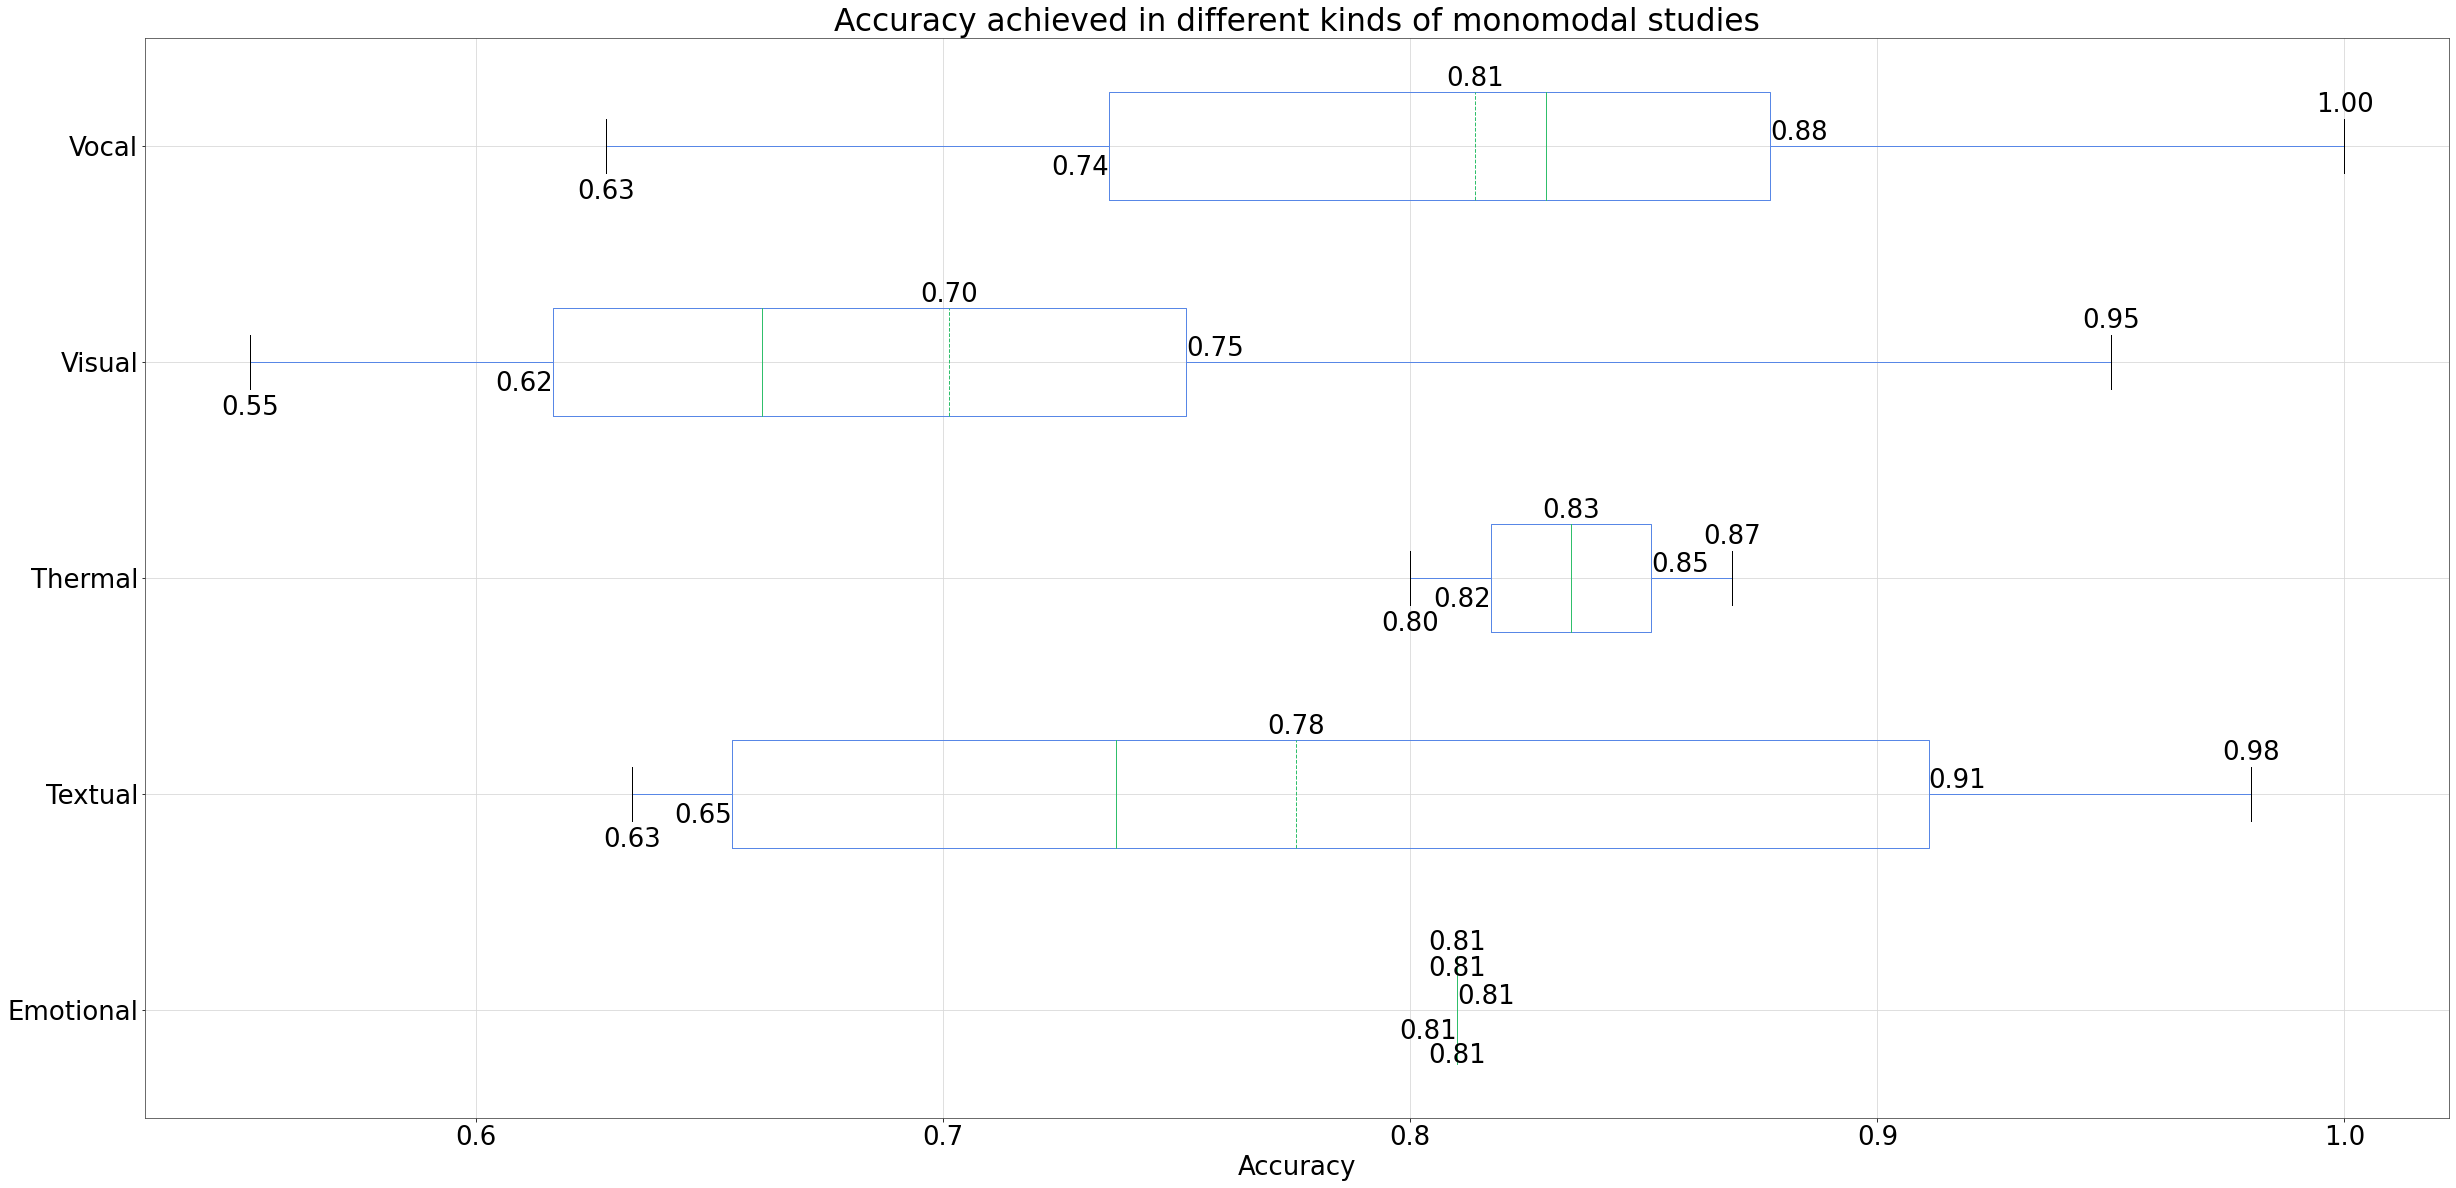

In [81]:
fig, ax1 = plt.subplots(figsize=(40,20))
bp = accuracy_mod_mono_df.boxplot(ax=ax1, column=['Accuracy'], by='Modality', return_type='dict', 
                                  showmeans=True, meanline=True, patch_artist=False, vert=False)
fig.suptitle('')
ax1.set_title('Accuracy achieved in different kinds of monomodal studies')
plt.xlabel('Accuracy')
utility.show_bp_data(bp, False, ax1, mean_offset=0.53)
plt.show()

#### 8.4. Performance in Bimodal approaches

In [82]:
accuracy_bi_df = accuracy_df.loc[:, ['document_id', 'Year', 'Technique', 'Accuracy', 'Modality_cardinality', 'Modality_combination']]

accuracy_bi_df.drop(accuracy_bi_df[accuracy_bi_df.Modality_cardinality != 'Bimodal'].index, inplace=True)
accuracy_bi_df['Modality'] = accuracy_bi_df.Modality_combination.apply(lambda value: value.replace(' ', '+'))
accuracy_mod_bi_df = accuracy_bi_df.drop(columns=['document_id', 'Year', 'Technique', 'Modality_cardinality', 'Modality_combination'])
#accuracy_mod_bi_df = accuracy_mod_bi_df[accuracy_mod_bi_df.Modality.isin(['Visual+Vocal', 'Textual+Vocal', 'Textual+Visual', 'Demographical+Vocal', 'Demographical+Visual', 'Demographical+Textual'])]
#accuracy_mod_bi_df

In [83]:
accuracy_mod_bi_sum_df = pd.DataFrame(group.describe().rename(columns={'Accuracy':Modality}).squeeze()
                                      for Modality, group in accuracy_mod_bi_df.groupby('Modality'))
accuracy_mod_bi_sum_df.drop(columns=['25%', '50%', '75%'], inplace=True)
accuracy_mod_bi_sum_df = accuracy_mod_bi_sum_df.round({'count': 0, 'mean': 3, 'std': 3, 'min': 3, 'max': 3})
#accuracy_mod_bi_sum_df

In [84]:
accuracy_bi_dem_vis_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Demographical+Visual'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_dem_vis_df = accuracy_bi_dem_vis_df.loc[:,accuracy_columns]
accuracy_bi_dem_vis_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Demographical + Visual</b> studies</h2>")

In [85]:
accuracy_bi_tex_vis_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Textual+Visual'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_tex_vis_df = accuracy_bi_tex_vis_df.loc[:,accuracy_columns]
accuracy_bi_tex_vis_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Textual + Visual</b> studies</h2>")

In [86]:
accuracy_bi_vis_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Visual+Vocal'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_vis_voc_df = accuracy_bi_vis_voc_df.loc[:,accuracy_columns]
accuracy_bi_vis_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Visual + Vocal</b> studies</h2>")

In [87]:
accuracy_bi_dem_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Demographical+Vocal'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_dem_voc_df = accuracy_bi_dem_voc_df.loc[:,accuracy_columns]
accuracy_bi_dem_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Demographical + Vocal</b> studies</h2>")

In [88]:
accuracy_bi_dem_tex_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Demographical+Textual'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_dem_tex_df = accuracy_bi_dem_tex_df.loc[:,accuracy_columns]
accuracy_bi_dem_tex_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Demographical + Textual</b> studies</h2>")

In [89]:
accuracy_bi_tex_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Textual+Vocal'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_tex_voc_df = accuracy_bi_tex_voc_df.loc[:,accuracy_columns]
accuracy_bi_tex_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Textual + Vocal</b> studies</h2>")

In [90]:
accuracy_bi_phy_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Physiological+Vocal'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_phy_voc_df = accuracy_bi_phy_voc_df.loc[:,accuracy_columns]
accuracy_bi_phy_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Physiological + Vocal</b> studies</h2>")

In [91]:
accuracy_bi_psy_vis_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Psychological+Visual'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_psy_vis_df = accuracy_bi_psy_vis_df.loc[:,accuracy_columns]
accuracy_bi_psy_vis_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Psychological + Visual</b> studies</h2>")

In [92]:
accuracy_bi_the_vis_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Thermal+Visual'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_the_vis_df = accuracy_bi_the_vis_df.loc[:,accuracy_columns]
accuracy_bi_the_vis_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Thermal + Visual</b> studies</h2>")

In [93]:
accuracy_bi_the_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Thermal+Vocal'])\
                           .sort_values(['Accuracy'], ascending=False)
accuracy_bi_the_voc_df = accuracy_bi_the_voc_df.loc[:,accuracy_columns]
accuracy_bi_the_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Bimodal Thermal + Vocal</b> studies</h2>")

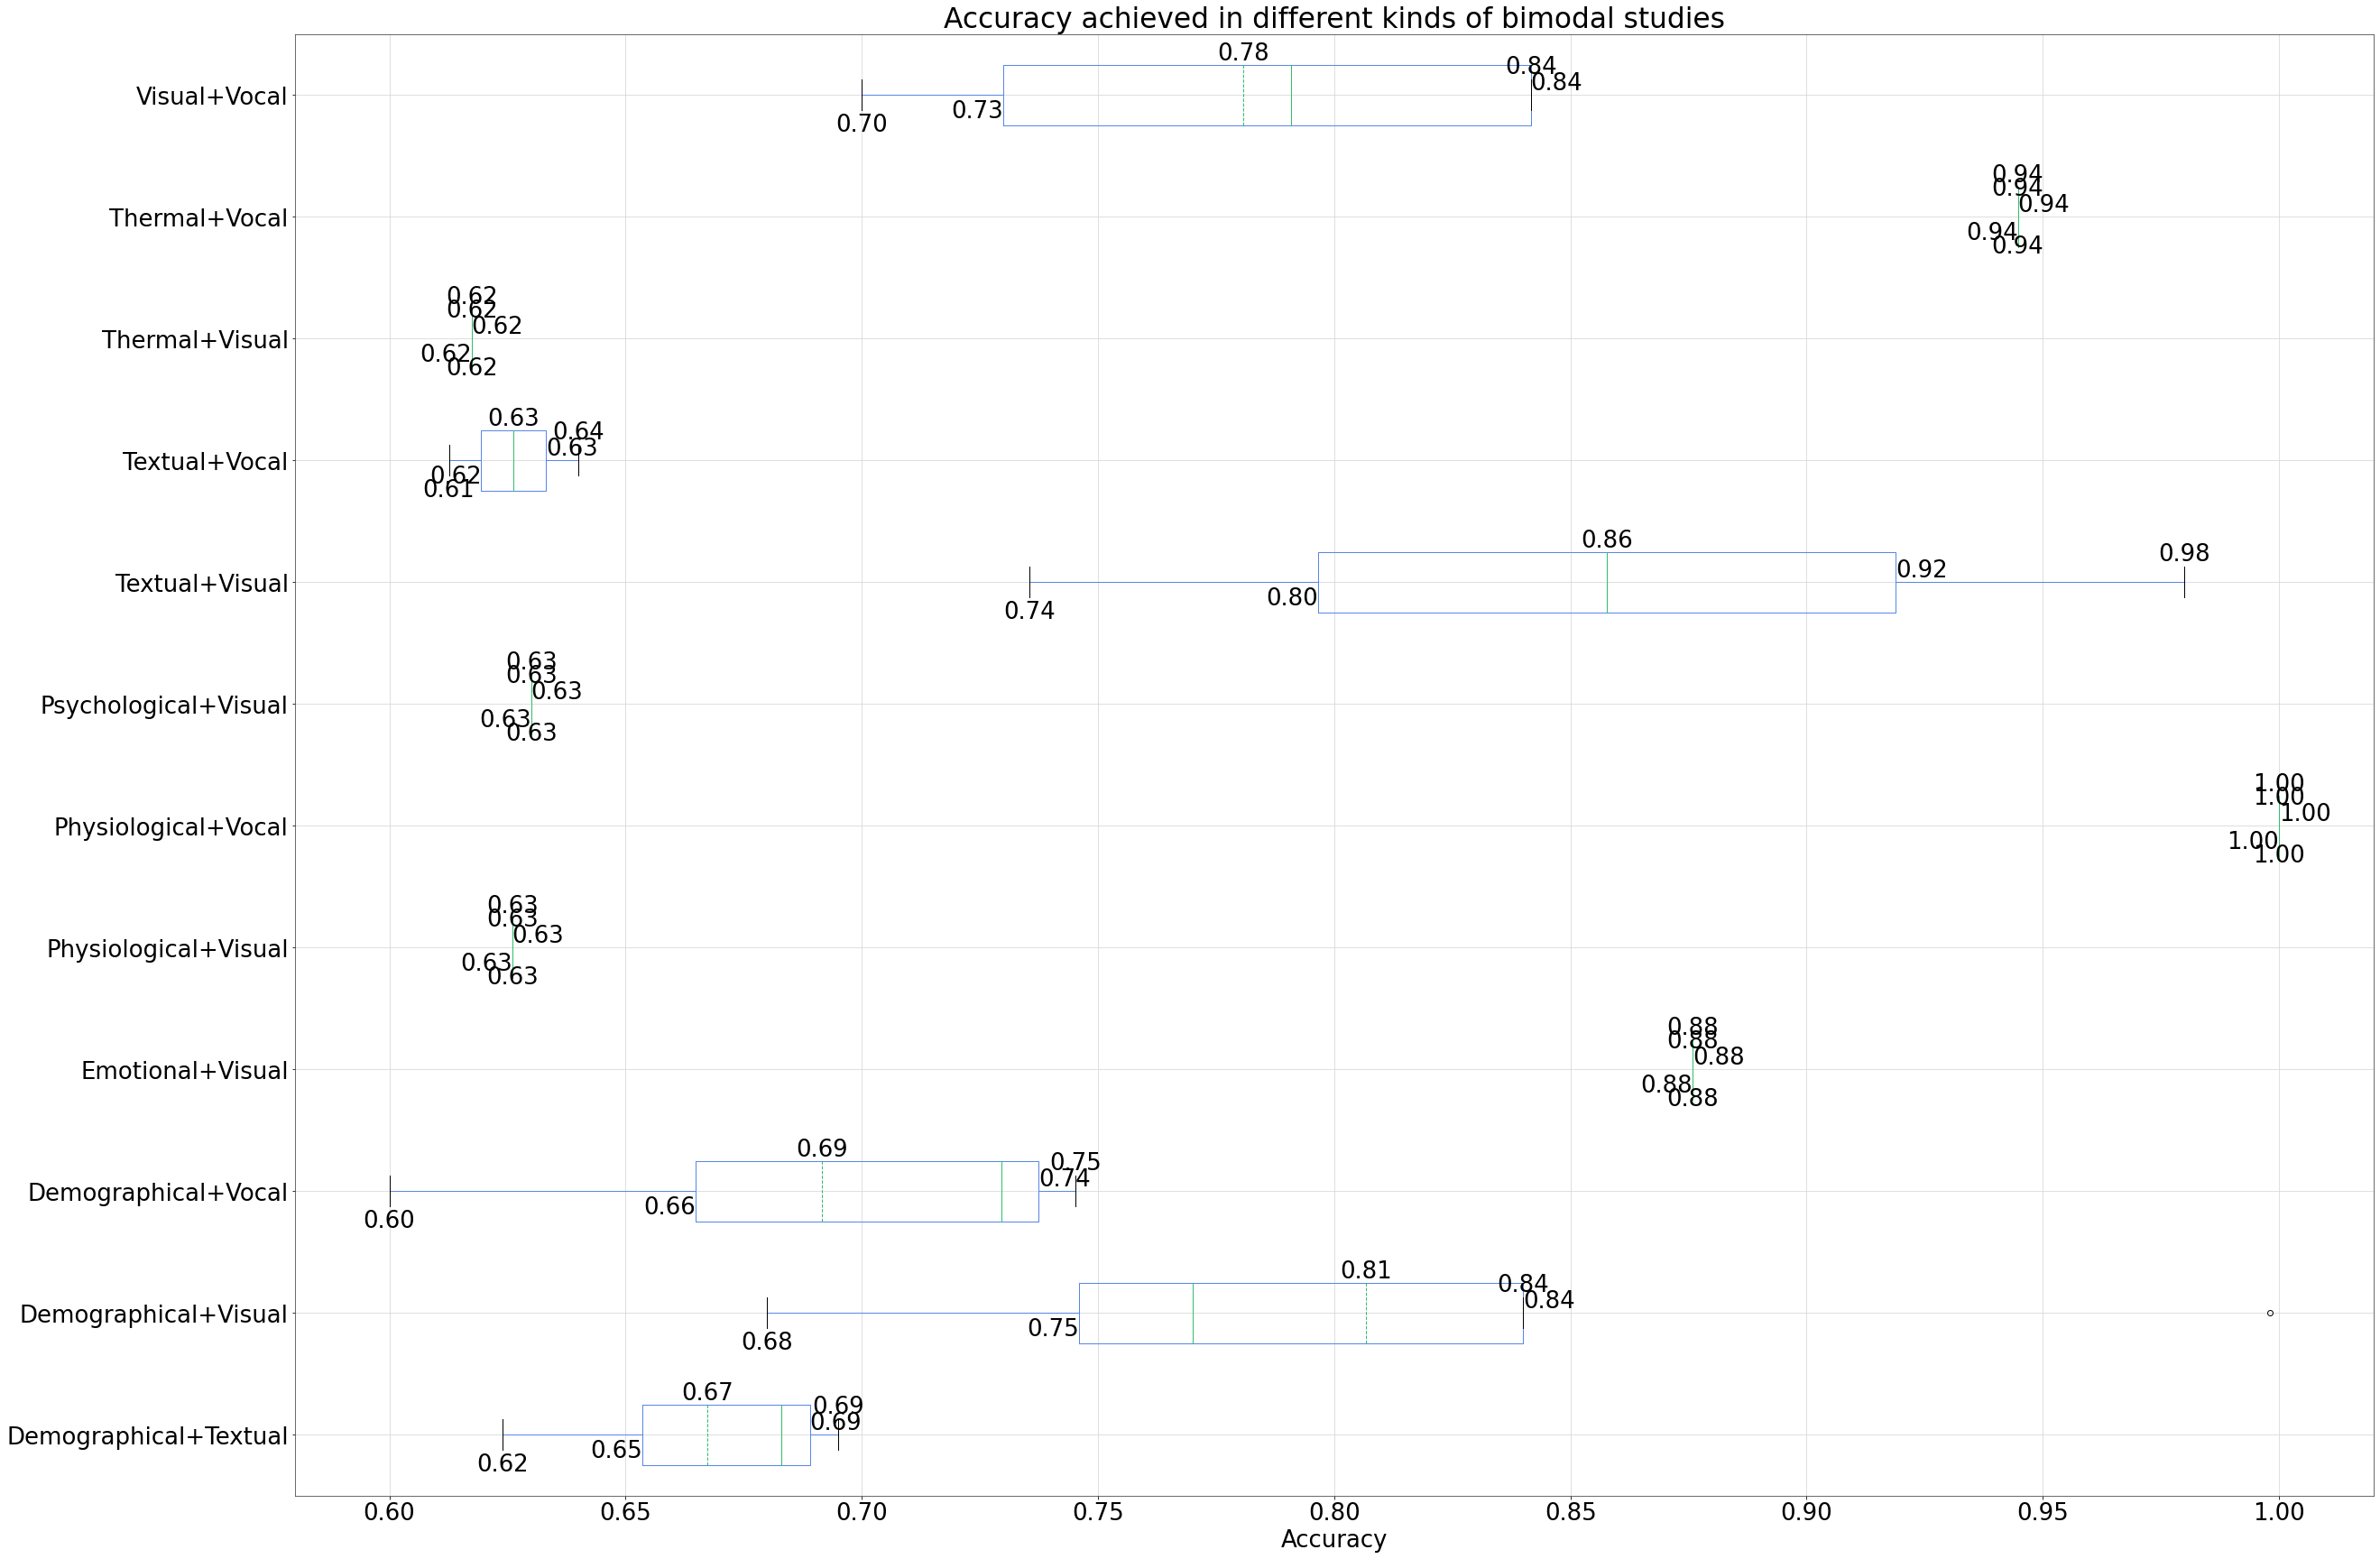

In [94]:
fig, ax1 = plt.subplots(figsize=(40,30))
bp = accuracy_mod_bi_df.boxplot(ax=ax1, column=['Accuracy'], by='Modality', return_type='dict', 
                                showmeans=True, meanline=True, patch_artist=False, vert=False)
fig.suptitle('')
ax1.set_title('Accuracy achieved in different kinds of bimodal studies')
plt.xlabel('Accuracy')
utility.show_bp_data(bp, False, ax1, mean_offset=0.54)
plt.show()

#### 8.5. Performance in Multimodal approaches

In [95]:
accuracy_mult_df = accuracy_df.loc[:, ['document_id', 'Year', 'Technique', 'Accuracy', 'Modality_cardinality', 'Modality_combination']]
accuracy_mult_df.drop(accuracy_mult_df[accuracy_mult_df.Modality_cardinality != 'Multimodal'].index, inplace=True)
accuracy_mult_df['Modality'] = accuracy_mult_df.Modality_combination.apply(lambda value: value.replace(' ', '+'))
accuracy_mod_mult_df = accuracy_mult_df.drop(columns=['document_id', 'Year', 'Technique', 'Modality_cardinality', 'Modality_combination'])
#accuracy_mod_mult_df = accuracy_mod_mult_df[accuracy_mod_mult_df.Modality.isin(['Textual+Visual+Vocal', 'Physiological+Textual+Thermal'])]
#accuracy_mod_mult_df

In [96]:
accuracy_mod_mult_sum_df = pd.DataFrame(group.describe().rename(columns={'Accuracy':Modality}).squeeze()
                                        for Modality, group in accuracy_mod_mult_df.groupby('Modality'))
accuracy_mod_mult_sum_df.drop(columns=['25%', '50%', '75%'], inplace=True)
accuracy_mod_mult_sum_df = accuracy_mod_mult_sum_df.round({'count': 0, 'mean': 3, 'std': 3, 'min': 3, 'max': 3})
#accuracy_mod_mult_sum_df.head(20)

In [97]:
accuracy_mult_tex_vis_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Textual+Visual+Vocal'])\
                                 .sort_values(['Accuracy'], ascending=False)
accuracy_mult_tex_vis_voc_df = accuracy_mult_tex_vis_voc_df.loc[:,accuracy_columns]
accuracy_mult_tex_vis_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Multimodal Textual + Visual + Vocal</b> studies</h2>")

In [98]:
accuracy_mult_phy_tex_the_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Physiological+Textual+Thermal'])\
                                 .sort_values(['Accuracy'], ascending=False)
accuracy_mult_phy_tex_the_df = accuracy_mult_phy_tex_the_df.loc[:,accuracy_columns]
accuracy_mult_phy_tex_the_df.style.set_caption("<h2>Accuracies achieved by <b>Multimodal Physiological + Textual + Thermal</b> studies</h2>")

In [99]:
accuracy_mult_dem_tex_vis_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Demographical+Textual+Visual+Vocal'])\
                                     .sort_values(['Accuracy'], ascending=False)
accuracy_mult_dem_tex_vis_voc_df = accuracy_mult_dem_tex_vis_voc_df.loc[:,accuracy_columns]
accuracy_mult_dem_tex_vis_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Multimodal Demographical + Textual + Visual + Vocal</b> studies</h2>")

In [100]:
accuracy_mult_dem_phy_tex_the_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Demographical+Physiological+Textual+Thermal'])\
                                     .sort_values(['Accuracy'], ascending=False)
accuracy_mult_dem_phy_tex_the_df = accuracy_mult_dem_phy_tex_the_df.loc[:,accuracy_columns]
accuracy_mult_dem_phy_tex_the_df.style.set_caption("<h2>Accuracies achieved by <b>Multimodal Demographical + Physiological + Textual + Thermal</b> studies</h2>")

In [101]:
accuracy_mult_phy_vis_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Physiological+Visual+Vocal'])\
                                     .sort_values(['Accuracy'], ascending=False)
accuracy_mult_phy_vis_voc_df = accuracy_mult_phy_vis_voc_df.loc[:,accuracy_columns]
accuracy_mult_phy_vis_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Multimodal Physiological + Visual + Vocal</b> studies</h2>")

In [102]:
accuracy_mult_dem_psy_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Demographical+Psychological+Vocal'])\
                                 .sort_values(['Accuracy'], ascending=False)
accuracy_mult_dem_psy_voc_df = accuracy_mult_dem_psy_voc_df.loc[:,accuracy_columns]
accuracy_mult_dem_psy_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Multimodal Demographical + Psychological + Vocal</b> studies</h2>")

In [103]:
accuracy_mult_dem_tex_voc_df = pd.DataFrame(studies_df[studies_df.Modality_combination == 'Demographical+Textual+Vocal'])\
                                 .sort_values(['Accuracy'], ascending=False)
accuracy_mult_dem_tex_voc_df = accuracy_mult_dem_tex_voc_df.loc[:,accuracy_columns]
accuracy_mult_dem_tex_voc_df.style.set_caption("<h2>Accuracies achieved by <b>Multimodal Demographical + Textual + Vocal</b> studies</h2>")

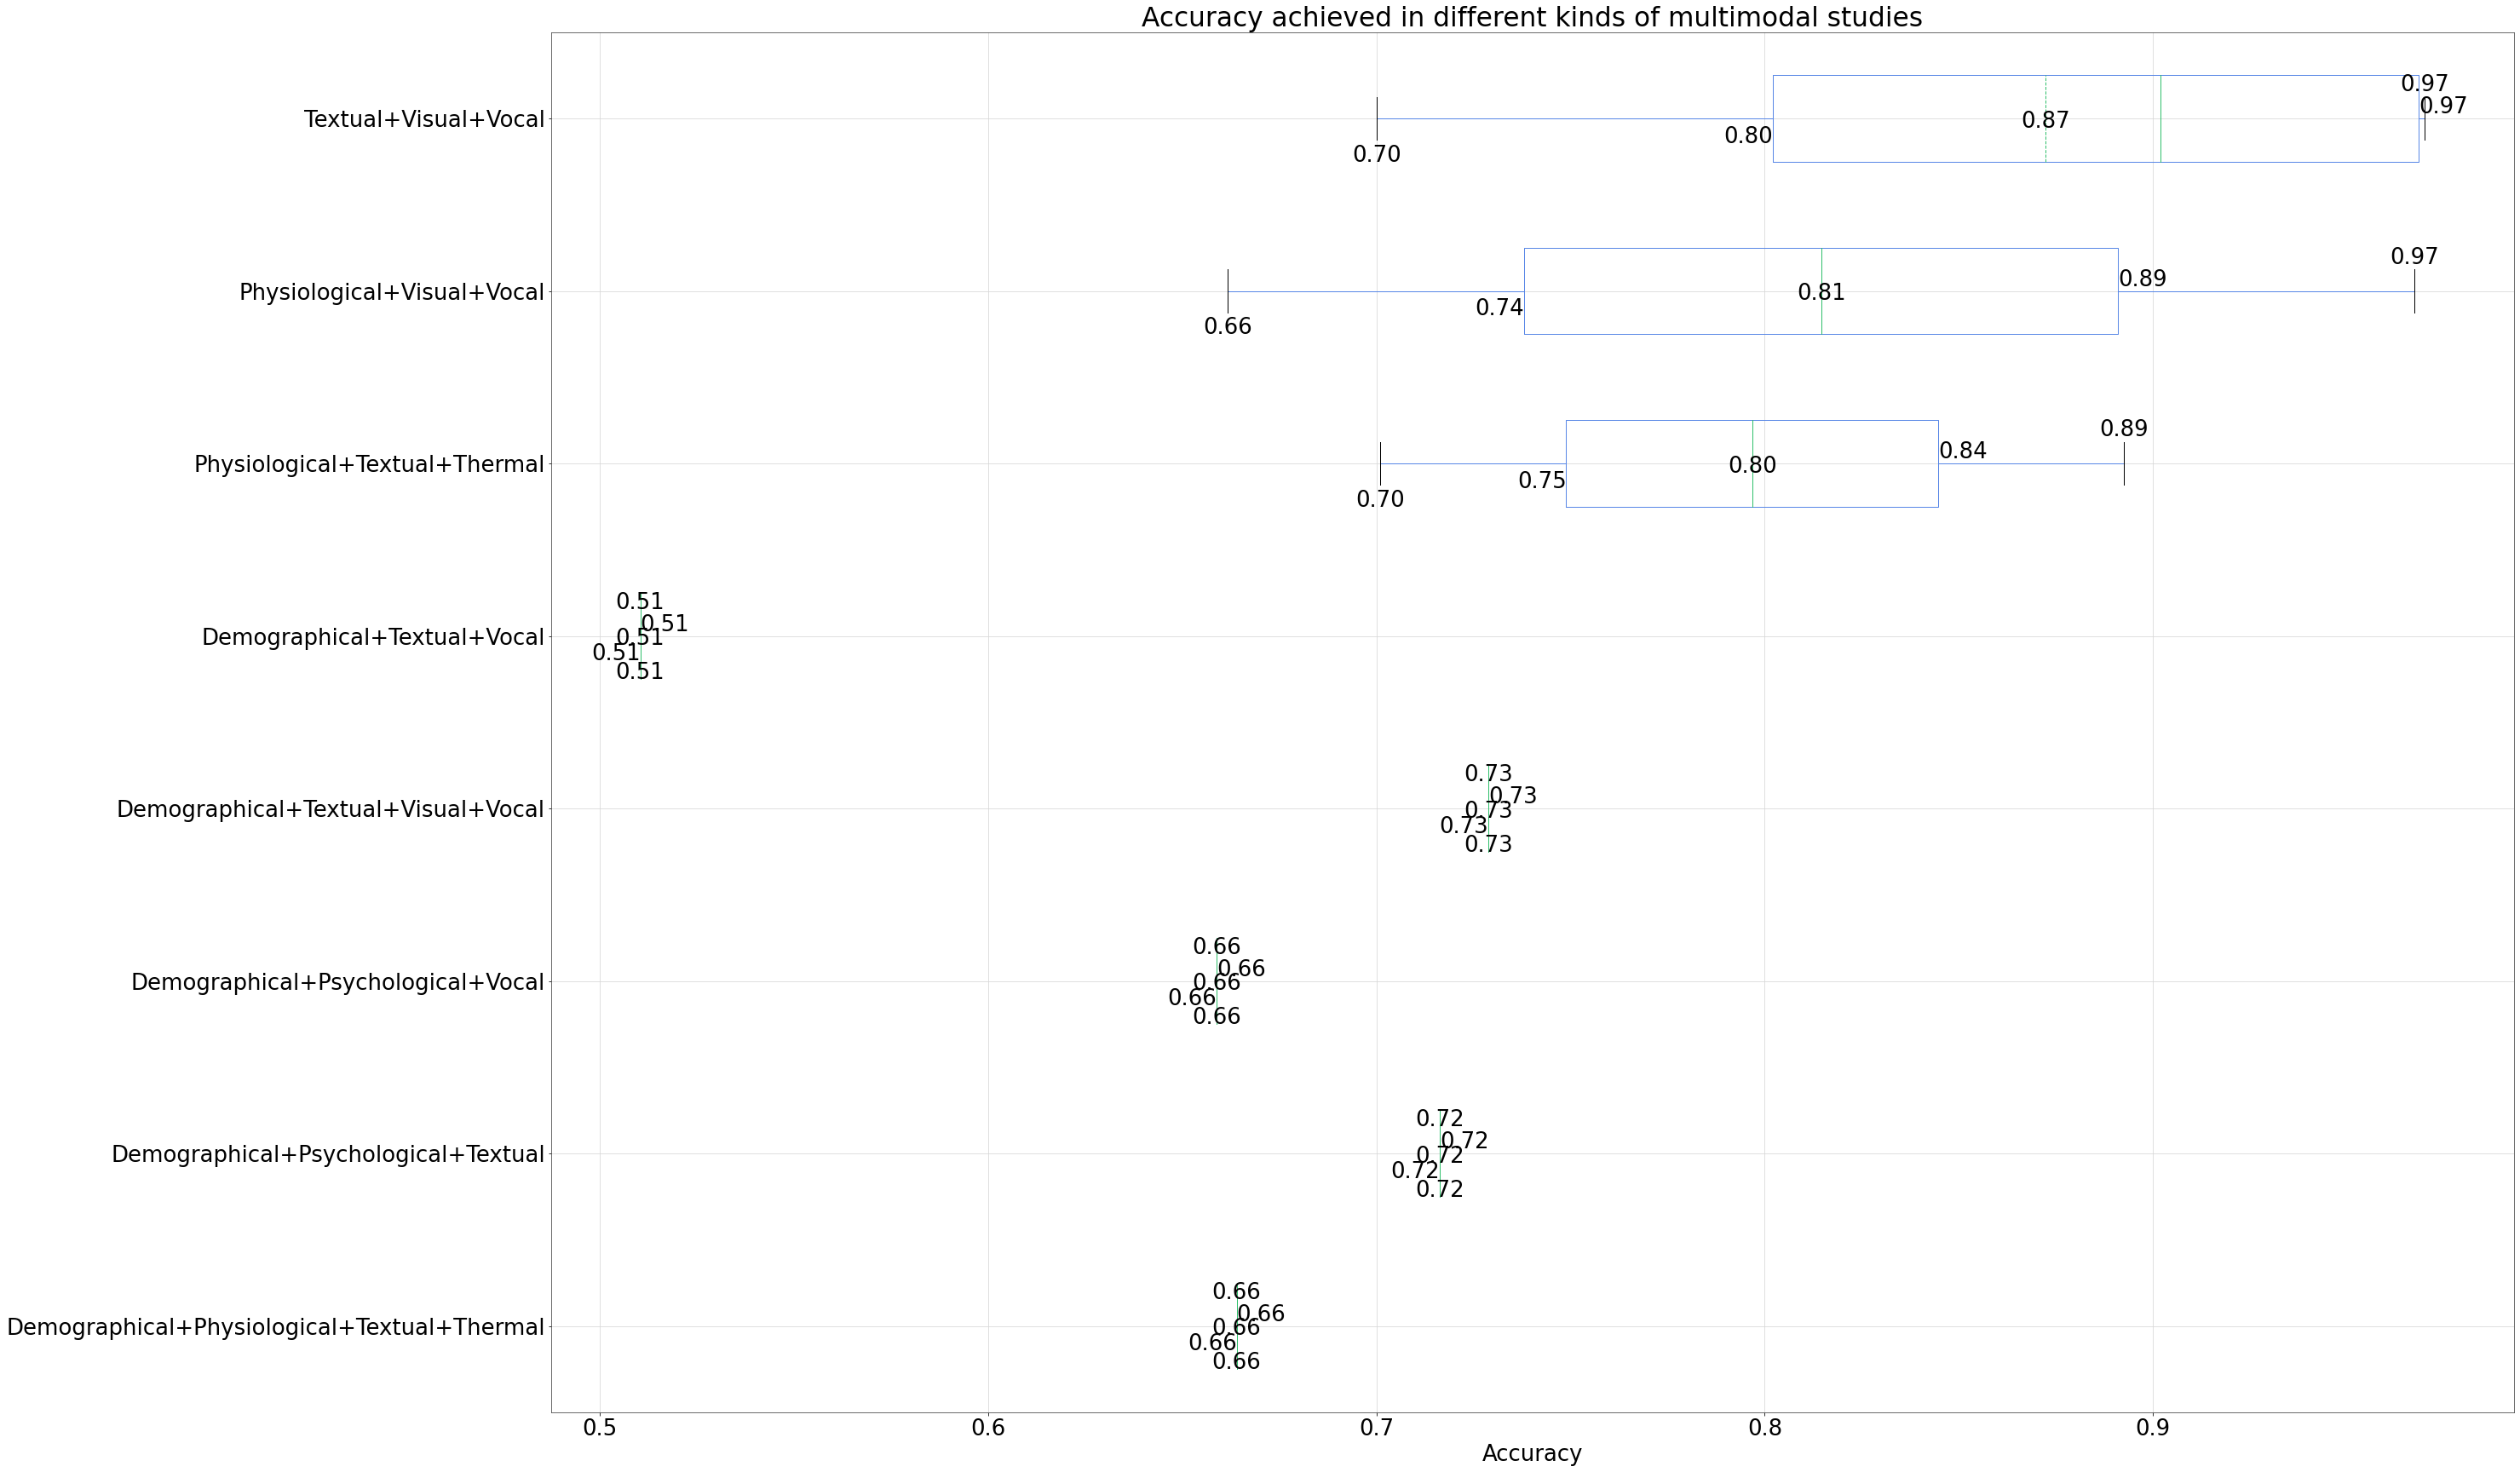

In [104]:
fig, ax1 = plt.subplots(figsize=(40,30))
bp = accuracy_mod_mult_df.boxplot(column=['Accuracy'], by='Modality', return_type='dict', ax=ax1,
                                  showmeans=True, meanline=True, whis=(0,100), patch_artist=False, vert=False)
fig.suptitle('')
ax1.set_title('Accuracy achieved in different kinds of multimodal studies')
plt.xlabel('Accuracy')
utility.show_bp_data(bp, False, ax1, mean_offset=0.20)
plt.show()

#### 8.6. Accuracy by Technique analysis

In [105]:
accuracy_technique_df = accuracy_df.loc[:, ['Accuracy', 'Technique']]
#accuracy_technique_df.head(100)

In [106]:
accuracy_technique_all_sum_df = pd.DataFrame(group.describe().rename(columns={'Accuracy':Technique}).squeeze()
                                            for Technique, group in accuracy_technique_df.groupby('Technique'))
accuracy_technique_all_sum_df.drop(columns=['25%', '50%', '75%'], inplace=True)
accuracy_technique_all_sum_df = accuracy_technique_all_sum_df.round({'count': 0, 'mean': 3, 'std': 3, 'min': 3, 'max': 3})
#accuracy_technique_all_sum_df.head(100)

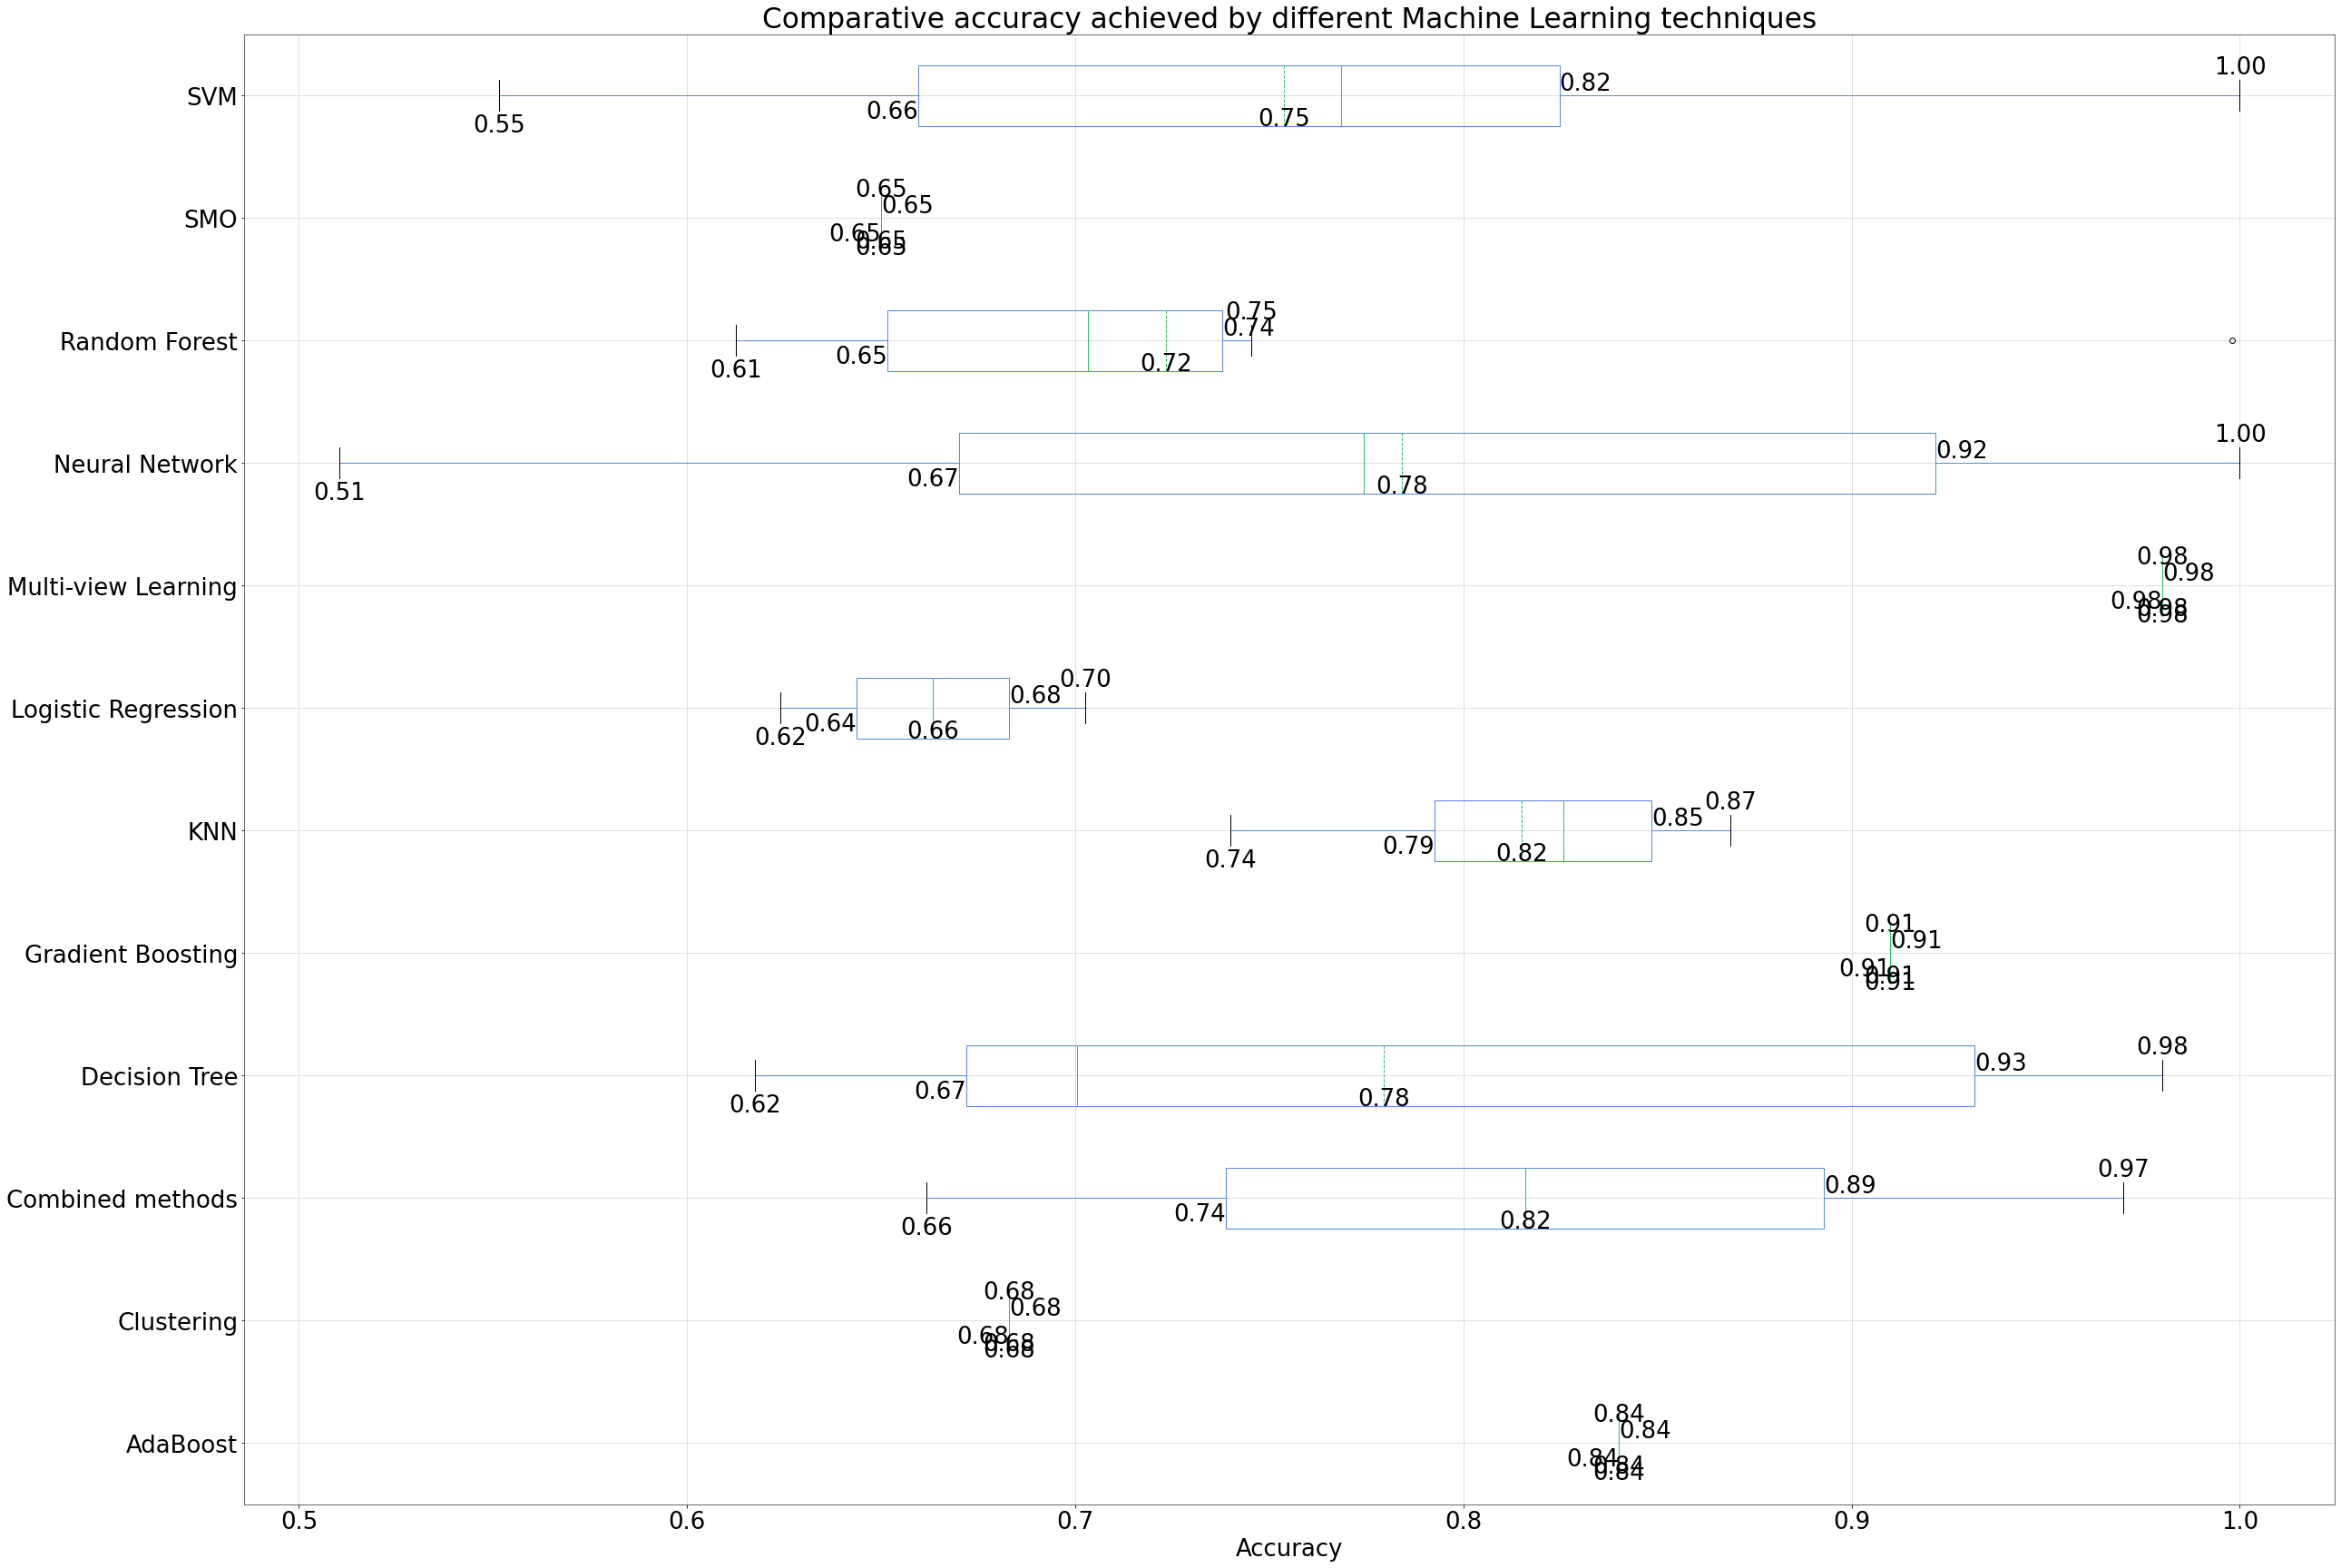

In [107]:
fig, ax1 = plt.subplots(figsize=(40,30))
bp = accuracy_df.boxplot(ax=ax1, column=['Accuracy'], by='Technique', return_type='dict', 
                        showmeans=True, meanline=True, patch_artist=False, vert=False)
fig.suptitle('')
ax1.set_title('Comparative accuracy achieved by different Machine Learning techniques')
plt.xlabel('Accuracy')
utility.show_bp_data(bp, False, ax1)
plt.show()

In [108]:
accuracy_modality_technique_df = accuracy_df.loc[:, ['Accuracy', 'Modality_cardinality', 'Technique']]
#accuracy_modality_technique_df

In [109]:
accuracy_modality_technique_sum_df = pd.DataFrame(group.describe().rename(columns={'Accuracy':Technique}).squeeze()
                                                  for Technique, group in accuracy_modality_technique_df.groupby(['Technique', 'Modality_cardinality']))
accuracy_modality_technique_sum_df.drop(columns=['25%', '50%', '75%'], inplace=True)
accuracy_modality_technique_sum_df = accuracy_modality_technique_sum_df.round({'count': 0, 'mean': 3, 'std': 3, 'min': 3, 'max': 3})
#accuracy_modality_technique_sum_df

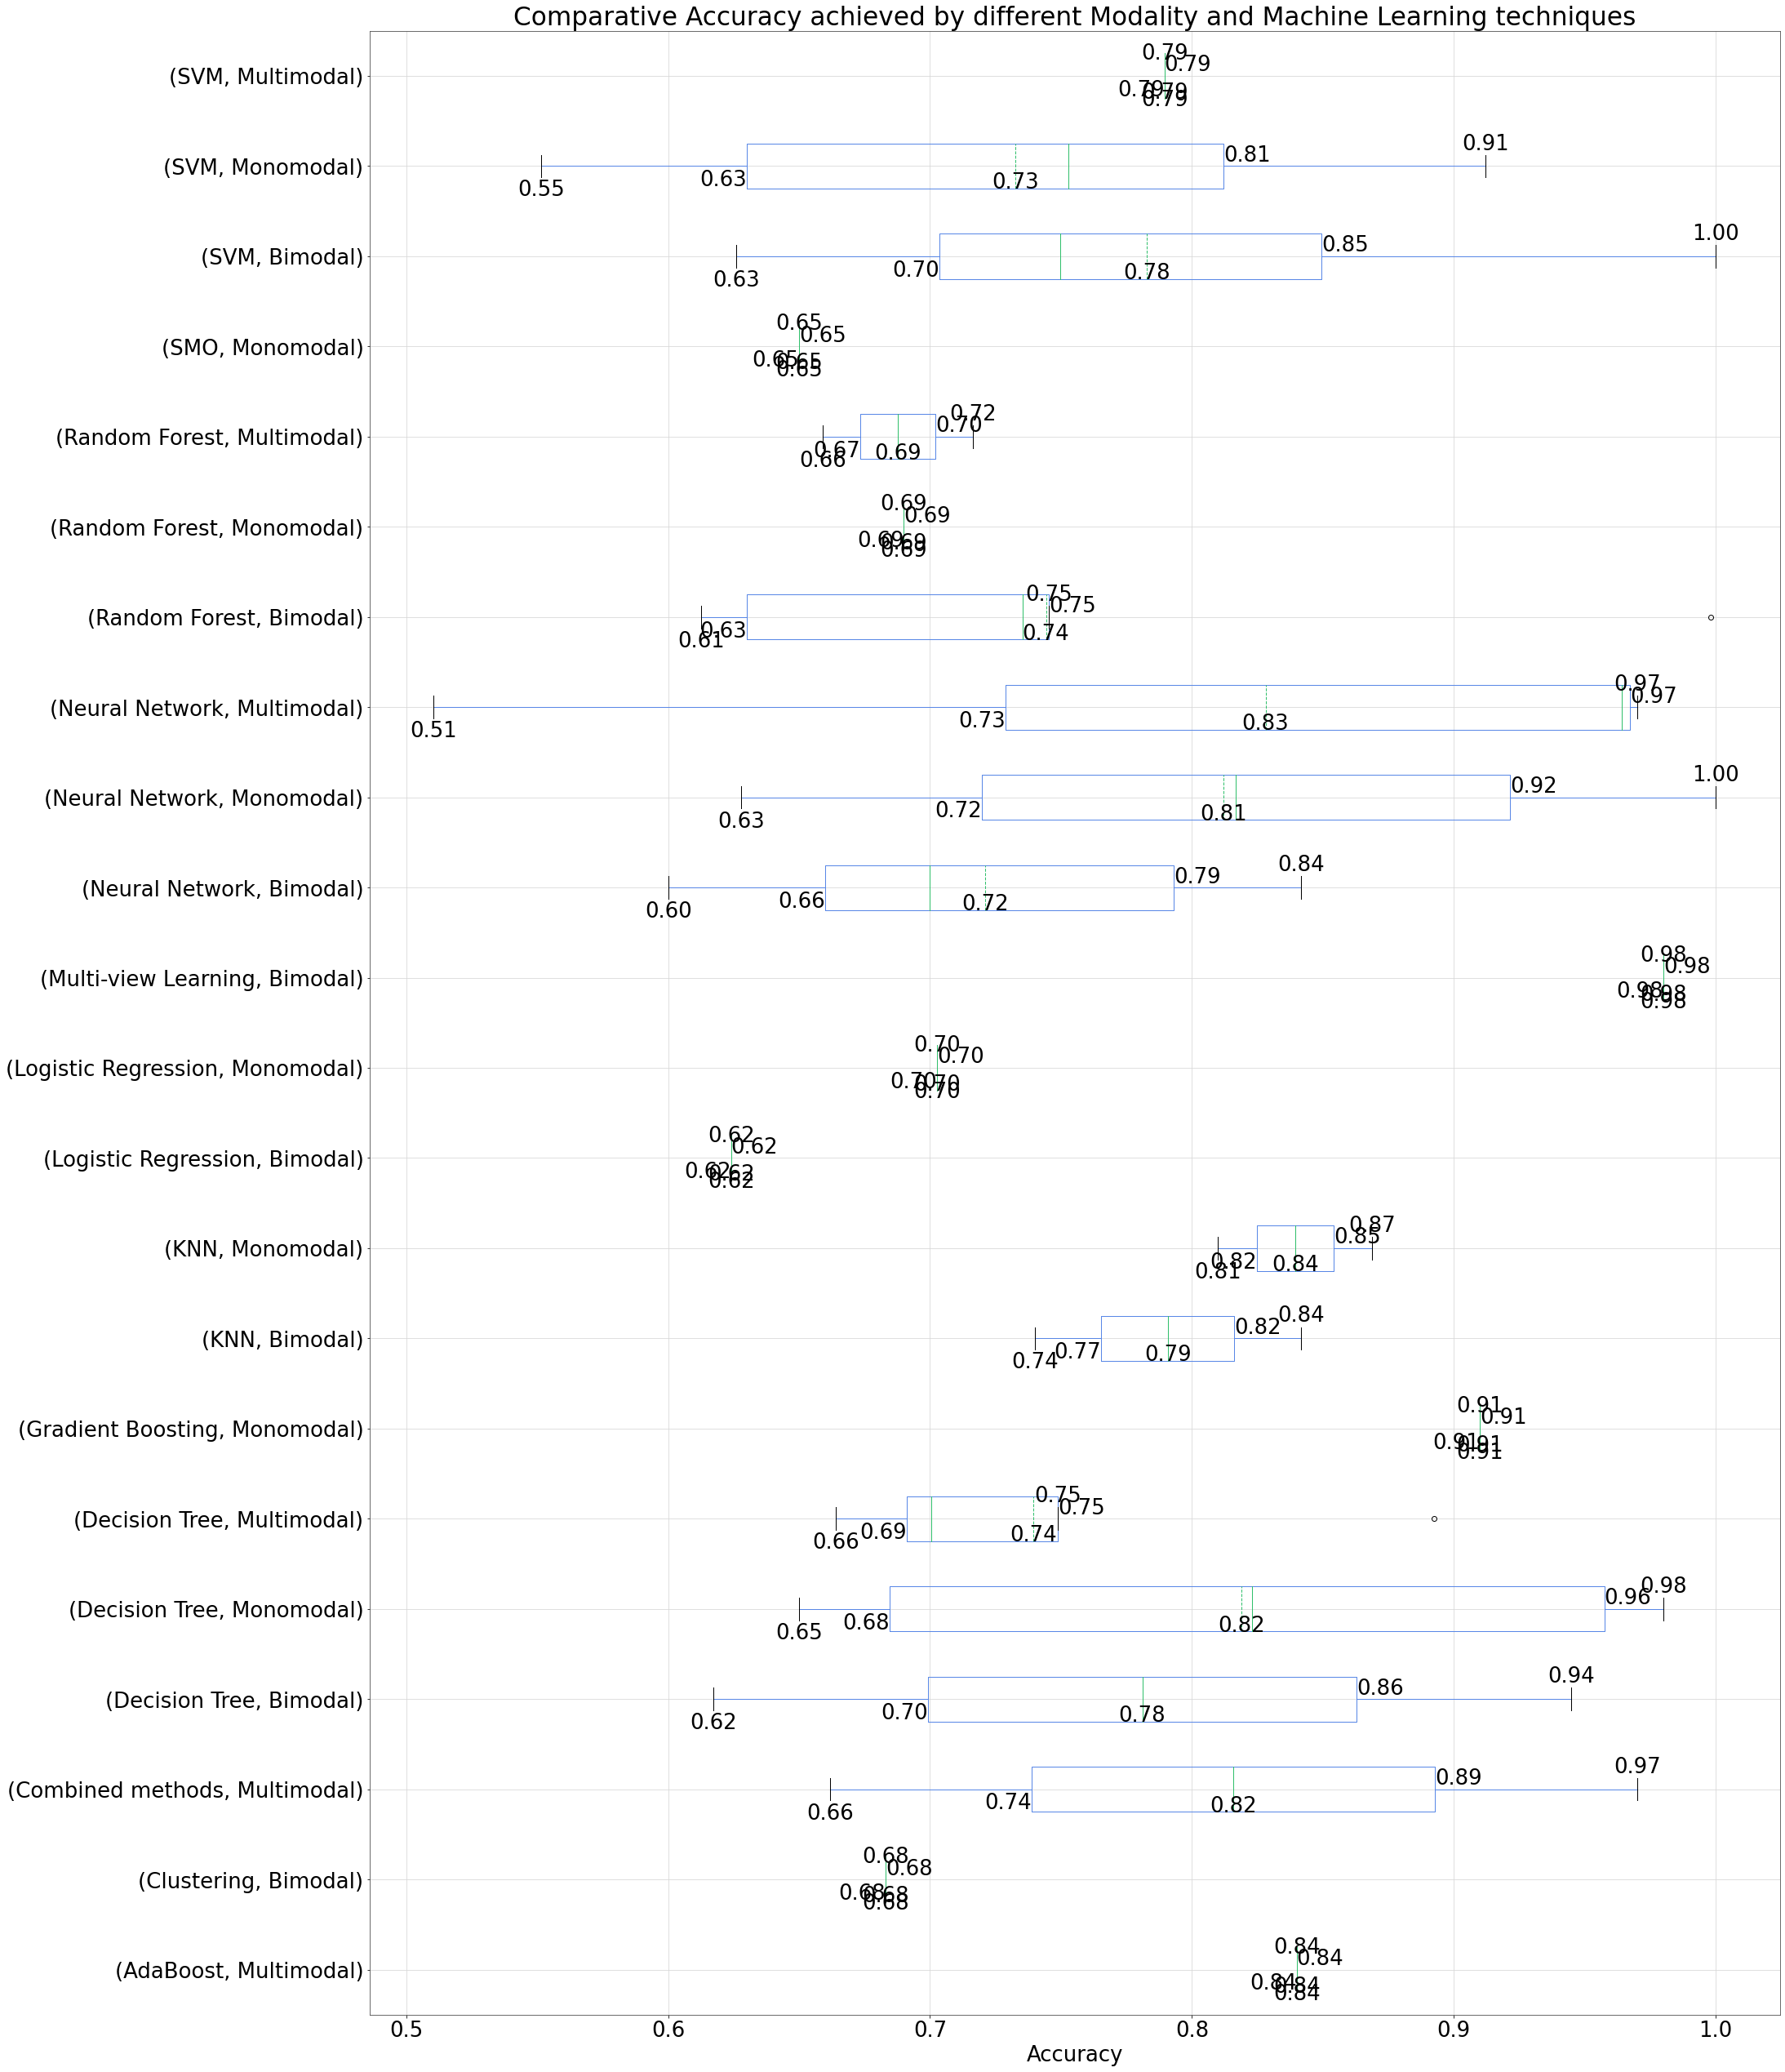

In [110]:
fig, ax1 = plt.subplots(figsize=(30,45))
bp = accuracy_df.boxplot(ax=ax1, column=['Accuracy'], by=['Technique', 'Modality_cardinality'], return_type='dict', 
                        showmeans=True, meanline=True, patch_artist=False, vert=False)
fig.suptitle('')
ax1.set_title('Comparative Accuracy achieved by different Modality and Machine Learning techniques')
plt.xlabel('Accuracy')
utility.show_bp_data(bp, False, ax1)
plt.show()

#### 8.7. Best results in studies (Accuracy $\ge$ 90%)
We decided to use the 90% accuracy criteria because it is the one used in [1].

[1] O’Sullivan M, Ekman P. **The wizards of deception detection**. The Detection of Deception in Forensic Contexts. 2004.

In [111]:
accuracy_ge_90_df = pd.DataFrame(studies_df[studies_df.Accuracy >= 0.9]).sort_values(['Accuracy'], ascending=False)
accuracy_ge_90_df.Dataset = accuracy_ge_90_df.Dataset.map(str) + ' (' + accuracy_ge_90_df.Dataset_cardinality.map(str) + ' rows)'
accuracy_ge_90_df['Acc/Tech'] = accuracy_ge_90_df.Accuracy.map(str) + ' / ' + accuracy_ge_90_df.Technique.map(str)
accuracy_ge_90_df['Modality'] = accuracy_ge_90_df.Modality_cardinality.map(str) + ' (' + accuracy_ge_90_df.Modality_combination.map(str) + ')'
accuracy_ge_90_df['Study'] = accuracy_ge_90_df.Title.map(str) + ' (' + accuracy_ge_90_df.Authors.map(str) + ')'
accuracy_ge_90_df.drop(columns=['Authors', 'Dataset_cardinality', 'Dataset_cardinality', 'Modality_cardinality', 'Modality_combination', 'Accuracy', 'Technique', 'Title'], inplace=True)
accuracy_ge_90_df = accuracy_ge_90_df.loc[:, ['Year', 'Study', 'Modality', 'Acc/Tech', 'Features', 'Dataset']]
#accuracy_ge_90_df.to_clipboard()
accuracy_ge_90_df.style.set_caption("<h2>Studies that achieved accuracy greater than or equals to 0.9</h2>")

### Finnish!!!